In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : features,
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_Sma

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 10:42 - loss: 2.2236 - STD: 0.0880 - MAE: 0.2140

  4/395 [..............................] - ETA: 8s - loss: 2.1118 - STD: 0.0476 - MAE: 0.2164   

  7/395 [..............................] - ETA: 8s - loss: 2.0981 - STD: 0.0437 - MAE: 0.2168

 10/395 [..............................] - ETA: 8s - loss: 2.0854 - STD: 0.0417 - MAE: 0.2167

 13/395 [..............................] - ETA: 8s - loss: 2.0780 - STD: 0.0415 - MAE: 0.2165

 16/395 [>.............................] - ETA: 8s - loss: 2.0735 - STD: 0.0411 - MAE: 0.2165

 19/395 [>.............................] - ETA: 8s - loss: 2.0686 - STD: 0.0400 - MAE: 0.2164

 22/395 [>.............................] - ETA: 8s - loss: 2.0639 - STD: 0.0389 - MAE: 0.2164

 25/395 [>.............................] - ETA: 8s - loss: 2.0590 - STD: 0.0381 - MAE: 0.2163

 28/395 [=>............................] - ETA: 8s - loss: 2.0531 - STD: 0.0379 - MAE: 0.2161

 31/395 [=>............................] - ETA: 8s - loss: 2.0445 - STD: 0.0386 - MAE: 0.2158

 34/395 [=>............................] - ETA: 8s - loss: 2.0353 - STD: 0.0399 - MAE: 0.2154

 37/395 [=>............................] - ETA: 8s - loss: 2.0261 - STD: 0.0419 - MAE: 0.2148

 40/395 [==>...........................] - ETA: 8s - loss: 2.0158 - STD: 0.0440 - MAE: 0.2143

 43/395 [==>...........................] - ETA: 7s - loss: 2.0053 - STD: 0.0458 - MAE: 0.2138

 46/395 [==>...........................] - ETA: 7s - loss: 1.9944 - STD: 0.0475 - MAE: 0.2132

 49/395 [==>...........................] - ETA: 7s - loss: 1.9836 - STD: 0.0494 - MAE: 0.2126

 52/395 [==>...........................] - ETA: 7s - loss: 1.9717 - STD: 0.0513 - MAE: 0.2120

 55/395 [===>..........................] - ETA: 7s - loss: 1.9592 - STD: 0.0532 - MAE: 0.2114

 58/395 [===>..........................] - ETA: 7s - loss: 1.9457 - STD: 0.0551 - MAE: 0.2107

 61/395 [===>..........................] - ETA: 7s - loss: 1.9314 - STD: 0.0572 - MAE: 0.2099

 64/395 [===>..........................] - ETA: 7s - loss: 1.9163 - STD: 0.0594 - MAE: 0.2091

 67/395 [====>.........................] - ETA: 7s - loss: 1.9011 - STD: 0.0617 - MAE: 0.2082

 70/395 [====>.........................] - ETA: 7s - loss: 1.8858 - STD: 0.0642 - MAE: 0.2073

 73/395 [====>.........................] - ETA: 7s - loss: 1.8709 - STD: 0.0667 - MAE: 0.2063

 76/395 [====>.........................] - ETA: 7s - loss: 1.8567 - STD: 0.0692 - MAE: 0.2054

 79/395 [=====>........................] - ETA: 7s - loss: 1.8429 - STD: 0.0716 - MAE: 0.2045

 82/395 [=====>........................] - ETA: 7s - loss: 1.8297 - STD: 0.0739 - MAE: 0.2036

 85/395 [=====>........................] - ETA: 7s - loss: 1.8171 - STD: 0.0761 - MAE: 0.2027

 88/395 [=====>........................] - ETA: 6s - loss: 1.8048 - STD: 0.0781 - MAE: 0.2019

 91/395 [=====>........................] - ETA: 6s - loss: 1.7932 - STD: 0.0801 - MAE: 0.2011

 94/395 [======>.......................] - ETA: 6s - loss: 1.7818 - STD: 0.0820 - MAE: 0.2003

 97/395 [======>.......................] - ETA: 6s - loss: 1.7709 - STD: 0.0838 - MAE: 0.1996

100/395 [======>.......................] - ETA: 6s - loss: 1.7604 - STD: 0.0856 - MAE: 0.1989

103/395 [======>.......................] - ETA: 6s - loss: 1.7507 - STD: 0.0873 - MAE: 0.1982

106/395 [=======>......................] - ETA: 6s - loss: 1.7414 - STD: 0.0889 - MAE: 0.1975

109/395 [=======>......................] - ETA: 6s - loss: 1.7322 - STD: 0.0904 - MAE: 0.1969

112/395 [=======>......................] - ETA: 6s - loss: 1.7232 - STD: 0.0919 - MAE: 0.1962

115/395 [=======>......................] - ETA: 6s - loss: 1.7147 - STD: 0.0933 - MAE: 0.1956

118/395 [=======>......................] - ETA: 6s - loss: 1.7062 - STD: 0.0947 - MAE: 0.1950

121/395 [========>.....................] - ETA: 6s - loss: 1.6980 - STD: 0.0961 - MAE: 0.1944

124/395 [========>.....................] - ETA: 6s - loss: 1.6902 - STD: 0.0974 - MAE: 0.1939

127/395 [========>.....................] - ETA: 6s - loss: 1.6827 - STD: 0.0986 - MAE: 0.1933

130/395 [========>.....................] - ETA: 6s - loss: 1.6751 - STD: 0.0998 - MAE: 0.1928

133/395 [=========>....................] - ETA: 5s - loss: 1.6680 - STD: 0.1010 - MAE: 0.1922

136/395 [=========>....................] - ETA: 5s - loss: 1.6609 - STD: 0.1022 - MAE: 0.1917

139/395 [=========>....................] - ETA: 5s - loss: 1.6542 - STD: 0.1033 - MAE: 0.1912

142/395 [=========>....................] - ETA: 5s - loss: 1.6476 - STD: 0.1044 - MAE: 0.1907

145/395 [==========>...................] - ETA: 5s - loss: 1.6411 - STD: 0.1055 - MAE: 0.1902

148/395 [==========>...................] - ETA: 5s - loss: 1.6348 - STD: 0.1065 - MAE: 0.1897

151/395 [==========>...................] - ETA: 5s - loss: 1.6287 - STD: 0.1076 - MAE: 0.1892

154/395 [==========>...................] - ETA: 5s - loss: 1.6226 - STD: 0.1086 - MAE: 0.1888

157/395 [==========>...................] - ETA: 5s - loss: 1.6167 - STD: 0.1095 - MAE: 0.1883

160/395 [===========>..................] - ETA: 5s - loss: 1.6109 - STD: 0.1105 - MAE: 0.1879

163/395 [===========>..................] - ETA: 5s - loss: 1.6055 - STD: 0.1115 - MAE: 0.1874

166/395 [===========>..................] - ETA: 5s - loss: 1.6001 - STD: 0.1124 - MAE: 0.1870

169/395 [===========>..................] - ETA: 5s - loss: 1.5950 - STD: 0.1132 - MAE: 0.1866

172/395 [============>.................] - ETA: 5s - loss: 1.5897 - STD: 0.1141 - MAE: 0.1862

175/395 [============>.................] - ETA: 4s - loss: 1.5846 - STD: 0.1150 - MAE: 0.1857

178/395 [============>.................] - ETA: 4s - loss: 1.5797 - STD: 0.1159 - MAE: 0.1853

181/395 [============>.................] - ETA: 4s - loss: 1.5749 - STD: 0.1167 - MAE: 0.1849

184/395 [============>.................] - ETA: 4s - loss: 1.5700 - STD: 0.1175 - MAE: 0.1845

187/395 [=============>................] - ETA: 4s - loss: 1.5653 - STD: 0.1183 - MAE: 0.1842

190/395 [=============>................] - ETA: 4s - loss: 1.5608 - STD: 0.1190 - MAE: 0.1838

193/395 [=============>................] - ETA: 4s - loss: 1.5562 - STD: 0.1198 - MAE: 0.1834

196/395 [=============>................] - ETA: 4s - loss: 1.5520 - STD: 0.1205 - MAE: 0.1831

199/395 [==============>...............] - ETA: 4s - loss: 1.5476 - STD: 0.1212 - MAE: 0.1827

202/395 [==============>...............] - ETA: 4s - loss: 1.5434 - STD: 0.1220 - MAE: 0.1823

205/395 [==============>...............] - ETA: 4s - loss: 1.5391 - STD: 0.1227 - MAE: 0.1820

208/395 [==============>...............] - ETA: 4s - loss: 1.5351 - STD: 0.1234 - MAE: 0.1816

211/395 [===============>..............] - ETA: 4s - loss: 1.5310 - STD: 0.1241 - MAE: 0.1813

214/395 [===============>..............] - ETA: 4s - loss: 1.5271 - STD: 0.1247 - MAE: 0.1810

217/395 [===============>..............] - ETA: 4s - loss: 1.5230 - STD: 0.1254 - MAE: 0.1806

220/395 [===============>..............] - ETA: 3s - loss: 1.5190 - STD: 0.1261 - MAE: 0.1803

223/395 [===============>..............] - ETA: 3s - loss: 1.5152 - STD: 0.1267 - MAE: 0.1799

226/395 [================>.............] - ETA: 3s - loss: 1.5116 - STD: 0.1274 - MAE: 0.1796

229/395 [================>.............] - ETA: 3s - loss: 1.5080 - STD: 0.1280 - MAE: 0.1793

232/395 [================>.............] - ETA: 3s - loss: 1.5045 - STD: 0.1286 - MAE: 0.1790

235/395 [================>.............] - ETA: 3s - loss: 1.5010 - STD: 0.1292 - MAE: 0.1787

238/395 [=================>............] - ETA: 3s - loss: 1.4975 - STD: 0.1298 - MAE: 0.1784

241/395 [=================>............] - ETA: 3s - loss: 1.4940 - STD: 0.1304 - MAE: 0.1781

244/395 [=================>............] - ETA: 3s - loss: 1.4907 - STD: 0.1310 - MAE: 0.1778

247/395 [=================>............] - ETA: 3s - loss: 1.4874 - STD: 0.1316 - MAE: 0.1775

250/395 [=================>............] - ETA: 3s - loss: 1.4841 - STD: 0.1322 - MAE: 0.1772

253/395 [==================>...........] - ETA: 3s - loss: 1.4809 - STD: 0.1327 - MAE: 0.1769

256/395 [==================>...........] - ETA: 3s - loss: 1.4777 - STD: 0.1333 - MAE: 0.1766

259/395 [==================>...........] - ETA: 3s - loss: 1.4745 - STD: 0.1338 - MAE: 0.1763

262/395 [==================>...........] - ETA: 3s - loss: 1.4714 - STD: 0.1343 - MAE: 0.1760

265/395 [===================>..........] - ETA: 2s - loss: 1.4683 - STD: 0.1348 - MAE: 0.1758

268/395 [===================>..........] - ETA: 2s - loss: 1.4654 - STD: 0.1353 - MAE: 0.1755

271/395 [===================>..........] - ETA: 2s - loss: 1.4624 - STD: 0.1359 - MAE: 0.1752

274/395 [===================>..........] - ETA: 2s - loss: 1.4595 - STD: 0.1364 - MAE: 0.1750

277/395 [====================>.........] - ETA: 2s - loss: 1.4567 - STD: 0.1369 - MAE: 0.1747

280/395 [====================>.........] - ETA: 2s - loss: 1.4540 - STD: 0.1373 - MAE: 0.1745

283/395 [====================>.........] - ETA: 2s - loss: 1.4515 - STD: 0.1378 - MAE: 0.1742

286/395 [====================>.........] - ETA: 2s - loss: 1.4488 - STD: 0.1383 - MAE: 0.1740

289/395 [====================>.........] - ETA: 2s - loss: 1.4462 - STD: 0.1387 - MAE: 0.1738

292/395 [=====================>........] - ETA: 2s - loss: 1.4436 - STD: 0.1391 - MAE: 0.1735

295/395 [=====================>........] - ETA: 2s - loss: 1.4411 - STD: 0.1396 - MAE: 0.1733

298/395 [=====================>........] - ETA: 2s - loss: 1.4385 - STD: 0.1400 - MAE: 0.1731

301/395 [=====================>........] - ETA: 2s - loss: 1.4360 - STD: 0.1405 - MAE: 0.1728

304/395 [======================>.......] - ETA: 2s - loss: 1.4336 - STD: 0.1409 - MAE: 0.1726

307/395 [======================>.......] - ETA: 1s - loss: 1.4312 - STD: 0.1413 - MAE: 0.1724

310/395 [======================>.......] - ETA: 1s - loss: 1.4289 - STD: 0.1417 - MAE: 0.1722

313/395 [======================>.......] - ETA: 1s - loss: 1.4266 - STD: 0.1421 - MAE: 0.1720

316/395 [=======================>......] - ETA: 1s - loss: 1.4244 - STD: 0.1425 - MAE: 0.1718

319/395 [=======================>......] - ETA: 1s - loss: 1.4221 - STD: 0.1429 - MAE: 0.1716

322/395 [=======================>......] - ETA: 1s - loss: 1.4199 - STD: 0.1433 - MAE: 0.1713

325/395 [=======================>......] - ETA: 1s - loss: 1.4177 - STD: 0.1437 - MAE: 0.1712

328/395 [=======================>......] - ETA: 1s - loss: 1.4156 - STD: 0.1440 - MAE: 0.1710

331/395 [========================>.....] - ETA: 1s - loss: 1.4134 - STD: 0.1444 - MAE: 0.1708

334/395 [========================>.....] - ETA: 1s - loss: 1.4111 - STD: 0.1448 - MAE: 0.1706

337/395 [========================>.....] - ETA: 1s - loss: 1.4090 - STD: 0.1451 - MAE: 0.1704

340/395 [========================>.....] - ETA: 1s - loss: 1.4068 - STD: 0.1455 - MAE: 0.1702

343/395 [=========================>....] - ETA: 1s - loss: 1.4046 - STD: 0.1458 - MAE: 0.1700

346/395 [=========================>....] - ETA: 1s - loss: 1.4026 - STD: 0.1462 - MAE: 0.1698

349/395 [=========================>....] - ETA: 1s - loss: 1.4006 - STD: 0.1465 - MAE: 0.1696

351/395 [=========================>....] - ETA: 1s - loss: 1.3996 - STD: 0.1467 - MAE: 0.1695

354/395 [=========================>....] - ETA: 1s - loss: 1.3976 - STD: 0.1471 - MAE: 0.1693

357/395 [==========================>...] - ETA: 0s - loss: 1.3957 - STD: 0.1474 - MAE: 0.1691

360/395 [==========================>...] - ETA: 0s - loss: 1.3937 - STD: 0.1477 - MAE: 0.1689

363/395 [==========================>...] - ETA: 0s - loss: 1.3919 - STD: 0.1481 - MAE: 0.1688

366/395 [==========================>...] - ETA: 0s - loss: 1.3899 - STD: 0.1484 - MAE: 0.1686

369/395 [===========================>..] - ETA: 0s - loss: 1.3880 - STD: 0.1487 - MAE: 0.1684

372/395 [===========================>..] - ETA: 0s - loss: 1.3861 - STD: 0.1490 - MAE: 0.1682

375/395 [===========================>..] - ETA: 0s - loss: 1.3843 - STD: 0.1493 - MAE: 0.1681

378/395 [===========================>..] - ETA: 0s - loss: 1.3825 - STD: 0.1496 - MAE: 0.1679

381/395 [===========================>..] - ETA: 0s - loss: 1.3807 - STD: 0.1499 - MAE: 0.1677

384/395 [============================>.] - ETA: 0s - loss: 1.3790 - STD: 0.1502 - MAE: 0.1676

387/395 [============================>.] - ETA: 0s - loss: 1.3772 - STD: 0.1505 - MAE: 0.1674

390/395 [============================>.] - ETA: 0s - loss: 1.3755 - STD: 0.1508 - MAE: 0.1672

393/395 [============================>.] - ETA: 0s - loss: 1.3737 - STD: 0.1511 - MAE: 0.1671

395/395 [==============================] - 13s 28ms/step - loss: 1.3724 - STD: 0.1513 - MAE: 0.1670 - val_loss: 1.1694 - val_STD: 0.1896 - val_MAE: 0.1452


Epoch 2/10000


  1/395 [..............................] - ETA: 25s - loss: 1.1446 - STD: 0.1889 - MAE: 0.1463

  4/395 [..............................] - ETA: 7s - loss: 1.1470 - STD: 0.1893 - MAE: 0.1460 

  7/395 [..............................] - ETA: 8s - loss: 1.1434 - STD: 0.1890 - MAE: 0.1459

 10/395 [..............................] - ETA: 8s - loss: 1.1426 - STD: 0.1889 - MAE: 0.1459

 13/395 [..............................] - ETA: 8s - loss: 1.1468 - STD: 0.1890 - MAE: 0.1460

 16/395 [>.............................] - ETA: 8s - loss: 1.1539 - STD: 0.1893 - MAE: 0.1462

 19/395 [>.............................] - ETA: 8s - loss: 1.1517 - STD: 0.1893 - MAE: 0.1461

 22/395 [>.............................] - ETA: 8s - loss: 1.1506 - STD: 0.1894 - MAE: 0.1461

 25/395 [>.............................] - ETA: 8s - loss: 1.1512 - STD: 0.1896 - MAE: 0.1460

 28/395 [=>............................] - ETA: 8s - loss: 1.1501 - STD: 0.1897 - MAE: 0.1460

 31/395 [=>............................] - ETA: 8s - loss: 1.1487 - STD: 0.1897 - MAE: 0.1459

 34/395 [=>............................] - ETA: 8s - loss: 1.1487 - STD: 0.1898 - MAE: 0.1459

 37/395 [=>............................] - ETA: 8s - loss: 1.1484 - STD: 0.1899 - MAE: 0.1458

 40/395 [==>...........................] - ETA: 8s - loss: 1.1476 - STD: 0.1898 - MAE: 0.1458

 43/395 [==>...........................] - ETA: 8s - loss: 1.1459 - STD: 0.1898 - MAE: 0.1457

 46/395 [==>...........................] - ETA: 7s - loss: 1.1448 - STD: 0.1899 - MAE: 0.1456

 49/395 [==>...........................] - ETA: 7s - loss: 1.1431 - STD: 0.1900 - MAE: 0.1455

 52/395 [==>...........................] - ETA: 7s - loss: 1.1424 - STD: 0.1900 - MAE: 0.1455

 55/395 [===>..........................] - ETA: 7s - loss: 1.1413 - STD: 0.1901 - MAE: 0.1454

 58/395 [===>..........................] - ETA: 7s - loss: 1.1401 - STD: 0.1902 - MAE: 0.1453

 61/395 [===>..........................] - ETA: 7s - loss: 1.1397 - STD: 0.1902 - MAE: 0.1453

 64/395 [===>..........................] - ETA: 7s - loss: 1.1396 - STD: 0.1903 - MAE: 0.1452

 67/395 [====>.........................] - ETA: 7s - loss: 1.1387 - STD: 0.1904 - MAE: 0.1452

 70/395 [====>.........................] - ETA: 7s - loss: 1.1387 - STD: 0.1905 - MAE: 0.1451

 73/395 [====>.........................] - ETA: 7s - loss: 1.1378 - STD: 0.1906 - MAE: 0.1450

 76/395 [====>.........................] - ETA: 7s - loss: 1.1382 - STD: 0.1907 - MAE: 0.1450

 79/395 [=====>........................] - ETA: 7s - loss: 1.1373 - STD: 0.1908 - MAE: 0.1449

 82/395 [=====>........................] - ETA: 7s - loss: 1.1370 - STD: 0.1908 - MAE: 0.1449

 85/395 [=====>........................] - ETA: 7s - loss: 1.1369 - STD: 0.1909 - MAE: 0.1449

 88/395 [=====>........................] - ETA: 7s - loss: 1.1370 - STD: 0.1909 - MAE: 0.1449

 91/395 [=====>........................] - ETA: 6s - loss: 1.1365 - STD: 0.1909 - MAE: 0.1448

 94/395 [======>.......................] - ETA: 6s - loss: 1.1360 - STD: 0.1910 - MAE: 0.1448

 97/395 [======>.......................] - ETA: 6s - loss: 1.1355 - STD: 0.1911 - MAE: 0.1447

100/395 [======>.......................] - ETA: 6s - loss: 1.1350 - STD: 0.1912 - MAE: 0.1447

103/395 [======>.......................] - ETA: 6s - loss: 1.1344 - STD: 0.1912 - MAE: 0.1446

106/395 [=======>......................] - ETA: 6s - loss: 1.1338 - STD: 0.1913 - MAE: 0.1446

109/395 [=======>......................] - ETA: 6s - loss: 1.1331 - STD: 0.1913 - MAE: 0.1445

112/395 [=======>......................] - ETA: 6s - loss: 1.1321 - STD: 0.1914 - MAE: 0.1444

115/395 [=======>......................] - ETA: 6s - loss: 1.1312 - STD: 0.1914 - MAE: 0.1444

118/395 [=======>......................] - ETA: 6s - loss: 1.1308 - STD: 0.1915 - MAE: 0.1443

121/395 [========>.....................] - ETA: 6s - loss: 1.1301 - STD: 0.1916 - MAE: 0.1443

124/395 [========>.....................] - ETA: 6s - loss: 1.1294 - STD: 0.1916 - MAE: 0.1442

127/395 [========>.....................] - ETA: 6s - loss: 1.1288 - STD: 0.1917 - MAE: 0.1442

130/395 [========>.....................] - ETA: 6s - loss: 1.1293 - STD: 0.1918 - MAE: 0.1442

133/395 [=========>....................] - ETA: 5s - loss: 1.1290 - STD: 0.1918 - MAE: 0.1441

136/395 [=========>....................] - ETA: 5s - loss: 1.1287 - STD: 0.1919 - MAE: 0.1441

139/395 [=========>....................] - ETA: 5s - loss: 1.1282 - STD: 0.1920 - MAE: 0.1440

142/395 [=========>....................] - ETA: 5s - loss: 1.1277 - STD: 0.1920 - MAE: 0.1440

145/395 [==========>...................] - ETA: 5s - loss: 1.1270 - STD: 0.1920 - MAE: 0.1439

148/395 [==========>...................] - ETA: 5s - loss: 1.1268 - STD: 0.1921 - MAE: 0.1439

151/395 [==========>...................] - ETA: 5s - loss: 1.1264 - STD: 0.1922 - MAE: 0.1439

154/395 [==========>...................] - ETA: 5s - loss: 1.1259 - STD: 0.1922 - MAE: 0.1438

157/395 [==========>...................] - ETA: 5s - loss: 1.1253 - STD: 0.1923 - MAE: 0.1438

160/395 [===========>..................] - ETA: 5s - loss: 1.1248 - STD: 0.1923 - MAE: 0.1437

163/395 [===========>..................] - ETA: 5s - loss: 1.1241 - STD: 0.1924 - MAE: 0.1437

166/395 [===========>..................] - ETA: 5s - loss: 1.1235 - STD: 0.1924 - MAE: 0.1436

169/395 [===========>..................] - ETA: 5s - loss: 1.1229 - STD: 0.1925 - MAE: 0.1436

172/395 [============>.................] - ETA: 5s - loss: 1.1223 - STD: 0.1925 - MAE: 0.1435

175/395 [============>.................] - ETA: 5s - loss: 1.1218 - STD: 0.1926 - MAE: 0.1435

178/395 [============>.................] - ETA: 4s - loss: 1.1212 - STD: 0.1926 - MAE: 0.1434

181/395 [============>.................] - ETA: 4s - loss: 1.1206 - STD: 0.1927 - MAE: 0.1434

184/395 [============>.................] - ETA: 4s - loss: 1.1200 - STD: 0.1928 - MAE: 0.1433

187/395 [=============>................] - ETA: 4s - loss: 1.1196 - STD: 0.1928 - MAE: 0.1433

190/395 [=============>................] - ETA: 4s - loss: 1.1195 - STD: 0.1929 - MAE: 0.1432

193/395 [=============>................] - ETA: 4s - loss: 1.1189 - STD: 0.1930 - MAE: 0.1432

196/395 [=============>................] - ETA: 4s - loss: 1.1183 - STD: 0.1930 - MAE: 0.1431

199/395 [==============>...............] - ETA: 4s - loss: 1.1181 - STD: 0.1931 - MAE: 0.1431

202/395 [==============>...............] - ETA: 4s - loss: 1.1175 - STD: 0.1932 - MAE: 0.1430

205/395 [==============>...............] - ETA: 4s - loss: 1.1169 - STD: 0.1932 - MAE: 0.1430

208/395 [==============>...............] - ETA: 4s - loss: 1.1164 - STD: 0.1933 - MAE: 0.1429

211/395 [===============>..............] - ETA: 4s - loss: 1.1159 - STD: 0.1933 - MAE: 0.1429

214/395 [===============>..............] - ETA: 4s - loss: 1.1154 - STD: 0.1934 - MAE: 0.1428

217/395 [===============>..............] - ETA: 4s - loss: 1.1148 - STD: 0.1934 - MAE: 0.1428

220/395 [===============>..............] - ETA: 4s - loss: 1.1143 - STD: 0.1935 - MAE: 0.1428

223/395 [===============>..............] - ETA: 3s - loss: 1.1138 - STD: 0.1935 - MAE: 0.1427

226/395 [================>.............] - ETA: 3s - loss: 1.1135 - STD: 0.1936 - MAE: 0.1427

229/395 [================>.............] - ETA: 3s - loss: 1.1131 - STD: 0.1936 - MAE: 0.1426

232/395 [================>.............] - ETA: 3s - loss: 1.1126 - STD: 0.1937 - MAE: 0.1426

235/395 [================>.............] - ETA: 3s - loss: 1.1122 - STD: 0.1938 - MAE: 0.1425

238/395 [=================>............] - ETA: 3s - loss: 1.1119 - STD: 0.1938 - MAE: 0.1425

241/395 [=================>............] - ETA: 3s - loss: 1.1116 - STD: 0.1939 - MAE: 0.1425

244/395 [=================>............] - ETA: 3s - loss: 1.1114 - STD: 0.1939 - MAE: 0.1424

247/395 [=================>............] - ETA: 3s - loss: 1.1112 - STD: 0.1940 - MAE: 0.1424

250/395 [=================>............] - ETA: 3s - loss: 1.1112 - STD: 0.1940 - MAE: 0.1424

253/395 [==================>...........] - ETA: 3s - loss: 1.1111 - STD: 0.1941 - MAE: 0.1424

256/395 [==================>...........] - ETA: 3s - loss: 1.1108 - STD: 0.1941 - MAE: 0.1423

259/395 [==================>...........] - ETA: 3s - loss: 1.1105 - STD: 0.1942 - MAE: 0.1423

262/395 [==================>...........] - ETA: 3s - loss: 1.1102 - STD: 0.1942 - MAE: 0.1423

265/395 [===================>..........] - ETA: 2s - loss: 1.1099 - STD: 0.1943 - MAE: 0.1422

268/395 [===================>..........] - ETA: 2s - loss: 1.1095 - STD: 0.1943 - MAE: 0.1422

271/395 [===================>..........] - ETA: 2s - loss: 1.1092 - STD: 0.1944 - MAE: 0.1422

274/395 [===================>..........] - ETA: 2s - loss: 1.1088 - STD: 0.1944 - MAE: 0.1421

277/395 [====================>.........] - ETA: 2s - loss: 1.1084 - STD: 0.1944 - MAE: 0.1421

280/395 [====================>.........] - ETA: 2s - loss: 1.1080 - STD: 0.1945 - MAE: 0.1420

283/395 [====================>.........] - ETA: 2s - loss: 1.1076 - STD: 0.1945 - MAE: 0.1420

286/395 [====================>.........] - ETA: 2s - loss: 1.1072 - STD: 0.1946 - MAE: 0.1420

289/395 [====================>.........] - ETA: 2s - loss: 1.1068 - STD: 0.1946 - MAE: 0.1419

292/395 [=====================>........] - ETA: 2s - loss: 1.1063 - STD: 0.1947 - MAE: 0.1419

295/395 [=====================>........] - ETA: 2s - loss: 1.1058 - STD: 0.1947 - MAE: 0.1419

298/395 [=====================>........] - ETA: 2s - loss: 1.1054 - STD: 0.1947 - MAE: 0.1418

301/395 [=====================>........] - ETA: 2s - loss: 1.1050 - STD: 0.1948 - MAE: 0.1418

304/395 [======================>.......] - ETA: 2s - loss: 1.1045 - STD: 0.1948 - MAE: 0.1417

307/395 [======================>.......] - ETA: 2s - loss: 1.1041 - STD: 0.1949 - MAE: 0.1417

310/395 [======================>.......] - ETA: 1s - loss: 1.1036 - STD: 0.1949 - MAE: 0.1417

313/395 [======================>.......] - ETA: 1s - loss: 1.1033 - STD: 0.1950 - MAE: 0.1416

316/395 [=======================>......] - ETA: 1s - loss: 1.1031 - STD: 0.1950 - MAE: 0.1416

319/395 [=======================>......] - ETA: 1s - loss: 1.1031 - STD: 0.1951 - MAE: 0.1416

322/395 [=======================>......] - ETA: 1s - loss: 1.1029 - STD: 0.1951 - MAE: 0.1415

325/395 [=======================>......] - ETA: 1s - loss: 1.1026 - STD: 0.1952 - MAE: 0.1415

328/395 [=======================>......] - ETA: 1s - loss: 1.1023 - STD: 0.1952 - MAE: 0.1415

331/395 [========================>.....] - ETA: 1s - loss: 1.1018 - STD: 0.1953 - MAE: 0.1414

334/395 [========================>.....] - ETA: 1s - loss: 1.1014 - STD: 0.1953 - MAE: 0.1414

337/395 [========================>.....] - ETA: 1s - loss: 1.1010 - STD: 0.1953 - MAE: 0.1414

340/395 [========================>.....] - ETA: 1s - loss: 1.1005 - STD: 0.1954 - MAE: 0.1413

343/395 [=========================>....] - ETA: 1s - loss: 1.1000 - STD: 0.1954 - MAE: 0.1413

346/395 [=========================>....] - ETA: 1s - loss: 1.0996 - STD: 0.1955 - MAE: 0.1412

349/395 [=========================>....] - ETA: 1s - loss: 1.0992 - STD: 0.1955 - MAE: 0.1412

352/395 [=========================>....] - ETA: 0s - loss: 1.0987 - STD: 0.1956 - MAE: 0.1411

355/395 [=========================>....] - ETA: 0s - loss: 1.0983 - STD: 0.1956 - MAE: 0.1411

358/395 [==========================>...] - ETA: 0s - loss: 1.0979 - STD: 0.1956 - MAE: 0.1411

361/395 [==========================>...] - ETA: 0s - loss: 1.0976 - STD: 0.1957 - MAE: 0.1410

364/395 [==========================>...] - ETA: 0s - loss: 1.0972 - STD: 0.1957 - MAE: 0.1410

367/395 [==========================>...] - ETA: 0s - loss: 1.0967 - STD: 0.1958 - MAE: 0.1410

370/395 [===========================>..] - ETA: 0s - loss: 1.0963 - STD: 0.1958 - MAE: 0.1409

373/395 [===========================>..] - ETA: 0s - loss: 1.0959 - STD: 0.1959 - MAE: 0.1409

376/395 [===========================>..] - ETA: 0s - loss: 1.0955 - STD: 0.1959 - MAE: 0.1408

379/395 [===========================>..] - ETA: 0s - loss: 1.0950 - STD: 0.1960 - MAE: 0.1408

382/395 [============================>.] - ETA: 0s - loss: 1.0947 - STD: 0.1960 - MAE: 0.1408

385/395 [============================>.] - ETA: 0s - loss: 1.0942 - STD: 0.1961 - MAE: 0.1407

388/395 [============================>.] - ETA: 0s - loss: 1.0939 - STD: 0.1961 - MAE: 0.1407

391/395 [============================>.] - ETA: 0s - loss: 1.0936 - STD: 0.1962 - MAE: 0.1406

394/395 [============================>.] - ETA: 0s - loss: 1.0933 - STD: 0.1962 - MAE: 0.1406

395/395 [==============================] - 10s 25ms/step - loss: 1.0932 - STD: 0.1962 - MAE: 0.1406 - val_loss: 1.1269 - val_STD: 0.2038 - val_MAE: 0.1387


Epoch 3/10000


  1/395 [..............................] - ETA: 18s - loss: 1.0560 - STD: 0.2006 - MAE: 0.1368

  4/395 [..............................] - ETA: 9s - loss: 1.0449 - STD: 0.2016 - MAE: 0.1359 

  7/395 [..............................] - ETA: 8s - loss: 1.0469 - STD: 0.2021 - MAE: 0.1358

 10/395 [..............................] - ETA: 8s - loss: 1.0445 - STD: 0.2020 - MAE: 0.1358

 13/395 [..............................] - ETA: 8s - loss: 1.0428 - STD: 0.2023 - MAE: 0.1356

 16/395 [>.............................] - ETA: 8s - loss: 1.0408 - STD: 0.2024 - MAE: 0.1354

 19/395 [>.............................] - ETA: 8s - loss: 1.0406 - STD: 0.2024 - MAE: 0.1354

 22/395 [>.............................] - ETA: 8s - loss: 1.0397 - STD: 0.2024 - MAE: 0.1353

 25/395 [>.............................] - ETA: 8s - loss: 1.0393 - STD: 0.2025 - MAE: 0.1353

 28/395 [=>............................] - ETA: 8s - loss: 1.0385 - STD: 0.2026 - MAE: 0.1352

 31/395 [=>............................] - ETA: 8s - loss: 1.0376 - STD: 0.2027 - MAE: 0.1351

 34/395 [=>............................] - ETA: 8s - loss: 1.0372 - STD: 0.2027 - MAE: 0.1351

 37/395 [=>............................] - ETA: 8s - loss: 1.0376 - STD: 0.2026 - MAE: 0.1352

 40/395 [==>...........................] - ETA: 8s - loss: 1.0368 - STD: 0.2027 - MAE: 0.1351

 43/395 [==>...........................] - ETA: 8s - loss: 1.0360 - STD: 0.2027 - MAE: 0.1350

 46/395 [==>...........................] - ETA: 7s - loss: 1.0347 - STD: 0.2028 - MAE: 0.1349

 49/395 [==>...........................] - ETA: 7s - loss: 1.0347 - STD: 0.2029 - MAE: 0.1349

 52/395 [==>...........................] - ETA: 7s - loss: 1.0345 - STD: 0.2030 - MAE: 0.1348

 55/395 [===>..........................] - ETA: 7s - loss: 1.0343 - STD: 0.2030 - MAE: 0.1348

 58/395 [===>..........................] - ETA: 7s - loss: 1.0347 - STD: 0.2031 - MAE: 0.1348

 61/395 [===>..........................] - ETA: 7s - loss: 1.0347 - STD: 0.2032 - MAE: 0.1348

 64/395 [===>..........................] - ETA: 7s - loss: 1.0349 - STD: 0.2032 - MAE: 0.1348

 67/395 [====>.........................] - ETA: 7s - loss: 1.0344 - STD: 0.2032 - MAE: 0.1347

 70/395 [====>.........................] - ETA: 7s - loss: 1.0347 - STD: 0.2033 - MAE: 0.1347

 73/395 [====>.........................] - ETA: 7s - loss: 1.0343 - STD: 0.2033 - MAE: 0.1347

 76/395 [====>.........................] - ETA: 7s - loss: 1.0337 - STD: 0.2033 - MAE: 0.1347

 79/395 [=====>........................] - ETA: 7s - loss: 1.0337 - STD: 0.2033 - MAE: 0.1347

 82/395 [=====>........................] - ETA: 7s - loss: 1.0339 - STD: 0.2034 - MAE: 0.1347

 85/395 [=====>........................] - ETA: 7s - loss: 1.0341 - STD: 0.2034 - MAE: 0.1347

 88/395 [=====>........................] - ETA: 7s - loss: 1.0335 - STD: 0.2035 - MAE: 0.1346

 91/395 [=====>........................] - ETA: 6s - loss: 1.0333 - STD: 0.2035 - MAE: 0.1346

 94/395 [======>.......................] - ETA: 6s - loss: 1.0331 - STD: 0.2035 - MAE: 0.1346

 97/395 [======>.......................] - ETA: 6s - loss: 1.0333 - STD: 0.2035 - MAE: 0.1346

100/395 [======>.......................] - ETA: 6s - loss: 1.0327 - STD: 0.2035 - MAE: 0.1345

103/395 [======>.......................] - ETA: 6s - loss: 1.0329 - STD: 0.2036 - MAE: 0.1345

106/395 [=======>......................] - ETA: 6s - loss: 1.0328 - STD: 0.2036 - MAE: 0.1345

109/395 [=======>......................] - ETA: 6s - loss: 1.0336 - STD: 0.2036 - MAE: 0.1345

112/395 [=======>......................] - ETA: 6s - loss: 1.0337 - STD: 0.2037 - MAE: 0.1345

115/395 [=======>......................] - ETA: 6s - loss: 1.0336 - STD: 0.2037 - MAE: 0.1345

118/395 [=======>......................] - ETA: 6s - loss: 1.0336 - STD: 0.2037 - MAE: 0.1345

121/395 [========>.....................] - ETA: 6s - loss: 1.0333 - STD: 0.2037 - MAE: 0.1345

124/395 [========>.....................] - ETA: 6s - loss: 1.0330 - STD: 0.2037 - MAE: 0.1344

127/395 [========>.....................] - ETA: 6s - loss: 1.0326 - STD: 0.2038 - MAE: 0.1344

130/395 [========>.....................] - ETA: 6s - loss: 1.0322 - STD: 0.2038 - MAE: 0.1344

133/395 [=========>....................] - ETA: 5s - loss: 1.0320 - STD: 0.2039 - MAE: 0.1343

136/395 [=========>....................] - ETA: 5s - loss: 1.0317 - STD: 0.2039 - MAE: 0.1343

139/395 [=========>....................] - ETA: 5s - loss: 1.0314 - STD: 0.2039 - MAE: 0.1343

142/395 [=========>....................] - ETA: 5s - loss: 1.0317 - STD: 0.2039 - MAE: 0.1343

145/395 [==========>...................] - ETA: 5s - loss: 1.0315 - STD: 0.2040 - MAE: 0.1343

148/395 [==========>...................] - ETA: 5s - loss: 1.0313 - STD: 0.2040 - MAE: 0.1342

151/395 [==========>...................] - ETA: 5s - loss: 1.0311 - STD: 0.2040 - MAE: 0.1342

154/395 [==========>...................] - ETA: 5s - loss: 1.0305 - STD: 0.2041 - MAE: 0.1342

157/395 [==========>...................] - ETA: 5s - loss: 1.0300 - STD: 0.2041 - MAE: 0.1341

160/395 [===========>..................] - ETA: 5s - loss: 1.0298 - STD: 0.2041 - MAE: 0.1341

163/395 [===========>..................] - ETA: 5s - loss: 1.0296 - STD: 0.2042 - MAE: 0.1341

166/395 [===========>..................] - ETA: 5s - loss: 1.0295 - STD: 0.2042 - MAE: 0.1340

169/395 [===========>..................] - ETA: 5s - loss: 1.0293 - STD: 0.2042 - MAE: 0.1340

172/395 [============>.................] - ETA: 5s - loss: 1.0290 - STD: 0.2043 - MAE: 0.1340

175/395 [============>.................] - ETA: 5s - loss: 1.0286 - STD: 0.2043 - MAE: 0.1339

178/395 [============>.................] - ETA: 4s - loss: 1.0283 - STD: 0.2044 - MAE: 0.1339

181/395 [============>.................] - ETA: 4s - loss: 1.0279 - STD: 0.2044 - MAE: 0.1339

184/395 [============>.................] - ETA: 4s - loss: 1.0273 - STD: 0.2044 - MAE: 0.1338

187/395 [=============>................] - ETA: 4s - loss: 1.0269 - STD: 0.2045 - MAE: 0.1338

190/395 [=============>................] - ETA: 4s - loss: 1.0264 - STD: 0.2045 - MAE: 0.1338

193/395 [=============>................] - ETA: 4s - loss: 1.0260 - STD: 0.2045 - MAE: 0.1337

196/395 [=============>................] - ETA: 4s - loss: 1.0257 - STD: 0.2046 - MAE: 0.1337

199/395 [==============>...............] - ETA: 4s - loss: 1.0253 - STD: 0.2046 - MAE: 0.1336

202/395 [==============>...............] - ETA: 4s - loss: 1.0249 - STD: 0.2047 - MAE: 0.1336

205/395 [==============>...............] - ETA: 4s - loss: 1.0244 - STD: 0.2047 - MAE: 0.1335

208/395 [==============>...............] - ETA: 4s - loss: 1.0242 - STD: 0.2048 - MAE: 0.1335

211/395 [===============>..............] - ETA: 4s - loss: 1.0239 - STD: 0.2048 - MAE: 0.1335

214/395 [===============>..............] - ETA: 4s - loss: 1.0235 - STD: 0.2049 - MAE: 0.1335

217/395 [===============>..............] - ETA: 4s - loss: 1.0232 - STD: 0.2049 - MAE: 0.1334

220/395 [===============>..............] - ETA: 3s - loss: 1.0231 - STD: 0.2049 - MAE: 0.1334

223/395 [===============>..............] - ETA: 3s - loss: 1.0229 - STD: 0.2050 - MAE: 0.1334

226/395 [================>.............] - ETA: 3s - loss: 1.0227 - STD: 0.2050 - MAE: 0.1333

229/395 [================>.............] - ETA: 3s - loss: 1.0224 - STD: 0.2051 - MAE: 0.1333

232/395 [================>.............] - ETA: 3s - loss: 1.0222 - STD: 0.2051 - MAE: 0.1333

235/395 [================>.............] - ETA: 3s - loss: 1.0219 - STD: 0.2051 - MAE: 0.1333

238/395 [=================>............] - ETA: 3s - loss: 1.0220 - STD: 0.2052 - MAE: 0.1332

241/395 [=================>............] - ETA: 3s - loss: 1.0217 - STD: 0.2052 - MAE: 0.1332

244/395 [=================>............] - ETA: 3s - loss: 1.0216 - STD: 0.2052 - MAE: 0.1332

247/395 [=================>............] - ETA: 3s - loss: 1.0213 - STD: 0.2053 - MAE: 0.1332

250/395 [=================>............] - ETA: 3s - loss: 1.0210 - STD: 0.2053 - MAE: 0.1331

253/395 [==================>...........] - ETA: 3s - loss: 1.0211 - STD: 0.2053 - MAE: 0.1331

256/395 [==================>...........] - ETA: 3s - loss: 1.0210 - STD: 0.2054 - MAE: 0.1331

259/395 [==================>...........] - ETA: 3s - loss: 1.0208 - STD: 0.2054 - MAE: 0.1331

262/395 [==================>...........] - ETA: 3s - loss: 1.0207 - STD: 0.2054 - MAE: 0.1330

265/395 [===================>..........] - ETA: 2s - loss: 1.0205 - STD: 0.2055 - MAE: 0.1330

268/395 [===================>..........] - ETA: 2s - loss: 1.0203 - STD: 0.2055 - MAE: 0.1330

271/395 [===================>..........] - ETA: 2s - loss: 1.0200 - STD: 0.2055 - MAE: 0.1330

274/395 [===================>..........] - ETA: 2s - loss: 1.0197 - STD: 0.2056 - MAE: 0.1329

277/395 [====================>.........] - ETA: 2s - loss: 1.0194 - STD: 0.2056 - MAE: 0.1329

280/395 [====================>.........] - ETA: 2s - loss: 1.0191 - STD: 0.2056 - MAE: 0.1329

283/395 [====================>.........] - ETA: 2s - loss: 1.0188 - STD: 0.2057 - MAE: 0.1328

286/395 [====================>.........] - ETA: 2s - loss: 1.0185 - STD: 0.2057 - MAE: 0.1328

289/395 [====================>.........] - ETA: 2s - loss: 1.0182 - STD: 0.2057 - MAE: 0.1328

292/395 [=====================>........] - ETA: 2s - loss: 1.0181 - STD: 0.2058 - MAE: 0.1328

295/395 [=====================>........] - ETA: 2s - loss: 1.0177 - STD: 0.2058 - MAE: 0.1327

298/395 [=====================>........] - ETA: 2s - loss: 1.0174 - STD: 0.2058 - MAE: 0.1327

301/395 [=====================>........] - ETA: 2s - loss: 1.0170 - STD: 0.2059 - MAE: 0.1327

304/395 [======================>.......] - ETA: 2s - loss: 1.0167 - STD: 0.2059 - MAE: 0.1326

307/395 [======================>.......] - ETA: 2s - loss: 1.0164 - STD: 0.2059 - MAE: 0.1326

310/395 [======================>.......] - ETA: 1s - loss: 1.0162 - STD: 0.2060 - MAE: 0.1326

313/395 [======================>.......] - ETA: 1s - loss: 1.0161 - STD: 0.2060 - MAE: 0.1326

316/395 [=======================>......] - ETA: 1s - loss: 1.0159 - STD: 0.2060 - MAE: 0.1325

319/395 [=======================>......] - ETA: 1s - loss: 1.0159 - STD: 0.2061 - MAE: 0.1325

322/395 [=======================>......] - ETA: 1s - loss: 1.0159 - STD: 0.2061 - MAE: 0.1325

325/395 [=======================>......] - ETA: 1s - loss: 1.0156 - STD: 0.2061 - MAE: 0.1325

328/395 [=======================>......] - ETA: 1s - loss: 1.0153 - STD: 0.2062 - MAE: 0.1324

331/395 [========================>.....] - ETA: 1s - loss: 1.0150 - STD: 0.2062 - MAE: 0.1324

334/395 [========================>.....] - ETA: 1s - loss: 1.0147 - STD: 0.2062 - MAE: 0.1324

337/395 [========================>.....] - ETA: 1s - loss: 1.0145 - STD: 0.2062 - MAE: 0.1324

340/395 [========================>.....] - ETA: 1s - loss: 1.0143 - STD: 0.2063 - MAE: 0.1323

343/395 [=========================>....] - ETA: 1s - loss: 1.0140 - STD: 0.2063 - MAE: 0.1323

346/395 [=========================>....] - ETA: 1s - loss: 1.0138 - STD: 0.2063 - MAE: 0.1323

349/395 [=========================>....] - ETA: 1s - loss: 1.0135 - STD: 0.2064 - MAE: 0.1323

352/395 [=========================>....] - ETA: 0s - loss: 1.0132 - STD: 0.2064 - MAE: 0.1322

355/395 [=========================>....] - ETA: 0s - loss: 1.0129 - STD: 0.2064 - MAE: 0.1322

358/395 [==========================>...] - ETA: 0s - loss: 1.0126 - STD: 0.2064 - MAE: 0.1322

361/395 [==========================>...] - ETA: 0s - loss: 1.0124 - STD: 0.2065 - MAE: 0.1321

364/395 [==========================>...] - ETA: 0s - loss: 1.0121 - STD: 0.2065 - MAE: 0.1321

367/395 [==========================>...] - ETA: 0s - loss: 1.0117 - STD: 0.2066 - MAE: 0.1321

370/395 [===========================>..] - ETA: 0s - loss: 1.0115 - STD: 0.2066 - MAE: 0.1320

373/395 [===========================>..] - ETA: 0s - loss: 1.0113 - STD: 0.2066 - MAE: 0.1320

376/395 [===========================>..] - ETA: 0s - loss: 1.0111 - STD: 0.2067 - MAE: 0.1320

379/395 [===========================>..] - ETA: 0s - loss: 1.0109 - STD: 0.2067 - MAE: 0.1320

382/395 [============================>.] - ETA: 0s - loss: 1.0106 - STD: 0.2067 - MAE: 0.1319

385/395 [============================>.] - ETA: 0s - loss: 1.0104 - STD: 0.2068 - MAE: 0.1319

388/395 [============================>.] - ETA: 0s - loss: 1.0101 - STD: 0.2068 - MAE: 0.1319

391/395 [============================>.] - ETA: 0s - loss: 1.0098 - STD: 0.2068 - MAE: 0.1319

394/395 [============================>.] - ETA: 0s - loss: 1.0096 - STD: 0.2069 - MAE: 0.1318

395/395 [==============================] - 10s 25ms/step - loss: 1.0095 - STD: 0.2069 - MAE: 0.1318 - val_loss: 1.1168 - val_STD: 0.2133 - val_MAE: 0.1344


Epoch 4/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9681 - STD: 0.2108 - MAE: 0.1279

  4/395 [..............................] - ETA: 9s - loss: 0.9706 - STD: 0.2108 - MAE: 0.1279 

  7/395 [..............................] - ETA: 8s - loss: 0.9850 - STD: 0.2107 - MAE: 0.1288

 10/395 [..............................] - ETA: 8s - loss: 0.9834 - STD: 0.2109 - MAE: 0.1286

 13/395 [..............................] - ETA: 8s - loss: 0.9823 - STD: 0.2111 - MAE: 0.1285

 16/395 [>.............................] - ETA: 8s - loss: 0.9821 - STD: 0.2112 - MAE: 0.1284

 19/395 [>.............................] - ETA: 8s - loss: 0.9806 - STD: 0.2113 - MAE: 0.1283

 22/395 [>.............................] - ETA: 8s - loss: 0.9801 - STD: 0.2111 - MAE: 0.1284

 25/395 [>.............................] - ETA: 8s - loss: 0.9781 - STD: 0.2111 - MAE: 0.1282

 28/395 [=>............................] - ETA: 8s - loss: 0.9761 - STD: 0.2113 - MAE: 0.1280

 31/395 [=>............................] - ETA: 8s - loss: 0.9743 - STD: 0.2114 - MAE: 0.1279

 34/395 [=>............................] - ETA: 8s - loss: 0.9758 - STD: 0.2114 - MAE: 0.1280

 37/395 [=>............................] - ETA: 8s - loss: 0.9749 - STD: 0.2114 - MAE: 0.1280

 40/395 [==>...........................] - ETA: 8s - loss: 0.9752 - STD: 0.2114 - MAE: 0.1280

 43/395 [==>...........................] - ETA: 8s - loss: 0.9749 - STD: 0.2114 - MAE: 0.1280

 46/395 [==>...........................] - ETA: 8s - loss: 0.9743 - STD: 0.2114 - MAE: 0.1279

 49/395 [==>...........................] - ETA: 7s - loss: 0.9752 - STD: 0.2114 - MAE: 0.1280

 52/395 [==>...........................] - ETA: 7s - loss: 0.9755 - STD: 0.2115 - MAE: 0.1280

 55/395 [===>..........................] - ETA: 7s - loss: 0.9751 - STD: 0.2115 - MAE: 0.1279

 58/395 [===>..........................] - ETA: 7s - loss: 0.9743 - STD: 0.2115 - MAE: 0.1279

 61/395 [===>..........................] - ETA: 7s - loss: 0.9735 - STD: 0.2115 - MAE: 0.1278

 64/395 [===>..........................] - ETA: 7s - loss: 0.9729 - STD: 0.2116 - MAE: 0.1278

 67/395 [====>.........................] - ETA: 7s - loss: 0.9727 - STD: 0.2116 - MAE: 0.1277

 70/395 [====>.........................] - ETA: 7s - loss: 0.9726 - STD: 0.2117 - MAE: 0.1277

 73/395 [====>.........................] - ETA: 7s - loss: 0.9722 - STD: 0.2117 - MAE: 0.1277

 76/395 [====>.........................] - ETA: 7s - loss: 0.9724 - STD: 0.2117 - MAE: 0.1277

 79/395 [=====>........................] - ETA: 7s - loss: 0.9720 - STD: 0.2117 - MAE: 0.1277

 82/395 [=====>........................] - ETA: 7s - loss: 0.9713 - STD: 0.2118 - MAE: 0.1276

 85/395 [=====>........................] - ETA: 7s - loss: 0.9709 - STD: 0.2118 - MAE: 0.1276

 88/395 [=====>........................] - ETA: 7s - loss: 0.9707 - STD: 0.2118 - MAE: 0.1276

 91/395 [=====>........................] - ETA: 7s - loss: 0.9705 - STD: 0.2119 - MAE: 0.1275

 94/395 [======>.......................] - ETA: 6s - loss: 0.9706 - STD: 0.2120 - MAE: 0.1275

 97/395 [======>.......................] - ETA: 6s - loss: 0.9708 - STD: 0.2120 - MAE: 0.1275

100/395 [======>.......................] - ETA: 6s - loss: 0.9706 - STD: 0.2120 - MAE: 0.1275

103/395 [======>.......................] - ETA: 6s - loss: 0.9702 - STD: 0.2121 - MAE: 0.1274

106/395 [=======>......................] - ETA: 6s - loss: 0.9697 - STD: 0.2121 - MAE: 0.1274

109/395 [=======>......................] - ETA: 6s - loss: 0.9694 - STD: 0.2121 - MAE: 0.1274

112/395 [=======>......................] - ETA: 6s - loss: 0.9690 - STD: 0.2121 - MAE: 0.1274

115/395 [=======>......................] - ETA: 6s - loss: 0.9689 - STD: 0.2122 - MAE: 0.1273

118/395 [=======>......................] - ETA: 6s - loss: 0.9687 - STD: 0.2122 - MAE: 0.1273

121/395 [========>.....................] - ETA: 6s - loss: 0.9686 - STD: 0.2122 - MAE: 0.1273

124/395 [========>.....................] - ETA: 6s - loss: 0.9684 - STD: 0.2122 - MAE: 0.1273

127/395 [========>.....................] - ETA: 6s - loss: 0.9683 - STD: 0.2122 - MAE: 0.1273

130/395 [========>.....................] - ETA: 6s - loss: 0.9681 - STD: 0.2123 - MAE: 0.1272

133/395 [=========>....................] - ETA: 6s - loss: 0.9681 - STD: 0.2123 - MAE: 0.1272

136/395 [=========>....................] - ETA: 5s - loss: 0.9677 - STD: 0.2123 - MAE: 0.1272

139/395 [=========>....................] - ETA: 5s - loss: 0.9677 - STD: 0.2123 - MAE: 0.1272

142/395 [=========>....................] - ETA: 5s - loss: 0.9680 - STD: 0.2124 - MAE: 0.1272

145/395 [==========>...................] - ETA: 5s - loss: 0.9686 - STD: 0.2124 - MAE: 0.1272

148/395 [==========>...................] - ETA: 5s - loss: 0.9686 - STD: 0.2124 - MAE: 0.1272

151/395 [==========>...................] - ETA: 5s - loss: 0.9682 - STD: 0.2124 - MAE: 0.1272

154/395 [==========>...................] - ETA: 5s - loss: 0.9679 - STD: 0.2125 - MAE: 0.1271

157/395 [==========>...................] - ETA: 5s - loss: 0.9678 - STD: 0.2125 - MAE: 0.1271

160/395 [===========>..................] - ETA: 5s - loss: 0.9675 - STD: 0.2125 - MAE: 0.1271

163/395 [===========>..................] - ETA: 5s - loss: 0.9673 - STD: 0.2125 - MAE: 0.1271

166/395 [===========>..................] - ETA: 5s - loss: 0.9670 - STD: 0.2125 - MAE: 0.1271

169/395 [===========>..................] - ETA: 5s - loss: 0.9667 - STD: 0.2125 - MAE: 0.1270

172/395 [============>.................] - ETA: 5s - loss: 0.9664 - STD: 0.2125 - MAE: 0.1270

175/395 [============>.................] - ETA: 5s - loss: 0.9662 - STD: 0.2126 - MAE: 0.1270

178/395 [============>.................] - ETA: 4s - loss: 0.9661 - STD: 0.2126 - MAE: 0.1270

181/395 [============>.................] - ETA: 4s - loss: 0.9665 - STD: 0.2126 - MAE: 0.1270

184/395 [============>.................] - ETA: 4s - loss: 0.9666 - STD: 0.2127 - MAE: 0.1270

187/395 [=============>................] - ETA: 4s - loss: 0.9664 - STD: 0.2127 - MAE: 0.1270

190/395 [=============>................] - ETA: 4s - loss: 0.9664 - STD: 0.2127 - MAE: 0.1270

193/395 [=============>................] - ETA: 4s - loss: 0.9661 - STD: 0.2127 - MAE: 0.1269

196/395 [=============>................] - ETA: 4s - loss: 0.9657 - STD: 0.2127 - MAE: 0.1269

199/395 [==============>...............] - ETA: 4s - loss: 0.9656 - STD: 0.2127 - MAE: 0.1269

202/395 [==============>...............] - ETA: 4s - loss: 0.9654 - STD: 0.2128 - MAE: 0.1269

205/395 [==============>...............] - ETA: 4s - loss: 0.9653 - STD: 0.2128 - MAE: 0.1268

208/395 [==============>...............] - ETA: 4s - loss: 0.9651 - STD: 0.2128 - MAE: 0.1268

211/395 [===============>..............] - ETA: 4s - loss: 0.9654 - STD: 0.2128 - MAE: 0.1268

214/395 [===============>..............] - ETA: 4s - loss: 0.9653 - STD: 0.2129 - MAE: 0.1268

217/395 [===============>..............] - ETA: 4s - loss: 0.9654 - STD: 0.2129 - MAE: 0.1268

220/395 [===============>..............] - ETA: 4s - loss: 0.9654 - STD: 0.2129 - MAE: 0.1268

223/395 [===============>..............] - ETA: 3s - loss: 0.9655 - STD: 0.2129 - MAE: 0.1268

226/395 [================>.............] - ETA: 3s - loss: 0.9656 - STD: 0.2129 - MAE: 0.1268

229/395 [================>.............] - ETA: 3s - loss: 0.9656 - STD: 0.2130 - MAE: 0.1268

232/395 [================>.............] - ETA: 3s - loss: 0.9656 - STD: 0.2130 - MAE: 0.1268

235/395 [================>.............] - ETA: 3s - loss: 0.9654 - STD: 0.2130 - MAE: 0.1268

238/395 [=================>............] - ETA: 3s - loss: 0.9651 - STD: 0.2130 - MAE: 0.1268

241/395 [=================>............] - ETA: 3s - loss: 0.9650 - STD: 0.2130 - MAE: 0.1267

244/395 [=================>............] - ETA: 3s - loss: 0.9649 - STD: 0.2130 - MAE: 0.1267

247/395 [=================>............] - ETA: 3s - loss: 0.9647 - STD: 0.2130 - MAE: 0.1267

250/395 [=================>............] - ETA: 3s - loss: 0.9647 - STD: 0.2130 - MAE: 0.1267

253/395 [==================>...........] - ETA: 3s - loss: 0.9647 - STD: 0.2131 - MAE: 0.1267

256/395 [==================>...........] - ETA: 3s - loss: 0.9646 - STD: 0.2131 - MAE: 0.1267

259/395 [==================>...........] - ETA: 3s - loss: 0.9649 - STD: 0.2131 - MAE: 0.1267

262/395 [==================>...........] - ETA: 3s - loss: 0.9650 - STD: 0.2131 - MAE: 0.1267

265/395 [===================>..........] - ETA: 2s - loss: 0.9651 - STD: 0.2132 - MAE: 0.1267

268/395 [===================>..........] - ETA: 2s - loss: 0.9651 - STD: 0.2132 - MAE: 0.1267

271/395 [===================>..........] - ETA: 2s - loss: 0.9648 - STD: 0.2132 - MAE: 0.1266

274/395 [===================>..........] - ETA: 2s - loss: 0.9645 - STD: 0.2132 - MAE: 0.1266

277/395 [====================>.........] - ETA: 2s - loss: 0.9642 - STD: 0.2132 - MAE: 0.1266

280/395 [====================>.........] - ETA: 2s - loss: 0.9641 - STD: 0.2132 - MAE: 0.1266

283/395 [====================>.........] - ETA: 2s - loss: 0.9638 - STD: 0.2132 - MAE: 0.1266

286/395 [====================>.........] - ETA: 2s - loss: 0.9637 - STD: 0.2133 - MAE: 0.1265

289/395 [====================>.........] - ETA: 2s - loss: 0.9635 - STD: 0.2133 - MAE: 0.1265

292/395 [=====================>........] - ETA: 2s - loss: 0.9633 - STD: 0.2133 - MAE: 0.1265

295/395 [=====================>........] - ETA: 2s - loss: 0.9629 - STD: 0.2133 - MAE: 0.1265

298/395 [=====================>........] - ETA: 2s - loss: 0.9627 - STD: 0.2133 - MAE: 0.1264

301/395 [=====================>........] - ETA: 2s - loss: 0.9624 - STD: 0.2134 - MAE: 0.1264

304/395 [======================>.......] - ETA: 2s - loss: 0.9621 - STD: 0.2134 - MAE: 0.1264

307/395 [======================>.......] - ETA: 2s - loss: 0.9619 - STD: 0.2134 - MAE: 0.1264

310/395 [======================>.......] - ETA: 1s - loss: 0.9619 - STD: 0.2134 - MAE: 0.1264

313/395 [======================>.......] - ETA: 1s - loss: 0.9618 - STD: 0.2135 - MAE: 0.1263

316/395 [=======================>......] - ETA: 1s - loss: 0.9619 - STD: 0.2135 - MAE: 0.1263

319/395 [=======================>......] - ETA: 1s - loss: 0.9620 - STD: 0.2135 - MAE: 0.1263

322/395 [=======================>......] - ETA: 1s - loss: 0.9620 - STD: 0.2135 - MAE: 0.1263

325/395 [=======================>......] - ETA: 1s - loss: 0.9621 - STD: 0.2135 - MAE: 0.1263

328/395 [=======================>......] - ETA: 1s - loss: 0.9621 - STD: 0.2136 - MAE: 0.1263

331/395 [========================>.....] - ETA: 1s - loss: 0.9620 - STD: 0.2136 - MAE: 0.1263

334/395 [========================>.....] - ETA: 1s - loss: 0.9618 - STD: 0.2136 - MAE: 0.1263

337/395 [========================>.....] - ETA: 1s - loss: 0.9616 - STD: 0.2136 - MAE: 0.1263

340/395 [========================>.....] - ETA: 1s - loss: 0.9614 - STD: 0.2136 - MAE: 0.1262

343/395 [=========================>....] - ETA: 1s - loss: 0.9612 - STD: 0.2137 - MAE: 0.1262

346/395 [=========================>....] - ETA: 1s - loss: 0.9610 - STD: 0.2137 - MAE: 0.1262

349/395 [=========================>....] - ETA: 1s - loss: 0.9608 - STD: 0.2137 - MAE: 0.1262

352/395 [=========================>....] - ETA: 0s - loss: 0.9605 - STD: 0.2137 - MAE: 0.1262

355/395 [=========================>....] - ETA: 0s - loss: 0.9602 - STD: 0.2137 - MAE: 0.1261

358/395 [==========================>...] - ETA: 0s - loss: 0.9600 - STD: 0.2137 - MAE: 0.1261

361/395 [==========================>...] - ETA: 0s - loss: 0.9597 - STD: 0.2138 - MAE: 0.1261

364/395 [==========================>...] - ETA: 0s - loss: 0.9596 - STD: 0.2138 - MAE: 0.1261

367/395 [==========================>...] - ETA: 0s - loss: 0.9594 - STD: 0.2138 - MAE: 0.1261

370/395 [===========================>..] - ETA: 0s - loss: 0.9593 - STD: 0.2138 - MAE: 0.1260

373/395 [===========================>..] - ETA: 0s - loss: 0.9591 - STD: 0.2139 - MAE: 0.1260

376/395 [===========================>..] - ETA: 0s - loss: 0.9590 - STD: 0.2139 - MAE: 0.1260

379/395 [===========================>..] - ETA: 0s - loss: 0.9588 - STD: 0.2139 - MAE: 0.1260

382/395 [============================>.] - ETA: 0s - loss: 0.9586 - STD: 0.2139 - MAE: 0.1260

385/395 [============================>.] - ETA: 0s - loss: 0.9584 - STD: 0.2140 - MAE: 0.1259

388/395 [============================>.] - ETA: 0s - loss: 0.9583 - STD: 0.2140 - MAE: 0.1259

391/395 [============================>.] - ETA: 0s - loss: 0.9583 - STD: 0.2140 - MAE: 0.1259

394/395 [============================>.] - ETA: 0s - loss: 0.9582 - STD: 0.2140 - MAE: 0.1259

395/395 [==============================] - 10s 25ms/step - loss: 0.9582 - STD: 0.2140 - MAE: 0.1259 - val_loss: 1.0884 - val_STD: 0.2156 - val_MAE: 0.1324


Epoch 5/10000


  1/395 [..............................] - ETA: 19s - loss: 0.9291 - STD: 0.2154 - MAE: 0.1237

  4/395 [..............................] - ETA: 8s - loss: 0.9349 - STD: 0.2162 - MAE: 0.1237 

  7/395 [..............................] - ETA: 8s - loss: 0.9295 - STD: 0.2166 - MAE: 0.1232

 10/395 [..............................] - ETA: 8s - loss: 0.9298 - STD: 0.2166 - MAE: 0.1232

 13/395 [..............................] - ETA: 8s - loss: 0.9303 - STD: 0.2167 - MAE: 0.1232

 16/395 [>.............................] - ETA: 8s - loss: 0.9316 - STD: 0.2167 - MAE: 0.1233

 19/395 [>.............................] - ETA: 8s - loss: 0.9338 - STD: 0.2167 - MAE: 0.1234

 22/395 [>.............................] - ETA: 8s - loss: 0.9349 - STD: 0.2167 - MAE: 0.1235

 25/395 [>.............................] - ETA: 8s - loss: 0.9346 - STD: 0.2167 - MAE: 0.1234

 28/395 [=>............................] - ETA: 8s - loss: 0.9351 - STD: 0.2168 - MAE: 0.1234

 31/395 [=>............................] - ETA: 8s - loss: 0.9356 - STD: 0.2168 - MAE: 0.1234

 34/395 [=>............................] - ETA: 8s - loss: 0.9357 - STD: 0.2169 - MAE: 0.1233

 37/395 [=>............................] - ETA: 8s - loss: 0.9344 - STD: 0.2170 - MAE: 0.1232

 40/395 [==>...........................] - ETA: 8s - loss: 0.9357 - STD: 0.2170 - MAE: 0.1233

 43/395 [==>...........................] - ETA: 8s - loss: 0.9355 - STD: 0.2170 - MAE: 0.1233

 46/395 [==>...........................] - ETA: 7s - loss: 0.9348 - STD: 0.2170 - MAE: 0.1232

 49/395 [==>...........................] - ETA: 7s - loss: 0.9346 - STD: 0.2170 - MAE: 0.1232

 52/395 [==>...........................] - ETA: 7s - loss: 0.9345 - STD: 0.2170 - MAE: 0.1232

 55/395 [===>..........................] - ETA: 7s - loss: 0.9338 - STD: 0.2170 - MAE: 0.1232

 58/395 [===>..........................] - ETA: 7s - loss: 0.9334 - STD: 0.2170 - MAE: 0.1231

 61/395 [===>..........................] - ETA: 7s - loss: 0.9329 - STD: 0.2171 - MAE: 0.1231

 64/395 [===>..........................] - ETA: 7s - loss: 0.9322 - STD: 0.2171 - MAE: 0.1230

 67/395 [====>.........................] - ETA: 7s - loss: 0.9318 - STD: 0.2172 - MAE: 0.1230

 70/395 [====>.........................] - ETA: 7s - loss: 0.9317 - STD: 0.2172 - MAE: 0.1230

 73/395 [====>.........................] - ETA: 7s - loss: 0.9312 - STD: 0.2172 - MAE: 0.1229

 76/395 [====>.........................] - ETA: 7s - loss: 0.9307 - STD: 0.2173 - MAE: 0.1229

 79/395 [=====>........................] - ETA: 7s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1228

 82/395 [=====>........................] - ETA: 7s - loss: 0.9298 - STD: 0.2173 - MAE: 0.1228

 85/395 [=====>........................] - ETA: 7s - loss: 0.9296 - STD: 0.2174 - MAE: 0.1228

 88/395 [=====>........................] - ETA: 6s - loss: 0.9294 - STD: 0.2174 - MAE: 0.1227

 91/395 [=====>........................] - ETA: 6s - loss: 0.9305 - STD: 0.2175 - MAE: 0.1228

 94/395 [======>.......................] - ETA: 6s - loss: 0.9305 - STD: 0.2175 - MAE: 0.1228

 97/395 [======>.......................] - ETA: 6s - loss: 0.9305 - STD: 0.2175 - MAE: 0.1228

100/395 [======>.......................] - ETA: 6s - loss: 0.9307 - STD: 0.2176 - MAE: 0.1228

103/395 [======>.......................] - ETA: 6s - loss: 0.9308 - STD: 0.2176 - MAE: 0.1228

106/395 [=======>......................] - ETA: 6s - loss: 0.9306 - STD: 0.2176 - MAE: 0.1227

109/395 [=======>......................] - ETA: 6s - loss: 0.9303 - STD: 0.2176 - MAE: 0.1227

112/395 [=======>......................] - ETA: 6s - loss: 0.9302 - STD: 0.2176 - MAE: 0.1227

115/395 [=======>......................] - ETA: 6s - loss: 0.9304 - STD: 0.2177 - MAE: 0.1227

118/395 [=======>......................] - ETA: 6s - loss: 0.9302 - STD: 0.2177 - MAE: 0.1227

121/395 [========>.....................] - ETA: 6s - loss: 0.9300 - STD: 0.2177 - MAE: 0.1227

124/395 [========>.....................] - ETA: 6s - loss: 0.9303 - STD: 0.2177 - MAE: 0.1227

127/395 [========>.....................] - ETA: 6s - loss: 0.9303 - STD: 0.2177 - MAE: 0.1227

130/395 [========>.....................] - ETA: 6s - loss: 0.9300 - STD: 0.2177 - MAE: 0.1227

133/395 [=========>....................] - ETA: 5s - loss: 0.9296 - STD: 0.2177 - MAE: 0.1226

136/395 [=========>....................] - ETA: 5s - loss: 0.9296 - STD: 0.2177 - MAE: 0.1227

139/395 [=========>....................] - ETA: 5s - loss: 0.9295 - STD: 0.2177 - MAE: 0.1227

142/395 [=========>....................] - ETA: 5s - loss: 0.9292 - STD: 0.2177 - MAE: 0.1226

145/395 [==========>...................] - ETA: 5s - loss: 0.9291 - STD: 0.2178 - MAE: 0.1226

148/395 [==========>...................] - ETA: 5s - loss: 0.9288 - STD: 0.2178 - MAE: 0.1226

151/395 [==========>...................] - ETA: 5s - loss: 0.9285 - STD: 0.2178 - MAE: 0.1225

154/395 [==========>...................] - ETA: 5s - loss: 0.9281 - STD: 0.2178 - MAE: 0.1225

157/395 [==========>...................] - ETA: 5s - loss: 0.9279 - STD: 0.2178 - MAE: 0.1225

160/395 [===========>..................] - ETA: 5s - loss: 0.9279 - STD: 0.2179 - MAE: 0.1225

163/395 [===========>..................] - ETA: 5s - loss: 0.9277 - STD: 0.2179 - MAE: 0.1225

166/395 [===========>..................] - ETA: 5s - loss: 0.9275 - STD: 0.2179 - MAE: 0.1225

169/395 [===========>..................] - ETA: 5s - loss: 0.9273 - STD: 0.2179 - MAE: 0.1224

172/395 [============>.................] - ETA: 5s - loss: 0.9270 - STD: 0.2179 - MAE: 0.1224

175/395 [============>.................] - ETA: 5s - loss: 0.9271 - STD: 0.2180 - MAE: 0.1224

178/395 [============>.................] - ETA: 4s - loss: 0.9271 - STD: 0.2180 - MAE: 0.1224

181/395 [============>.................] - ETA: 4s - loss: 0.9271 - STD: 0.2180 - MAE: 0.1224

184/395 [============>.................] - ETA: 4s - loss: 0.9273 - STD: 0.2180 - MAE: 0.1224

187/395 [=============>................] - ETA: 4s - loss: 0.9270 - STD: 0.2180 - MAE: 0.1223

190/395 [=============>................] - ETA: 4s - loss: 0.9269 - STD: 0.2181 - MAE: 0.1223

193/395 [=============>................] - ETA: 4s - loss: 0.9267 - STD: 0.2181 - MAE: 0.1223

196/395 [=============>................] - ETA: 4s - loss: 0.9264 - STD: 0.2181 - MAE: 0.1223

199/395 [==============>...............] - ETA: 4s - loss: 0.9262 - STD: 0.2181 - MAE: 0.1223

202/395 [==============>...............] - ETA: 4s - loss: 0.9259 - STD: 0.2181 - MAE: 0.1222

205/395 [==============>...............] - ETA: 4s - loss: 0.9259 - STD: 0.2182 - MAE: 0.1222

208/395 [==============>...............] - ETA: 4s - loss: 0.9259 - STD: 0.2182 - MAE: 0.1222

211/395 [===============>..............] - ETA: 4s - loss: 0.9257 - STD: 0.2182 - MAE: 0.1222

214/395 [===============>..............] - ETA: 4s - loss: 0.9257 - STD: 0.2182 - MAE: 0.1222

217/395 [===============>..............] - ETA: 4s - loss: 0.9260 - STD: 0.2182 - MAE: 0.1222

220/395 [===============>..............] - ETA: 4s - loss: 0.9258 - STD: 0.2182 - MAE: 0.1222

223/395 [===============>..............] - ETA: 3s - loss: 0.9256 - STD: 0.2182 - MAE: 0.1222

226/395 [================>.............] - ETA: 3s - loss: 0.9258 - STD: 0.2182 - MAE: 0.1222

229/395 [================>.............] - ETA: 3s - loss: 0.9258 - STD: 0.2182 - MAE: 0.1222

232/395 [================>.............] - ETA: 3s - loss: 0.9256 - STD: 0.2182 - MAE: 0.1222

235/395 [================>.............] - ETA: 3s - loss: 0.9255 - STD: 0.2183 - MAE: 0.1222

238/395 [=================>............] - ETA: 3s - loss: 0.9252 - STD: 0.2183 - MAE: 0.1221

241/395 [=================>............] - ETA: 3s - loss: 0.9251 - STD: 0.2183 - MAE: 0.1221

244/395 [=================>............] - ETA: 3s - loss: 0.9250 - STD: 0.2183 - MAE: 0.1221

247/395 [=================>............] - ETA: 3s - loss: 0.9249 - STD: 0.2183 - MAE: 0.1221

250/395 [=================>............] - ETA: 3s - loss: 0.9247 - STD: 0.2183 - MAE: 0.1221

253/395 [==================>...........] - ETA: 3s - loss: 0.9247 - STD: 0.2184 - MAE: 0.1221

256/395 [==================>...........] - ETA: 3s - loss: 0.9248 - STD: 0.2184 - MAE: 0.1221

259/395 [==================>...........] - ETA: 3s - loss: 0.9246 - STD: 0.2184 - MAE: 0.1221

262/395 [==================>...........] - ETA: 3s - loss: 0.9247 - STD: 0.2184 - MAE: 0.1221

265/395 [===================>..........] - ETA: 2s - loss: 0.9247 - STD: 0.2184 - MAE: 0.1220

268/395 [===================>..........] - ETA: 2s - loss: 0.9249 - STD: 0.2185 - MAE: 0.1220

271/395 [===================>..........] - ETA: 2s - loss: 0.9248 - STD: 0.2185 - MAE: 0.1220

274/395 [===================>..........] - ETA: 2s - loss: 0.9247 - STD: 0.2185 - MAE: 0.1220

277/395 [====================>.........] - ETA: 2s - loss: 0.9248 - STD: 0.2185 - MAE: 0.1220

280/395 [====================>.........] - ETA: 2s - loss: 0.9246 - STD: 0.2185 - MAE: 0.1220

283/395 [====================>.........] - ETA: 2s - loss: 0.9245 - STD: 0.2185 - MAE: 0.1220

286/395 [====================>.........] - ETA: 2s - loss: 0.9243 - STD: 0.2185 - MAE: 0.1220

289/395 [====================>.........] - ETA: 2s - loss: 0.9240 - STD: 0.2185 - MAE: 0.1220

292/395 [=====================>........] - ETA: 2s - loss: 0.9239 - STD: 0.2185 - MAE: 0.1220

295/395 [=====================>........] - ETA: 2s - loss: 0.9237 - STD: 0.2185 - MAE: 0.1219

298/395 [=====================>........] - ETA: 2s - loss: 0.9235 - STD: 0.2185 - MAE: 0.1219

301/395 [=====================>........] - ETA: 2s - loss: 0.9233 - STD: 0.2186 - MAE: 0.1219

304/395 [======================>.......] - ETA: 2s - loss: 0.9230 - STD: 0.2186 - MAE: 0.1219

307/395 [======================>.......] - ETA: 2s - loss: 0.9228 - STD: 0.2186 - MAE: 0.1219

310/395 [======================>.......] - ETA: 1s - loss: 0.9225 - STD: 0.2186 - MAE: 0.1218

313/395 [======================>.......] - ETA: 1s - loss: 0.9222 - STD: 0.2186 - MAE: 0.1218

316/395 [=======================>......] - ETA: 1s - loss: 0.9221 - STD: 0.2187 - MAE: 0.1218

319/395 [=======================>......] - ETA: 1s - loss: 0.9220 - STD: 0.2187 - MAE: 0.1218

322/395 [=======================>......] - ETA: 1s - loss: 0.9222 - STD: 0.2187 - MAE: 0.1218

325/395 [=======================>......] - ETA: 1s - loss: 0.9221 - STD: 0.2187 - MAE: 0.1218

328/395 [=======================>......] - ETA: 1s - loss: 0.9219 - STD: 0.2187 - MAE: 0.1217

331/395 [========================>.....] - ETA: 1s - loss: 0.9218 - STD: 0.2188 - MAE: 0.1217

334/395 [========================>.....] - ETA: 1s - loss: 0.9216 - STD: 0.2188 - MAE: 0.1217

337/395 [========================>.....] - ETA: 1s - loss: 0.9213 - STD: 0.2188 - MAE: 0.1217

340/395 [========================>.....] - ETA: 1s - loss: 0.9211 - STD: 0.2188 - MAE: 0.1217

343/395 [=========================>....] - ETA: 1s - loss: 0.9209 - STD: 0.2188 - MAE: 0.1216

346/395 [=========================>....] - ETA: 1s - loss: 0.9207 - STD: 0.2188 - MAE: 0.1216

349/395 [=========================>....] - ETA: 1s - loss: 0.9206 - STD: 0.2189 - MAE: 0.1216

352/395 [=========================>....] - ETA: 0s - loss: 0.9204 - STD: 0.2189 - MAE: 0.1216

355/395 [=========================>....] - ETA: 0s - loss: 0.9204 - STD: 0.2189 - MAE: 0.1216

358/395 [==========================>...] - ETA: 0s - loss: 0.9204 - STD: 0.2189 - MAE: 0.1216

361/395 [==========================>...] - ETA: 0s - loss: 0.9206 - STD: 0.2189 - MAE: 0.1216

364/395 [==========================>...] - ETA: 0s - loss: 0.9206 - STD: 0.2190 - MAE: 0.1216

367/395 [==========================>...] - ETA: 0s - loss: 0.9206 - STD: 0.2190 - MAE: 0.1216

370/395 [===========================>..] - ETA: 0s - loss: 0.9206 - STD: 0.2190 - MAE: 0.1215

373/395 [===========================>..] - ETA: 0s - loss: 0.9205 - STD: 0.2190 - MAE: 0.1215

376/395 [===========================>..] - ETA: 0s - loss: 0.9204 - STD: 0.2190 - MAE: 0.1215

379/395 [===========================>..] - ETA: 0s - loss: 0.9203 - STD: 0.2190 - MAE: 0.1215

382/395 [============================>.] - ETA: 0s - loss: 0.9202 - STD: 0.2191 - MAE: 0.1215

385/395 [============================>.] - ETA: 0s - loss: 0.9201 - STD: 0.2191 - MAE: 0.1215

388/395 [============================>.] - ETA: 0s - loss: 0.9199 - STD: 0.2191 - MAE: 0.1215

391/395 [============================>.] - ETA: 0s - loss: 0.9197 - STD: 0.2191 - MAE: 0.1215

394/395 [============================>.] - ETA: 0s - loss: 0.9195 - STD: 0.2191 - MAE: 0.1215

395/395 [==============================] - 10s 25ms/step - loss: 0.9194 - STD: 0.2191 - MAE: 0.1214 - val_loss: 1.1238 - val_STD: 0.2194 - val_MAE: 0.1330


Epoch 6/10000


  1/395 [..............................] - ETA: 18s - loss: 0.9120 - STD: 0.2211 - MAE: 0.1201

  4/395 [..............................] - ETA: 8s - loss: 0.8994 - STD: 0.2209 - MAE: 0.1196 

  7/395 [..............................] - ETA: 8s - loss: 0.9040 - STD: 0.2207 - MAE: 0.1199

 10/395 [..............................] - ETA: 8s - loss: 0.9035 - STD: 0.2208 - MAE: 0.1199

 13/395 [..............................] - ETA: 8s - loss: 0.9063 - STD: 0.2208 - MAE: 0.1200

 16/395 [>.............................] - ETA: 8s - loss: 0.9078 - STD: 0.2209 - MAE: 0.1200

 19/395 [>.............................] - ETA: 8s - loss: 0.9066 - STD: 0.2210 - MAE: 0.1198

 22/395 [>.............................] - ETA: 8s - loss: 0.9045 - STD: 0.2210 - MAE: 0.1197

 25/395 [>.............................] - ETA: 8s - loss: 0.9040 - STD: 0.2211 - MAE: 0.1196

 28/395 [=>............................] - ETA: 8s - loss: 0.9029 - STD: 0.2211 - MAE: 0.1196

 31/395 [=>............................] - ETA: 8s - loss: 0.9016 - STD: 0.2212 - MAE: 0.1194

 34/395 [=>............................] - ETA: 8s - loss: 0.9023 - STD: 0.2212 - MAE: 0.1195

 37/395 [=>............................] - ETA: 8s - loss: 0.9013 - STD: 0.2212 - MAE: 0.1194

 40/395 [==>...........................] - ETA: 8s - loss: 0.9001 - STD: 0.2212 - MAE: 0.1193

 43/395 [==>...........................] - ETA: 8s - loss: 0.8997 - STD: 0.2212 - MAE: 0.1193

 46/395 [==>...........................] - ETA: 7s - loss: 0.8985 - STD: 0.2213 - MAE: 0.1192

 49/395 [==>...........................] - ETA: 7s - loss: 0.8975 - STD: 0.2213 - MAE: 0.1192

 52/395 [==>...........................] - ETA: 7s - loss: 0.8970 - STD: 0.2214 - MAE: 0.1191

 55/395 [===>..........................] - ETA: 7s - loss: 0.8965 - STD: 0.2214 - MAE: 0.1191

 58/395 [===>..........................] - ETA: 7s - loss: 0.8960 - STD: 0.2214 - MAE: 0.1190

 61/395 [===>..........................] - ETA: 7s - loss: 0.8961 - STD: 0.2215 - MAE: 0.1190

 64/395 [===>..........................] - ETA: 7s - loss: 0.8960 - STD: 0.2216 - MAE: 0.1190

 67/395 [====>.........................] - ETA: 7s - loss: 0.8968 - STD: 0.2216 - MAE: 0.1190

 70/395 [====>.........................] - ETA: 7s - loss: 0.8967 - STD: 0.2216 - MAE: 0.1190

 73/395 [====>.........................] - ETA: 7s - loss: 0.8978 - STD: 0.2217 - MAE: 0.1190

 76/395 [====>.........................] - ETA: 7s - loss: 0.8986 - STD: 0.2218 - MAE: 0.1190

 79/395 [=====>........................] - ETA: 7s - loss: 0.8987 - STD: 0.2218 - MAE: 0.1190

 82/395 [=====>........................] - ETA: 7s - loss: 0.8988 - STD: 0.2218 - MAE: 0.1190

 85/395 [=====>........................] - ETA: 7s - loss: 0.8986 - STD: 0.2218 - MAE: 0.1190

 88/395 [=====>........................] - ETA: 7s - loss: 0.8985 - STD: 0.2218 - MAE: 0.1190

 91/395 [=====>........................] - ETA: 6s - loss: 0.8983 - STD: 0.2218 - MAE: 0.1190

 94/395 [======>.......................] - ETA: 6s - loss: 0.8978 - STD: 0.2218 - MAE: 0.1190

 97/395 [======>.......................] - ETA: 6s - loss: 0.8974 - STD: 0.2217 - MAE: 0.1190

100/395 [======>.......................] - ETA: 6s - loss: 0.8971 - STD: 0.2218 - MAE: 0.1190

103/395 [======>.......................] - ETA: 6s - loss: 0.8969 - STD: 0.2218 - MAE: 0.1189

106/395 [=======>......................] - ETA: 6s - loss: 0.8969 - STD: 0.2218 - MAE: 0.1189

109/395 [=======>......................] - ETA: 6s - loss: 0.8971 - STD: 0.2218 - MAE: 0.1189

112/395 [=======>......................] - ETA: 6s - loss: 0.8970 - STD: 0.2218 - MAE: 0.1189

115/395 [=======>......................] - ETA: 6s - loss: 0.8971 - STD: 0.2218 - MAE: 0.1189

118/395 [=======>......................] - ETA: 6s - loss: 0.8971 - STD: 0.2218 - MAE: 0.1189

121/395 [========>.....................] - ETA: 6s - loss: 0.8972 - STD: 0.2218 - MAE: 0.1189

124/395 [========>.....................] - ETA: 6s - loss: 0.8975 - STD: 0.2219 - MAE: 0.1189

127/395 [========>.....................] - ETA: 6s - loss: 0.8977 - STD: 0.2219 - MAE: 0.1189

130/395 [========>.....................] - ETA: 6s - loss: 0.8975 - STD: 0.2219 - MAE: 0.1189

133/395 [=========>....................] - ETA: 5s - loss: 0.8975 - STD: 0.2219 - MAE: 0.1189

136/395 [=========>....................] - ETA: 5s - loss: 0.8975 - STD: 0.2219 - MAE: 0.1189

139/395 [=========>....................] - ETA: 5s - loss: 0.8975 - STD: 0.2219 - MAE: 0.1189

142/395 [=========>....................] - ETA: 5s - loss: 0.8975 - STD: 0.2219 - MAE: 0.1189

145/395 [==========>...................] - ETA: 5s - loss: 0.8973 - STD: 0.2219 - MAE: 0.1189

148/395 [==========>...................] - ETA: 5s - loss: 0.8975 - STD: 0.2219 - MAE: 0.1189

151/395 [==========>...................] - ETA: 5s - loss: 0.8972 - STD: 0.2219 - MAE: 0.1189

154/395 [==========>...................] - ETA: 5s - loss: 0.8973 - STD: 0.2219 - MAE: 0.1189

157/395 [==========>...................] - ETA: 5s - loss: 0.8970 - STD: 0.2219 - MAE: 0.1189

160/395 [===========>..................] - ETA: 5s - loss: 0.8968 - STD: 0.2219 - MAE: 0.1189

163/395 [===========>..................] - ETA: 5s - loss: 0.8963 - STD: 0.2219 - MAE: 0.1188

166/395 [===========>..................] - ETA: 5s - loss: 0.8961 - STD: 0.2220 - MAE: 0.1188

169/395 [===========>..................] - ETA: 5s - loss: 0.8960 - STD: 0.2220 - MAE: 0.1188

172/395 [============>.................] - ETA: 5s - loss: 0.8958 - STD: 0.2220 - MAE: 0.1188

175/395 [============>.................] - ETA: 5s - loss: 0.8955 - STD: 0.2220 - MAE: 0.1188

178/395 [============>.................] - ETA: 4s - loss: 0.8954 - STD: 0.2220 - MAE: 0.1187

181/395 [============>.................] - ETA: 4s - loss: 0.8956 - STD: 0.2220 - MAE: 0.1188

184/395 [============>.................] - ETA: 4s - loss: 0.8955 - STD: 0.2221 - MAE: 0.1187

187/395 [=============>................] - ETA: 4s - loss: 0.8957 - STD: 0.2221 - MAE: 0.1187

190/395 [=============>................] - ETA: 4s - loss: 0.8956 - STD: 0.2221 - MAE: 0.1187

193/395 [=============>................] - ETA: 4s - loss: 0.8954 - STD: 0.2221 - MAE: 0.1187

196/395 [=============>................] - ETA: 4s - loss: 0.8953 - STD: 0.2221 - MAE: 0.1187

199/395 [==============>...............] - ETA: 4s - loss: 0.8950 - STD: 0.2221 - MAE: 0.1187

202/395 [==============>...............] - ETA: 4s - loss: 0.8946 - STD: 0.2222 - MAE: 0.1186

205/395 [==============>...............] - ETA: 4s - loss: 0.8943 - STD: 0.2222 - MAE: 0.1186

208/395 [==============>...............] - ETA: 4s - loss: 0.8940 - STD: 0.2222 - MAE: 0.1186

211/395 [===============>..............] - ETA: 4s - loss: 0.8937 - STD: 0.2222 - MAE: 0.1186

214/395 [===============>..............] - ETA: 4s - loss: 0.8935 - STD: 0.2222 - MAE: 0.1185

217/395 [===============>..............] - ETA: 4s - loss: 0.8933 - STD: 0.2223 - MAE: 0.1185

220/395 [===============>..............] - ETA: 3s - loss: 0.8931 - STD: 0.2223 - MAE: 0.1185

223/395 [===============>..............] - ETA: 3s - loss: 0.8929 - STD: 0.2223 - MAE: 0.1185

226/395 [================>.............] - ETA: 3s - loss: 0.8927 - STD: 0.2223 - MAE: 0.1184

229/395 [================>.............] - ETA: 3s - loss: 0.8925 - STD: 0.2224 - MAE: 0.1184

232/395 [================>.............] - ETA: 3s - loss: 0.8922 - STD: 0.2224 - MAE: 0.1184

235/395 [================>.............] - ETA: 3s - loss: 0.8919 - STD: 0.2224 - MAE: 0.1184

238/395 [=================>............] - ETA: 3s - loss: 0.8917 - STD: 0.2224 - MAE: 0.1184

241/395 [=================>............] - ETA: 3s - loss: 0.8917 - STD: 0.2224 - MAE: 0.1183

244/395 [=================>............] - ETA: 3s - loss: 0.8915 - STD: 0.2225 - MAE: 0.1183

247/395 [=================>............] - ETA: 3s - loss: 0.8913 - STD: 0.2225 - MAE: 0.1183

250/395 [=================>............] - ETA: 3s - loss: 0.8912 - STD: 0.2225 - MAE: 0.1183

253/395 [==================>...........] - ETA: 3s - loss: 0.8911 - STD: 0.2225 - MAE: 0.1183

256/395 [==================>...........] - ETA: 3s - loss: 0.8912 - STD: 0.2225 - MAE: 0.1183

259/395 [==================>...........] - ETA: 3s - loss: 0.8913 - STD: 0.2225 - MAE: 0.1183

262/395 [==================>...........] - ETA: 3s - loss: 0.8912 - STD: 0.2225 - MAE: 0.1183

265/395 [===================>..........] - ETA: 2s - loss: 0.8909 - STD: 0.2226 - MAE: 0.1182

268/395 [===================>..........] - ETA: 2s - loss: 0.8907 - STD: 0.2226 - MAE: 0.1182

271/395 [===================>..........] - ETA: 2s - loss: 0.8904 - STD: 0.2226 - MAE: 0.1182

274/395 [===================>..........] - ETA: 2s - loss: 0.8903 - STD: 0.2226 - MAE: 0.1182

277/395 [====================>.........] - ETA: 2s - loss: 0.8901 - STD: 0.2227 - MAE: 0.1181

280/395 [====================>.........] - ETA: 2s - loss: 0.8901 - STD: 0.2227 - MAE: 0.1181

283/395 [====================>.........] - ETA: 2s - loss: 0.8899 - STD: 0.2227 - MAE: 0.1181

286/395 [====================>.........] - ETA: 2s - loss: 0.8897 - STD: 0.2227 - MAE: 0.1181

289/395 [====================>.........] - ETA: 2s - loss: 0.8895 - STD: 0.2227 - MAE: 0.1181

292/395 [=====================>........] - ETA: 2s - loss: 0.8892 - STD: 0.2227 - MAE: 0.1181

295/395 [=====================>........] - ETA: 2s - loss: 0.8889 - STD: 0.2227 - MAE: 0.1180

298/395 [=====================>........] - ETA: 2s - loss: 0.8890 - STD: 0.2228 - MAE: 0.1180

301/395 [=====================>........] - ETA: 2s - loss: 0.8900 - STD: 0.2228 - MAE: 0.1181

304/395 [======================>.......] - ETA: 2s - loss: 0.8903 - STD: 0.2228 - MAE: 0.1181

307/395 [======================>.......] - ETA: 2s - loss: 0.8905 - STD: 0.2228 - MAE: 0.1181

310/395 [======================>.......] - ETA: 1s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1181

313/395 [======================>.......] - ETA: 1s - loss: 0.8905 - STD: 0.2228 - MAE: 0.1181

316/395 [=======================>......] - ETA: 1s - loss: 0.8904 - STD: 0.2228 - MAE: 0.1181

319/395 [=======================>......] - ETA: 1s - loss: 0.8904 - STD: 0.2228 - MAE: 0.1181

322/395 [=======================>......] - ETA: 1s - loss: 0.8902 - STD: 0.2229 - MAE: 0.1181

325/395 [=======================>......] - ETA: 1s - loss: 0.8902 - STD: 0.2229 - MAE: 0.1181

328/395 [=======================>......] - ETA: 1s - loss: 0.8900 - STD: 0.2229 - MAE: 0.1180

331/395 [========================>.....] - ETA: 1s - loss: 0.8900 - STD: 0.2229 - MAE: 0.1180

334/395 [========================>.....] - ETA: 1s - loss: 0.8898 - STD: 0.2229 - MAE: 0.1180

337/395 [========================>.....] - ETA: 1s - loss: 0.8897 - STD: 0.2229 - MAE: 0.1180

340/395 [========================>.....] - ETA: 1s - loss: 0.8895 - STD: 0.2229 - MAE: 0.1180

343/395 [=========================>....] - ETA: 1s - loss: 0.8893 - STD: 0.2229 - MAE: 0.1180

346/395 [=========================>....] - ETA: 1s - loss: 0.8892 - STD: 0.2229 - MAE: 0.1180

349/395 [=========================>....] - ETA: 1s - loss: 0.8891 - STD: 0.2229 - MAE: 0.1180

352/395 [=========================>....] - ETA: 0s - loss: 0.8890 - STD: 0.2229 - MAE: 0.1179

355/395 [=========================>....] - ETA: 0s - loss: 0.8889 - STD: 0.2230 - MAE: 0.1179

358/395 [==========================>...] - ETA: 0s - loss: 0.8888 - STD: 0.2230 - MAE: 0.1179

361/395 [==========================>...] - ETA: 0s - loss: 0.8889 - STD: 0.2230 - MAE: 0.1179

364/395 [==========================>...] - ETA: 0s - loss: 0.8889 - STD: 0.2230 - MAE: 0.1179

367/395 [==========================>...] - ETA: 0s - loss: 0.8887 - STD: 0.2230 - MAE: 0.1179

370/395 [===========================>..] - ETA: 0s - loss: 0.8886 - STD: 0.2230 - MAE: 0.1179

373/395 [===========================>..] - ETA: 0s - loss: 0.8885 - STD: 0.2231 - MAE: 0.1179

376/395 [===========================>..] - ETA: 0s - loss: 0.8883 - STD: 0.2231 - MAE: 0.1178

379/395 [===========================>..] - ETA: 0s - loss: 0.8881 - STD: 0.2231 - MAE: 0.1178

382/395 [============================>.] - ETA: 0s - loss: 0.8879 - STD: 0.2231 - MAE: 0.1178

385/395 [============================>.] - ETA: 0s - loss: 0.8877 - STD: 0.2231 - MAE: 0.1178

388/395 [============================>.] - ETA: 0s - loss: 0.8874 - STD: 0.2231 - MAE: 0.1178

391/395 [============================>.] - ETA: 0s - loss: 0.8873 - STD: 0.2231 - MAE: 0.1178

394/395 [============================>.] - ETA: 0s - loss: 0.8871 - STD: 0.2232 - MAE: 0.1177

395/395 [==============================] - 10s 25ms/step - loss: 0.8871 - STD: 0.2232 - MAE: 0.1177 - val_loss: 1.0742 - val_STD: 0.2220 - val_MAE: 0.1293


Epoch 7/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8698 - STD: 0.2260 - MAE: 0.1153

  4/395 [..............................] - ETA: 9s - loss: 0.8657 - STD: 0.2260 - MAE: 0.1153 

  7/395 [..............................] - ETA: 8s - loss: 0.8819 - STD: 0.2254 - MAE: 0.1164

 10/395 [..............................] - ETA: 8s - loss: 0.8810 - STD: 0.2257 - MAE: 0.1162

 13/395 [..............................] - ETA: 8s - loss: 0.8853 - STD: 0.2255 - MAE: 0.1165

 16/395 [>.............................] - ETA: 8s - loss: 0.8838 - STD: 0.2255 - MAE: 0.1164

 19/395 [>.............................] - ETA: 8s - loss: 0.8877 - STD: 0.2254 - MAE: 0.1167

 22/395 [>.............................] - ETA: 8s - loss: 0.8866 - STD: 0.2252 - MAE: 0.1167

 25/395 [>.............................] - ETA: 8s - loss: 0.8846 - STD: 0.2251 - MAE: 0.1166

 28/395 [=>............................] - ETA: 8s - loss: 0.8823 - STD: 0.2250 - MAE: 0.1165

 31/395 [=>............................] - ETA: 8s - loss: 0.8803 - STD: 0.2250 - MAE: 0.1164

 34/395 [=>............................] - ETA: 8s - loss: 0.8781 - STD: 0.2250 - MAE: 0.1163

 37/395 [=>............................] - ETA: 8s - loss: 0.8769 - STD: 0.2250 - MAE: 0.1163

 40/395 [==>...........................] - ETA: 8s - loss: 0.8760 - STD: 0.2250 - MAE: 0.1162

 43/395 [==>...........................] - ETA: 8s - loss: 0.8751 - STD: 0.2250 - MAE: 0.1161

 46/395 [==>...........................] - ETA: 8s - loss: 0.8748 - STD: 0.2250 - MAE: 0.1161

 49/395 [==>...........................] - ETA: 7s - loss: 0.8742 - STD: 0.2250 - MAE: 0.1161

 52/395 [==>...........................] - ETA: 7s - loss: 0.8736 - STD: 0.2251 - MAE: 0.1160

 55/395 [===>..........................] - ETA: 7s - loss: 0.8730 - STD: 0.2252 - MAE: 0.1159

 58/395 [===>..........................] - ETA: 7s - loss: 0.8736 - STD: 0.2252 - MAE: 0.1160

 61/395 [===>..........................] - ETA: 7s - loss: 0.8741 - STD: 0.2252 - MAE: 0.1160

 64/395 [===>..........................] - ETA: 7s - loss: 0.8735 - STD: 0.2252 - MAE: 0.1160

 67/395 [====>.........................] - ETA: 7s - loss: 0.8736 - STD: 0.2252 - MAE: 0.1160

 70/395 [====>.........................] - ETA: 7s - loss: 0.8739 - STD: 0.2252 - MAE: 0.1160

 73/395 [====>.........................] - ETA: 7s - loss: 0.8747 - STD: 0.2253 - MAE: 0.1160

 76/395 [====>.........................] - ETA: 7s - loss: 0.8756 - STD: 0.2253 - MAE: 0.1160

 79/395 [=====>........................] - ETA: 7s - loss: 0.8754 - STD: 0.2254 - MAE: 0.1160

 82/395 [=====>........................] - ETA: 7s - loss: 0.8757 - STD: 0.2254 - MAE: 0.1161

 85/395 [=====>........................] - ETA: 7s - loss: 0.8756 - STD: 0.2254 - MAE: 0.1160

 88/395 [=====>........................] - ETA: 7s - loss: 0.8757 - STD: 0.2254 - MAE: 0.1160

 91/395 [=====>........................] - ETA: 6s - loss: 0.8755 - STD: 0.2253 - MAE: 0.1160

 94/395 [======>.......................] - ETA: 6s - loss: 0.8752 - STD: 0.2253 - MAE: 0.1160

 97/395 [======>.......................] - ETA: 6s - loss: 0.8749 - STD: 0.2252 - MAE: 0.1161

100/395 [======>.......................] - ETA: 6s - loss: 0.8747 - STD: 0.2252 - MAE: 0.1161

103/395 [======>.......................] - ETA: 6s - loss: 0.8745 - STD: 0.2252 - MAE: 0.1160

106/395 [=======>......................] - ETA: 6s - loss: 0.8748 - STD: 0.2252 - MAE: 0.1161

109/395 [=======>......................] - ETA: 6s - loss: 0.8748 - STD: 0.2252 - MAE: 0.1161

112/395 [=======>......................] - ETA: 6s - loss: 0.8749 - STD: 0.2253 - MAE: 0.1161

115/395 [=======>......................] - ETA: 6s - loss: 0.8749 - STD: 0.2253 - MAE: 0.1161

118/395 [=======>......................] - ETA: 6s - loss: 0.8748 - STD: 0.2253 - MAE: 0.1161

121/395 [========>.....................] - ETA: 6s - loss: 0.8745 - STD: 0.2253 - MAE: 0.1160

124/395 [========>.....................] - ETA: 6s - loss: 0.8740 - STD: 0.2253 - MAE: 0.1160

127/395 [========>.....................] - ETA: 6s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1160

130/395 [========>.....................] - ETA: 6s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1160

133/395 [=========>....................] - ETA: 6s - loss: 0.8735 - STD: 0.2253 - MAE: 0.1159

136/395 [=========>....................] - ETA: 5s - loss: 0.8736 - STD: 0.2254 - MAE: 0.1159

139/395 [=========>....................] - ETA: 5s - loss: 0.8735 - STD: 0.2254 - MAE: 0.1159

142/395 [=========>....................] - ETA: 5s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1159

145/395 [==========>...................] - ETA: 5s - loss: 0.8730 - STD: 0.2254 - MAE: 0.1159

148/395 [==========>...................] - ETA: 5s - loss: 0.8727 - STD: 0.2254 - MAE: 0.1159

151/395 [==========>...................] - ETA: 5s - loss: 0.8722 - STD: 0.2254 - MAE: 0.1158

154/395 [==========>...................] - ETA: 5s - loss: 0.8719 - STD: 0.2254 - MAE: 0.1158

157/395 [==========>...................] - ETA: 5s - loss: 0.8717 - STD: 0.2254 - MAE: 0.1158

160/395 [===========>..................] - ETA: 5s - loss: 0.8716 - STD: 0.2254 - MAE: 0.1158

163/395 [===========>..................] - ETA: 5s - loss: 0.8717 - STD: 0.2254 - MAE: 0.1158

166/395 [===========>..................] - ETA: 5s - loss: 0.8716 - STD: 0.2255 - MAE: 0.1158

169/395 [===========>..................] - ETA: 5s - loss: 0.8715 - STD: 0.2255 - MAE: 0.1158

172/395 [============>.................] - ETA: 5s - loss: 0.8711 - STD: 0.2255 - MAE: 0.1158

175/395 [============>.................] - ETA: 5s - loss: 0.8708 - STD: 0.2255 - MAE: 0.1157

178/395 [============>.................] - ETA: 4s - loss: 0.8704 - STD: 0.2255 - MAE: 0.1157

181/395 [============>.................] - ETA: 4s - loss: 0.8702 - STD: 0.2255 - MAE: 0.1157

184/395 [============>.................] - ETA: 4s - loss: 0.8701 - STD: 0.2255 - MAE: 0.1157

187/395 [=============>................] - ETA: 4s - loss: 0.8700 - STD: 0.2255 - MAE: 0.1157

190/395 [=============>................] - ETA: 4s - loss: 0.8698 - STD: 0.2255 - MAE: 0.1156

193/395 [=============>................] - ETA: 4s - loss: 0.8696 - STD: 0.2256 - MAE: 0.1156

196/395 [=============>................] - ETA: 4s - loss: 0.8694 - STD: 0.2256 - MAE: 0.1156

199/395 [==============>...............] - ETA: 4s - loss: 0.8691 - STD: 0.2256 - MAE: 0.1156

202/395 [==============>...............] - ETA: 4s - loss: 0.8688 - STD: 0.2256 - MAE: 0.1156

205/395 [==============>...............] - ETA: 4s - loss: 0.8686 - STD: 0.2256 - MAE: 0.1155

208/395 [==============>...............] - ETA: 4s - loss: 0.8686 - STD: 0.2257 - MAE: 0.1155

211/395 [===============>..............] - ETA: 4s - loss: 0.8683 - STD: 0.2257 - MAE: 0.1155

214/395 [===============>..............] - ETA: 4s - loss: 0.8681 - STD: 0.2257 - MAE: 0.1155

217/395 [===============>..............] - ETA: 4s - loss: 0.8679 - STD: 0.2257 - MAE: 0.1154

220/395 [===============>..............] - ETA: 3s - loss: 0.8678 - STD: 0.2258 - MAE: 0.1154

223/395 [===============>..............] - ETA: 3s - loss: 0.8678 - STD: 0.2258 - MAE: 0.1154

226/395 [================>.............] - ETA: 3s - loss: 0.8678 - STD: 0.2258 - MAE: 0.1154

229/395 [================>.............] - ETA: 3s - loss: 0.8675 - STD: 0.2258 - MAE: 0.1154

232/395 [================>.............] - ETA: 3s - loss: 0.8674 - STD: 0.2258 - MAE: 0.1154

235/395 [================>.............] - ETA: 3s - loss: 0.8672 - STD: 0.2258 - MAE: 0.1154

238/395 [=================>............] - ETA: 3s - loss: 0.8669 - STD: 0.2259 - MAE: 0.1153

241/395 [=================>............] - ETA: 3s - loss: 0.8667 - STD: 0.2259 - MAE: 0.1153

244/395 [=================>............] - ETA: 3s - loss: 0.8667 - STD: 0.2259 - MAE: 0.1153

247/395 [=================>............] - ETA: 3s - loss: 0.8667 - STD: 0.2259 - MAE: 0.1153

250/395 [=================>............] - ETA: 3s - loss: 0.8666 - STD: 0.2259 - MAE: 0.1153

253/395 [==================>...........] - ETA: 3s - loss: 0.8667 - STD: 0.2259 - MAE: 0.1153

256/395 [==================>...........] - ETA: 3s - loss: 0.8666 - STD: 0.2259 - MAE: 0.1153

259/395 [==================>...........] - ETA: 3s - loss: 0.8667 - STD: 0.2260 - MAE: 0.1153

262/395 [==================>...........] - ETA: 3s - loss: 0.8666 - STD: 0.2260 - MAE: 0.1153

265/395 [===================>..........] - ETA: 2s - loss: 0.8665 - STD: 0.2260 - MAE: 0.1153

268/395 [===================>..........] - ETA: 2s - loss: 0.8665 - STD: 0.2260 - MAE: 0.1153

271/395 [===================>..........] - ETA: 2s - loss: 0.8665 - STD: 0.2260 - MAE: 0.1153

274/395 [===================>..........] - ETA: 2s - loss: 0.8667 - STD: 0.2260 - MAE: 0.1153

277/395 [====================>.........] - ETA: 2s - loss: 0.8667 - STD: 0.2261 - MAE: 0.1152

280/395 [====================>.........] - ETA: 2s - loss: 0.8665 - STD: 0.2261 - MAE: 0.1152

283/395 [====================>.........] - ETA: 2s - loss: 0.8662 - STD: 0.2261 - MAE: 0.1152

286/395 [====================>.........] - ETA: 2s - loss: 0.8661 - STD: 0.2261 - MAE: 0.1152

289/395 [====================>.........] - ETA: 2s - loss: 0.8659 - STD: 0.2261 - MAE: 0.1152

292/395 [=====================>........] - ETA: 2s - loss: 0.8658 - STD: 0.2261 - MAE: 0.1152

295/395 [=====================>........] - ETA: 2s - loss: 0.8656 - STD: 0.2261 - MAE: 0.1152

298/395 [=====================>........] - ETA: 2s - loss: 0.8654 - STD: 0.2261 - MAE: 0.1151

301/395 [=====================>........] - ETA: 2s - loss: 0.8654 - STD: 0.2261 - MAE: 0.1151

304/395 [======================>.......] - ETA: 2s - loss: 0.8652 - STD: 0.2261 - MAE: 0.1151

307/395 [======================>.......] - ETA: 2s - loss: 0.8653 - STD: 0.2261 - MAE: 0.1151

310/395 [======================>.......] - ETA: 1s - loss: 0.8652 - STD: 0.2262 - MAE: 0.1151

313/395 [======================>.......] - ETA: 1s - loss: 0.8651 - STD: 0.2262 - MAE: 0.1151

316/395 [=======================>......] - ETA: 1s - loss: 0.8650 - STD: 0.2262 - MAE: 0.1151

319/395 [=======================>......] - ETA: 1s - loss: 0.8648 - STD: 0.2262 - MAE: 0.1151

322/395 [=======================>......] - ETA: 1s - loss: 0.8645 - STD: 0.2262 - MAE: 0.1150

325/395 [=======================>......] - ETA: 1s - loss: 0.8642 - STD: 0.2262 - MAE: 0.1150

328/395 [=======================>......] - ETA: 1s - loss: 0.8640 - STD: 0.2262 - MAE: 0.1150

331/395 [========================>.....] - ETA: 1s - loss: 0.8639 - STD: 0.2262 - MAE: 0.1150

334/395 [========================>.....] - ETA: 1s - loss: 0.8639 - STD: 0.2262 - MAE: 0.1150

337/395 [========================>.....] - ETA: 1s - loss: 0.8638 - STD: 0.2262 - MAE: 0.1150

340/395 [========================>.....] - ETA: 1s - loss: 0.8637 - STD: 0.2263 - MAE: 0.1150

343/395 [=========================>....] - ETA: 1s - loss: 0.8636 - STD: 0.2263 - MAE: 0.1150

346/395 [=========================>....] - ETA: 1s - loss: 0.8635 - STD: 0.2263 - MAE: 0.1149

349/395 [=========================>....] - ETA: 1s - loss: 0.8635 - STD: 0.2263 - MAE: 0.1149

352/395 [=========================>....] - ETA: 0s - loss: 0.8634 - STD: 0.2263 - MAE: 0.1149

355/395 [=========================>....] - ETA: 0s - loss: 0.8635 - STD: 0.2263 - MAE: 0.1149

358/395 [==========================>...] - ETA: 0s - loss: 0.8635 - STD: 0.2263 - MAE: 0.1149

361/395 [==========================>...] - ETA: 0s - loss: 0.8634 - STD: 0.2264 - MAE: 0.1149

364/395 [==========================>...] - ETA: 0s - loss: 0.8633 - STD: 0.2264 - MAE: 0.1149

367/395 [==========================>...] - ETA: 0s - loss: 0.8632 - STD: 0.2264 - MAE: 0.1149

370/395 [===========================>..] - ETA: 0s - loss: 0.8631 - STD: 0.2264 - MAE: 0.1149

373/395 [===========================>..] - ETA: 0s - loss: 0.8630 - STD: 0.2264 - MAE: 0.1149

376/395 [===========================>..] - ETA: 0s - loss: 0.8628 - STD: 0.2264 - MAE: 0.1149

379/395 [===========================>..] - ETA: 0s - loss: 0.8626 - STD: 0.2264 - MAE: 0.1148

382/395 [============================>.] - ETA: 0s - loss: 0.8624 - STD: 0.2264 - MAE: 0.1148

385/395 [============================>.] - ETA: 0s - loss: 0.8623 - STD: 0.2264 - MAE: 0.1148

388/395 [============================>.] - ETA: 0s - loss: 0.8621 - STD: 0.2265 - MAE: 0.1148

391/395 [============================>.] - ETA: 0s - loss: 0.8619 - STD: 0.2265 - MAE: 0.1148

394/395 [============================>.] - ETA: 0s - loss: 0.8618 - STD: 0.2265 - MAE: 0.1148

395/395 [==============================] - 10s 25ms/step - loss: 0.8617 - STD: 0.2265 - MAE: 0.1148 - val_loss: 1.1225 - val_STD: 0.2257 - val_MAE: 0.1306


Epoch 8/10000


  1/395 [..............................] - ETA: 18s - loss: 0.8372 - STD: 0.2296 - MAE: 0.1120

  3/395 [..............................] - ETA: 10s - loss: 0.8410 - STD: 0.2281 - MAE: 0.1129

  6/395 [..............................] - ETA: 9s - loss: 0.8377 - STD: 0.2284 - MAE: 0.1126 

  9/395 [..............................] - ETA: 9s - loss: 0.8401 - STD: 0.2282 - MAE: 0.1127

 12/395 [..............................] - ETA: 8s - loss: 0.8437 - STD: 0.2284 - MAE: 0.1128

 15/395 [>.............................] - ETA: 8s - loss: 0.8468 - STD: 0.2286 - MAE: 0.1130

 18/395 [>.............................] - ETA: 8s - loss: 0.8456 - STD: 0.2287 - MAE: 0.1128

 21/395 [>.............................] - ETA: 8s - loss: 0.8452 - STD: 0.2287 - MAE: 0.1128

 24/395 [>.............................] - ETA: 8s - loss: 0.8453 - STD: 0.2285 - MAE: 0.1128

 27/395 [=>............................] - ETA: 8s - loss: 0.8444 - STD: 0.2285 - MAE: 0.1128

 30/395 [=>............................] - ETA: 8s - loss: 0.8447 - STD: 0.2285 - MAE: 0.1128

 33/395 [=>............................] - ETA: 8s - loss: 0.8434 - STD: 0.2285 - MAE: 0.1128

 36/395 [=>............................] - ETA: 8s - loss: 0.8445 - STD: 0.2285 - MAE: 0.1128

 39/395 [=>............................] - ETA: 8s - loss: 0.8456 - STD: 0.2285 - MAE: 0.1129

 42/395 [==>...........................] - ETA: 8s - loss: 0.8450 - STD: 0.2285 - MAE: 0.1128

 45/395 [==>...........................] - ETA: 8s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1129

 48/395 [==>...........................] - ETA: 7s - loss: 0.8450 - STD: 0.2285 - MAE: 0.1128

 51/395 [==>...........................] - ETA: 7s - loss: 0.8448 - STD: 0.2285 - MAE: 0.1128

 54/395 [===>..........................] - ETA: 7s - loss: 0.8448 - STD: 0.2285 - MAE: 0.1128

 57/395 [===>..........................] - ETA: 7s - loss: 0.8436 - STD: 0.2284 - MAE: 0.1128

 60/395 [===>..........................] - ETA: 7s - loss: 0.8432 - STD: 0.2284 - MAE: 0.1128

 63/395 [===>..........................] - ETA: 7s - loss: 0.8428 - STD: 0.2284 - MAE: 0.1127

 66/395 [====>.........................] - ETA: 7s - loss: 0.8424 - STD: 0.2284 - MAE: 0.1127

 69/395 [====>.........................] - ETA: 7s - loss: 0.8426 - STD: 0.2284 - MAE: 0.1127

 72/395 [====>.........................] - ETA: 7s - loss: 0.8423 - STD: 0.2285 - MAE: 0.1127

 75/395 [====>.........................] - ETA: 7s - loss: 0.8422 - STD: 0.2285 - MAE: 0.1127

 78/395 [====>.........................] - ETA: 7s - loss: 0.8423 - STD: 0.2285 - MAE: 0.1127

 81/395 [=====>........................] - ETA: 7s - loss: 0.8436 - STD: 0.2285 - MAE: 0.1127

 84/395 [=====>........................] - ETA: 7s - loss: 0.8435 - STD: 0.2285 - MAE: 0.1127

 87/395 [=====>........................] - ETA: 7s - loss: 0.8437 - STD: 0.2285 - MAE: 0.1127

 90/395 [=====>........................] - ETA: 6s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1127

 93/395 [======>.......................] - ETA: 6s - loss: 0.8444 - STD: 0.2285 - MAE: 0.1128

 96/395 [======>.......................] - ETA: 6s - loss: 0.8442 - STD: 0.2285 - MAE: 0.1128

 99/395 [======>.......................] - ETA: 6s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1128

102/395 [======>.......................] - ETA: 6s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1128

105/395 [======>.......................] - ETA: 6s - loss: 0.8449 - STD: 0.2285 - MAE: 0.1128

108/395 [=======>......................] - ETA: 6s - loss: 0.8448 - STD: 0.2285 - MAE: 0.1128

111/395 [=======>......................] - ETA: 6s - loss: 0.8446 - STD: 0.2285 - MAE: 0.1128

114/395 [=======>......................] - ETA: 6s - loss: 0.8444 - STD: 0.2286 - MAE: 0.1128

117/395 [=======>......................] - ETA: 6s - loss: 0.8441 - STD: 0.2286 - MAE: 0.1128

120/395 [========>.....................] - ETA: 6s - loss: 0.8438 - STD: 0.2286 - MAE: 0.1127

123/395 [========>.....................] - ETA: 6s - loss: 0.8436 - STD: 0.2286 - MAE: 0.1127

126/395 [========>.....................] - ETA: 6s - loss: 0.8434 - STD: 0.2286 - MAE: 0.1127

129/395 [========>.....................] - ETA: 6s - loss: 0.8431 - STD: 0.2286 - MAE: 0.1127

132/395 [=========>....................] - ETA: 6s - loss: 0.8430 - STD: 0.2286 - MAE: 0.1127

135/395 [=========>....................] - ETA: 5s - loss: 0.8426 - STD: 0.2286 - MAE: 0.1126

138/395 [=========>....................] - ETA: 5s - loss: 0.8425 - STD: 0.2286 - MAE: 0.1126

141/395 [=========>....................] - ETA: 5s - loss: 0.8424 - STD: 0.2286 - MAE: 0.1126

144/395 [=========>....................] - ETA: 5s - loss: 0.8425 - STD: 0.2286 - MAE: 0.1126

147/395 [==========>...................] - ETA: 5s - loss: 0.8424 - STD: 0.2286 - MAE: 0.1126

150/395 [==========>...................] - ETA: 5s - loss: 0.8425 - STD: 0.2286 - MAE: 0.1126

153/395 [==========>...................] - ETA: 5s - loss: 0.8421 - STD: 0.2286 - MAE: 0.1126

156/395 [==========>...................] - ETA: 5s - loss: 0.8421 - STD: 0.2287 - MAE: 0.1126

159/395 [===========>..................] - ETA: 5s - loss: 0.8419 - STD: 0.2287 - MAE: 0.1126

162/395 [===========>..................] - ETA: 5s - loss: 0.8418 - STD: 0.2287 - MAE: 0.1126

165/395 [===========>..................] - ETA: 5s - loss: 0.8416 - STD: 0.2287 - MAE: 0.1125

168/395 [===========>..................] - ETA: 5s - loss: 0.8414 - STD: 0.2287 - MAE: 0.1125

171/395 [===========>..................] - ETA: 5s - loss: 0.8412 - STD: 0.2287 - MAE: 0.1125

174/395 [============>.................] - ETA: 5s - loss: 0.8411 - STD: 0.2287 - MAE: 0.1125

177/395 [============>.................] - ETA: 4s - loss: 0.8411 - STD: 0.2287 - MAE: 0.1125

180/395 [============>.................] - ETA: 4s - loss: 0.8412 - STD: 0.2288 - MAE: 0.1125

183/395 [============>.................] - ETA: 4s - loss: 0.8410 - STD: 0.2288 - MAE: 0.1125

186/395 [=============>................] - ETA: 4s - loss: 0.8412 - STD: 0.2288 - MAE: 0.1125

189/395 [=============>................] - ETA: 4s - loss: 0.8412 - STD: 0.2288 - MAE: 0.1125

192/395 [=============>................] - ETA: 4s - loss: 0.8415 - STD: 0.2288 - MAE: 0.1125

195/395 [=============>................] - ETA: 4s - loss: 0.8417 - STD: 0.2288 - MAE: 0.1125

198/395 [==============>...............] - ETA: 4s - loss: 0.8418 - STD: 0.2288 - MAE: 0.1125

201/395 [==============>...............] - ETA: 4s - loss: 0.8418 - STD: 0.2289 - MAE: 0.1125

204/395 [==============>...............] - ETA: 4s - loss: 0.8418 - STD: 0.2289 - MAE: 0.1125

207/395 [==============>...............] - ETA: 4s - loss: 0.8420 - STD: 0.2289 - MAE: 0.1125

210/395 [==============>...............] - ETA: 4s - loss: 0.8417 - STD: 0.2289 - MAE: 0.1125

213/395 [===============>..............] - ETA: 4s - loss: 0.8413 - STD: 0.2289 - MAE: 0.1124

216/395 [===============>..............] - ETA: 4s - loss: 0.8411 - STD: 0.2289 - MAE: 0.1124

219/395 [===============>..............] - ETA: 4s - loss: 0.8408 - STD: 0.2289 - MAE: 0.1124

222/395 [===============>..............] - ETA: 3s - loss: 0.8406 - STD: 0.2289 - MAE: 0.1124

225/395 [================>.............] - ETA: 3s - loss: 0.8403 - STD: 0.2289 - MAE: 0.1124

228/395 [================>.............] - ETA: 3s - loss: 0.8401 - STD: 0.2289 - MAE: 0.1123

231/395 [================>.............] - ETA: 3s - loss: 0.8400 - STD: 0.2289 - MAE: 0.1123

234/395 [================>.............] - ETA: 3s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1123

237/395 [=================>............] - ETA: 3s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1123

240/395 [=================>............] - ETA: 3s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1123

243/395 [=================>............] - ETA: 3s - loss: 0.8398 - STD: 0.2290 - MAE: 0.1123

246/395 [=================>............] - ETA: 3s - loss: 0.8400 - STD: 0.2290 - MAE: 0.1123

249/395 [=================>............] - ETA: 3s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1123

252/395 [==================>...........] - ETA: 3s - loss: 0.8398 - STD: 0.2290 - MAE: 0.1123

255/395 [==================>...........] - ETA: 3s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1122

258/395 [==================>...........] - ETA: 3s - loss: 0.8396 - STD: 0.2291 - MAE: 0.1122

261/395 [==================>...........] - ETA: 3s - loss: 0.8395 - STD: 0.2291 - MAE: 0.1122

264/395 [===================>..........] - ETA: 2s - loss: 0.8393 - STD: 0.2291 - MAE: 0.1122

267/395 [===================>..........] - ETA: 2s - loss: 0.8394 - STD: 0.2291 - MAE: 0.1122

270/395 [===================>..........] - ETA: 2s - loss: 0.8393 - STD: 0.2291 - MAE: 0.1122

273/395 [===================>..........] - ETA: 2s - loss: 0.8391 - STD: 0.2291 - MAE: 0.1122

276/395 [===================>..........] - ETA: 2s - loss: 0.8392 - STD: 0.2291 - MAE: 0.1122

279/395 [====================>.........] - ETA: 2s - loss: 0.8391 - STD: 0.2292 - MAE: 0.1122

282/395 [====================>.........] - ETA: 2s - loss: 0.8390 - STD: 0.2292 - MAE: 0.1121

285/395 [====================>.........] - ETA: 2s - loss: 0.8389 - STD: 0.2292 - MAE: 0.1122

288/395 [====================>.........] - ETA: 2s - loss: 0.8389 - STD: 0.2292 - MAE: 0.1121

291/395 [=====================>........] - ETA: 2s - loss: 0.8388 - STD: 0.2292 - MAE: 0.1121

294/395 [=====================>........] - ETA: 2s - loss: 0.8387 - STD: 0.2292 - MAE: 0.1121

297/395 [=====================>........] - ETA: 2s - loss: 0.8386 - STD: 0.2292 - MAE: 0.1121

300/395 [=====================>........] - ETA: 2s - loss: 0.8384 - STD: 0.2292 - MAE: 0.1121

303/395 [======================>.......] - ETA: 2s - loss: 0.8383 - STD: 0.2292 - MAE: 0.1121

306/395 [======================>.......] - ETA: 2s - loss: 0.8382 - STD: 0.2292 - MAE: 0.1121

309/395 [======================>.......] - ETA: 1s - loss: 0.8380 - STD: 0.2292 - MAE: 0.1121

312/395 [======================>.......] - ETA: 1s - loss: 0.8379 - STD: 0.2292 - MAE: 0.1120

315/395 [======================>.......] - ETA: 1s - loss: 0.8377 - STD: 0.2293 - MAE: 0.1120

318/395 [=======================>......] - ETA: 1s - loss: 0.8376 - STD: 0.2293 - MAE: 0.1120

321/395 [=======================>......] - ETA: 1s - loss: 0.8373 - STD: 0.2293 - MAE: 0.1120

324/395 [=======================>......] - ETA: 1s - loss: 0.8371 - STD: 0.2293 - MAE: 0.1120

327/395 [=======================>......] - ETA: 1s - loss: 0.8369 - STD: 0.2293 - MAE: 0.1120

330/395 [========================>.....] - ETA: 1s - loss: 0.8368 - STD: 0.2293 - MAE: 0.1119

333/395 [========================>.....] - ETA: 1s - loss: 0.8366 - STD: 0.2293 - MAE: 0.1119

336/395 [========================>.....] - ETA: 1s - loss: 0.8364 - STD: 0.2293 - MAE: 0.1119

339/395 [========================>.....] - ETA: 1s - loss: 0.8363 - STD: 0.2294 - MAE: 0.1119

342/395 [========================>.....] - ETA: 1s - loss: 0.8362 - STD: 0.2294 - MAE: 0.1119

345/395 [=========================>....] - ETA: 1s - loss: 0.8360 - STD: 0.2294 - MAE: 0.1119

348/395 [=========================>....] - ETA: 1s - loss: 0.8358 - STD: 0.2294 - MAE: 0.1118

351/395 [=========================>....] - ETA: 1s - loss: 0.8356 - STD: 0.2294 - MAE: 0.1118

354/395 [=========================>....] - ETA: 0s - loss: 0.8354 - STD: 0.2294 - MAE: 0.1118

357/395 [==========================>...] - ETA: 0s - loss: 0.8352 - STD: 0.2295 - MAE: 0.1118

360/395 [==========================>...] - ETA: 0s - loss: 0.8351 - STD: 0.2295 - MAE: 0.1118

363/395 [==========================>...] - ETA: 0s - loss: 0.8348 - STD: 0.2295 - MAE: 0.1117

366/395 [==========================>...] - ETA: 0s - loss: 0.8347 - STD: 0.2295 - MAE: 0.1117

369/395 [===========================>..] - ETA: 0s - loss: 0.8345 - STD: 0.2295 - MAE: 0.1117

372/395 [===========================>..] - ETA: 0s - loss: 0.8345 - STD: 0.2295 - MAE: 0.1117

375/395 [===========================>..] - ETA: 0s - loss: 0.8344 - STD: 0.2295 - MAE: 0.1117

378/395 [===========================>..] - ETA: 0s - loss: 0.8343 - STD: 0.2295 - MAE: 0.1117

381/395 [===========================>..] - ETA: 0s - loss: 0.8342 - STD: 0.2296 - MAE: 0.1117

384/395 [============================>.] - ETA: 0s - loss: 0.8343 - STD: 0.2296 - MAE: 0.1117

387/395 [============================>.] - ETA: 0s - loss: 0.8342 - STD: 0.2296 - MAE: 0.1117

390/395 [============================>.] - ETA: 0s - loss: 0.8342 - STD: 0.2296 - MAE: 0.1117

393/395 [============================>.] - ETA: 0s - loss: 0.8340 - STD: 0.2296 - MAE: 0.1116

395/395 [==============================] - 10s 25ms/step - loss: 0.8340 - STD: 0.2296 - MAE: 0.1116 - val_loss: 1.0789 - val_STD: 0.2272 - val_MAE: 0.1272


Epoch 9/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8226 - STD: 0.2332 - MAE: 0.1091

  4/395 [..............................] - ETA: 9s - loss: 0.8206 - STD: 0.2316 - MAE: 0.1100 

  7/395 [..............................] - ETA: 8s - loss: 0.8221 - STD: 0.2312 - MAE: 0.1102

 10/395 [..............................] - ETA: 8s - loss: 0.8253 - STD: 0.2312 - MAE: 0.1104

 13/395 [..............................] - ETA: 8s - loss: 0.8230 - STD: 0.2312 - MAE: 0.1102

 16/395 [>.............................] - ETA: 8s - loss: 0.8202 - STD: 0.2313 - MAE: 0.1100

 19/395 [>.............................] - ETA: 8s - loss: 0.8211 - STD: 0.2312 - MAE: 0.1101

 22/395 [>.............................] - ETA: 8s - loss: 0.8224 - STD: 0.2312 - MAE: 0.1102

 25/395 [>.............................] - ETA: 8s - loss: 0.8220 - STD: 0.2312 - MAE: 0.1102

 28/395 [=>............................] - ETA: 8s - loss: 0.8229 - STD: 0.2311 - MAE: 0.1103

 31/395 [=>............................] - ETA: 8s - loss: 0.8215 - STD: 0.2311 - MAE: 0.1102

 34/395 [=>............................] - ETA: 8s - loss: 0.8201 - STD: 0.2312 - MAE: 0.1101

 37/395 [=>............................] - ETA: 8s - loss: 0.8202 - STD: 0.2311 - MAE: 0.1101

 40/395 [==>...........................] - ETA: 8s - loss: 0.8204 - STD: 0.2312 - MAE: 0.1101

 43/395 [==>...........................] - ETA: 8s - loss: 0.8194 - STD: 0.2313 - MAE: 0.1100

 46/395 [==>...........................] - ETA: 8s - loss: 0.8189 - STD: 0.2313 - MAE: 0.1099

 49/395 [==>...........................] - ETA: 7s - loss: 0.8188 - STD: 0.2313 - MAE: 0.1100

 52/395 [==>...........................] - ETA: 7s - loss: 0.8184 - STD: 0.2313 - MAE: 0.1099

 55/395 [===>..........................] - ETA: 7s - loss: 0.8176 - STD: 0.2313 - MAE: 0.1099

 58/395 [===>..........................] - ETA: 7s - loss: 0.8174 - STD: 0.2313 - MAE: 0.1099

 61/395 [===>..........................] - ETA: 7s - loss: 0.8174 - STD: 0.2313 - MAE: 0.1098

 64/395 [===>..........................] - ETA: 7s - loss: 0.8167 - STD: 0.2314 - MAE: 0.1098

 67/395 [====>.........................] - ETA: 7s - loss: 0.8172 - STD: 0.2314 - MAE: 0.1098

 70/395 [====>.........................] - ETA: 7s - loss: 0.8182 - STD: 0.2314 - MAE: 0.1098

 73/395 [====>.........................] - ETA: 7s - loss: 0.8175 - STD: 0.2315 - MAE: 0.1098

 76/395 [====>.........................] - ETA: 7s - loss: 0.8174 - STD: 0.2315 - MAE: 0.1097

 79/395 [=====>........................] - ETA: 7s - loss: 0.8188 - STD: 0.2315 - MAE: 0.1098

 82/395 [=====>........................] - ETA: 7s - loss: 0.8196 - STD: 0.2315 - MAE: 0.1098

 85/395 [=====>........................] - ETA: 7s - loss: 0.8206 - STD: 0.2316 - MAE: 0.1099

 88/395 [=====>........................] - ETA: 7s - loss: 0.8213 - STD: 0.2315 - MAE: 0.1099

 91/395 [=====>........................] - ETA: 7s - loss: 0.8215 - STD: 0.2315 - MAE: 0.1100

 94/395 [======>.......................] - ETA: 6s - loss: 0.8220 - STD: 0.2315 - MAE: 0.1100

 97/395 [======>.......................] - ETA: 6s - loss: 0.8222 - STD: 0.2315 - MAE: 0.1100

100/395 [======>.......................] - ETA: 6s - loss: 0.8222 - STD: 0.2315 - MAE: 0.1100

103/395 [======>.......................] - ETA: 6s - loss: 0.8216 - STD: 0.2316 - MAE: 0.1100

106/395 [=======>......................] - ETA: 6s - loss: 0.8212 - STD: 0.2316 - MAE: 0.1099

109/395 [=======>......................] - ETA: 6s - loss: 0.8207 - STD: 0.2316 - MAE: 0.1099

112/395 [=======>......................] - ETA: 6s - loss: 0.8203 - STD: 0.2316 - MAE: 0.1099

115/395 [=======>......................] - ETA: 6s - loss: 0.8201 - STD: 0.2316 - MAE: 0.1099

118/395 [=======>......................] - ETA: 6s - loss: 0.8196 - STD: 0.2316 - MAE: 0.1098

121/395 [========>.....................] - ETA: 6s - loss: 0.8192 - STD: 0.2316 - MAE: 0.1098

124/395 [========>.....................] - ETA: 6s - loss: 0.8192 - STD: 0.2316 - MAE: 0.1098

127/395 [========>.....................] - ETA: 6s - loss: 0.8189 - STD: 0.2316 - MAE: 0.1098

130/395 [========>.....................] - ETA: 6s - loss: 0.8187 - STD: 0.2317 - MAE: 0.1097

133/395 [=========>....................] - ETA: 6s - loss: 0.8184 - STD: 0.2317 - MAE: 0.1097

136/395 [=========>....................] - ETA: 5s - loss: 0.8184 - STD: 0.2317 - MAE: 0.1097

139/395 [=========>....................] - ETA: 5s - loss: 0.8181 - STD: 0.2317 - MAE: 0.1097

142/395 [=========>....................] - ETA: 5s - loss: 0.8176 - STD: 0.2317 - MAE: 0.1097

145/395 [==========>...................] - ETA: 5s - loss: 0.8175 - STD: 0.2317 - MAE: 0.1096

148/395 [==========>...................] - ETA: 5s - loss: 0.8174 - STD: 0.2318 - MAE: 0.1096

151/395 [==========>...................] - ETA: 5s - loss: 0.8175 - STD: 0.2318 - MAE: 0.1096

154/395 [==========>...................] - ETA: 5s - loss: 0.8173 - STD: 0.2318 - MAE: 0.1096

157/395 [==========>...................] - ETA: 5s - loss: 0.8173 - STD: 0.2318 - MAE: 0.1096

160/395 [===========>..................] - ETA: 5s - loss: 0.8170 - STD: 0.2318 - MAE: 0.1096

163/395 [===========>..................] - ETA: 5s - loss: 0.8167 - STD: 0.2318 - MAE: 0.1096

166/395 [===========>..................] - ETA: 5s - loss: 0.8168 - STD: 0.2318 - MAE: 0.1096

169/395 [===========>..................] - ETA: 5s - loss: 0.8166 - STD: 0.2318 - MAE: 0.1095

172/395 [============>.................] - ETA: 5s - loss: 0.8164 - STD: 0.2319 - MAE: 0.1095

175/395 [============>.................] - ETA: 5s - loss: 0.8164 - STD: 0.2319 - MAE: 0.1095

178/395 [============>.................] - ETA: 4s - loss: 0.8168 - STD: 0.2319 - MAE: 0.1095

181/395 [============>.................] - ETA: 4s - loss: 0.8169 - STD: 0.2319 - MAE: 0.1095

184/395 [============>.................] - ETA: 4s - loss: 0.8169 - STD: 0.2319 - MAE: 0.1095

187/395 [=============>................] - ETA: 4s - loss: 0.8169 - STD: 0.2319 - MAE: 0.1095

190/395 [=============>................] - ETA: 4s - loss: 0.8168 - STD: 0.2319 - MAE: 0.1095

193/395 [=============>................] - ETA: 4s - loss: 0.8166 - STD: 0.2319 - MAE: 0.1095

196/395 [=============>................] - ETA: 4s - loss: 0.8163 - STD: 0.2319 - MAE: 0.1095

199/395 [==============>...............] - ETA: 4s - loss: 0.8160 - STD: 0.2319 - MAE: 0.1095

202/395 [==============>...............] - ETA: 4s - loss: 0.8157 - STD: 0.2319 - MAE: 0.1094

205/395 [==============>...............] - ETA: 4s - loss: 0.8155 - STD: 0.2319 - MAE: 0.1094

208/395 [==============>...............] - ETA: 4s - loss: 0.8154 - STD: 0.2320 - MAE: 0.1094

211/395 [===============>..............] - ETA: 4s - loss: 0.8152 - STD: 0.2320 - MAE: 0.1094

214/395 [===============>..............] - ETA: 4s - loss: 0.8150 - STD: 0.2320 - MAE: 0.1094

217/395 [===============>..............] - ETA: 4s - loss: 0.8149 - STD: 0.2320 - MAE: 0.1094

220/395 [===============>..............] - ETA: 4s - loss: 0.8148 - STD: 0.2320 - MAE: 0.1093

223/395 [===============>..............] - ETA: 3s - loss: 0.8147 - STD: 0.2320 - MAE: 0.1093

226/395 [================>.............] - ETA: 3s - loss: 0.8147 - STD: 0.2320 - MAE: 0.1093

229/395 [================>.............] - ETA: 3s - loss: 0.8151 - STD: 0.2320 - MAE: 0.1094

232/395 [================>.............] - ETA: 3s - loss: 0.8153 - STD: 0.2321 - MAE: 0.1094

235/395 [================>.............] - ETA: 3s - loss: 0.8153 - STD: 0.2321 - MAE: 0.1094

238/395 [=================>............] - ETA: 3s - loss: 0.8153 - STD: 0.2321 - MAE: 0.1094

241/395 [=================>............] - ETA: 3s - loss: 0.8151 - STD: 0.2321 - MAE: 0.1093

244/395 [=================>............] - ETA: 3s - loss: 0.8150 - STD: 0.2321 - MAE: 0.1093

247/395 [=================>............] - ETA: 3s - loss: 0.8149 - STD: 0.2321 - MAE: 0.1093

250/395 [=================>............] - ETA: 3s - loss: 0.8149 - STD: 0.2321 - MAE: 0.1093

253/395 [==================>...........] - ETA: 3s - loss: 0.8148 - STD: 0.2321 - MAE: 0.1093

256/395 [==================>...........] - ETA: 3s - loss: 0.8149 - STD: 0.2321 - MAE: 0.1093

259/395 [==================>...........] - ETA: 3s - loss: 0.8147 - STD: 0.2321 - MAE: 0.1093

262/395 [==================>...........] - ETA: 3s - loss: 0.8146 - STD: 0.2321 - MAE: 0.1093

265/395 [===================>..........] - ETA: 2s - loss: 0.8144 - STD: 0.2321 - MAE: 0.1093

268/395 [===================>..........] - ETA: 2s - loss: 0.8143 - STD: 0.2321 - MAE: 0.1093

271/395 [===================>..........] - ETA: 2s - loss: 0.8140 - STD: 0.2321 - MAE: 0.1092

274/395 [===================>..........] - ETA: 2s - loss: 0.8139 - STD: 0.2321 - MAE: 0.1092

277/395 [====================>.........] - ETA: 2s - loss: 0.8137 - STD: 0.2321 - MAE: 0.1092

280/395 [====================>.........] - ETA: 2s - loss: 0.8135 - STD: 0.2322 - MAE: 0.1092

283/395 [====================>.........] - ETA: 2s - loss: 0.8134 - STD: 0.2322 - MAE: 0.1092

286/395 [====================>.........] - ETA: 2s - loss: 0.8134 - STD: 0.2322 - MAE: 0.1092

289/395 [====================>.........] - ETA: 2s - loss: 0.8133 - STD: 0.2322 - MAE: 0.1092

292/395 [=====================>........] - ETA: 2s - loss: 0.8131 - STD: 0.2322 - MAE: 0.1092

295/395 [=====================>........] - ETA: 2s - loss: 0.8129 - STD: 0.2322 - MAE: 0.1091

298/395 [=====================>........] - ETA: 2s - loss: 0.8128 - STD: 0.2322 - MAE: 0.1091

301/395 [=====================>........] - ETA: 2s - loss: 0.8126 - STD: 0.2322 - MAE: 0.1091

304/395 [======================>.......] - ETA: 2s - loss: 0.8125 - STD: 0.2323 - MAE: 0.1091

307/395 [======================>.......] - ETA: 2s - loss: 0.8124 - STD: 0.2323 - MAE: 0.1091

310/395 [======================>.......] - ETA: 1s - loss: 0.8122 - STD: 0.2323 - MAE: 0.1091

313/395 [======================>.......] - ETA: 1s - loss: 0.8119 - STD: 0.2323 - MAE: 0.1090

316/395 [=======================>......] - ETA: 1s - loss: 0.8118 - STD: 0.2323 - MAE: 0.1090

319/395 [=======================>......] - ETA: 1s - loss: 0.8115 - STD: 0.2323 - MAE: 0.1090

322/395 [=======================>......] - ETA: 1s - loss: 0.8113 - STD: 0.2323 - MAE: 0.1090

325/395 [=======================>......] - ETA: 1s - loss: 0.8110 - STD: 0.2323 - MAE: 0.1090

328/395 [=======================>......] - ETA: 1s - loss: 0.8109 - STD: 0.2324 - MAE: 0.1089

331/395 [========================>.....] - ETA: 1s - loss: 0.8108 - STD: 0.2324 - MAE: 0.1089

334/395 [========================>.....] - ETA: 1s - loss: 0.8106 - STD: 0.2324 - MAE: 0.1089

337/395 [========================>.....] - ETA: 1s - loss: 0.8105 - STD: 0.2324 - MAE: 0.1089

340/395 [========================>.....] - ETA: 1s - loss: 0.8103 - STD: 0.2324 - MAE: 0.1089

343/395 [=========================>....] - ETA: 1s - loss: 0.8101 - STD: 0.2324 - MAE: 0.1089

346/395 [=========================>....] - ETA: 1s - loss: 0.8100 - STD: 0.2325 - MAE: 0.1088

349/395 [=========================>....] - ETA: 1s - loss: 0.8098 - STD: 0.2325 - MAE: 0.1088

352/395 [=========================>....] - ETA: 0s - loss: 0.8098 - STD: 0.2325 - MAE: 0.1088

355/395 [=========================>....] - ETA: 0s - loss: 0.8097 - STD: 0.2325 - MAE: 0.1088

358/395 [==========================>...] - ETA: 0s - loss: 0.8096 - STD: 0.2325 - MAE: 0.1088

361/395 [==========================>...] - ETA: 0s - loss: 0.8097 - STD: 0.2325 - MAE: 0.1088

364/395 [==========================>...] - ETA: 0s - loss: 0.8096 - STD: 0.2325 - MAE: 0.1088

367/395 [==========================>...] - ETA: 0s - loss: 0.8094 - STD: 0.2325 - MAE: 0.1088

370/395 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2326 - MAE: 0.1088

373/395 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2326 - MAE: 0.1088

376/395 [===========================>..] - ETA: 0s - loss: 0.8091 - STD: 0.2326 - MAE: 0.1087

379/395 [===========================>..] - ETA: 0s - loss: 0.8089 - STD: 0.2326 - MAE: 0.1087

382/395 [============================>.] - ETA: 0s - loss: 0.8087 - STD: 0.2326 - MAE: 0.1087

385/395 [============================>.] - ETA: 0s - loss: 0.8089 - STD: 0.2326 - MAE: 0.1087

388/395 [============================>.] - ETA: 0s - loss: 0.8088 - STD: 0.2326 - MAE: 0.1087

391/395 [============================>.] - ETA: 0s - loss: 0.8087 - STD: 0.2326 - MAE: 0.1087

394/395 [============================>.] - ETA: 0s - loss: 0.8086 - STD: 0.2326 - MAE: 0.1087

395/395 [==============================] - 10s 25ms/step - loss: 0.8085 - STD: 0.2327 - MAE: 0.1087 - val_loss: 1.1010 - val_STD: 0.2310 - val_MAE: 0.1273


Epoch 10/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8114 - STD: 0.2370 - MAE: 0.1073

  4/395 [..............................] - ETA: 7s - loss: 0.8431 - STD: 0.2345 - MAE: 0.1100 

  7/395 [..............................] - ETA: 8s - loss: 0.8236 - STD: 0.2338 - MAE: 0.1092

 10/395 [..............................] - ETA: 8s - loss: 0.8118 - STD: 0.2336 - MAE: 0.1085

 13/395 [..............................] - ETA: 8s - loss: 0.8079 - STD: 0.2339 - MAE: 0.1081

 16/395 [>.............................] - ETA: 8s - loss: 0.8050 - STD: 0.2340 - MAE: 0.1079

 19/395 [>.............................] - ETA: 8s - loss: 0.8024 - STD: 0.2338 - MAE: 0.1078

 22/395 [>.............................] - ETA: 8s - loss: 0.8005 - STD: 0.2339 - MAE: 0.1076

 25/395 [>.............................] - ETA: 8s - loss: 0.7998 - STD: 0.2340 - MAE: 0.1076

 28/395 [=>............................] - ETA: 8s - loss: 0.8000 - STD: 0.2339 - MAE: 0.1076

 31/395 [=>............................] - ETA: 8s - loss: 0.7990 - STD: 0.2340 - MAE: 0.1075

 34/395 [=>............................] - ETA: 8s - loss: 0.7979 - STD: 0.2341 - MAE: 0.1074

 37/395 [=>............................] - ETA: 8s - loss: 0.7978 - STD: 0.2341 - MAE: 0.1074

 40/395 [==>...........................] - ETA: 8s - loss: 0.7983 - STD: 0.2340 - MAE: 0.1074

 43/395 [==>...........................] - ETA: 7s - loss: 0.7981 - STD: 0.2341 - MAE: 0.1074

 46/395 [==>...........................] - ETA: 7s - loss: 0.7983 - STD: 0.2341 - MAE: 0.1074

 49/395 [==>...........................] - ETA: 7s - loss: 0.7977 - STD: 0.2341 - MAE: 0.1074

 52/395 [==>...........................] - ETA: 7s - loss: 0.7970 - STD: 0.2341 - MAE: 0.1073

 55/395 [===>..........................] - ETA: 7s - loss: 0.7968 - STD: 0.2341 - MAE: 0.1073

 58/395 [===>..........................] - ETA: 7s - loss: 0.7967 - STD: 0.2341 - MAE: 0.1073

 61/395 [===>..........................] - ETA: 7s - loss: 0.7965 - STD: 0.2341 - MAE: 0.1073

 64/395 [===>..........................] - ETA: 7s - loss: 0.7972 - STD: 0.2341 - MAE: 0.1073

 67/395 [====>.........................] - ETA: 7s - loss: 0.7968 - STD: 0.2342 - MAE: 0.1073

 70/395 [====>.........................] - ETA: 7s - loss: 0.7964 - STD: 0.2342 - MAE: 0.1072

 73/395 [====>.........................] - ETA: 7s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1071

 76/395 [====>.........................] - ETA: 7s - loss: 0.7955 - STD: 0.2343 - MAE: 0.1071

 79/395 [=====>........................] - ETA: 7s - loss: 0.7953 - STD: 0.2343 - MAE: 0.1071

 82/395 [=====>........................] - ETA: 7s - loss: 0.7953 - STD: 0.2342 - MAE: 0.1071

 85/395 [=====>........................] - ETA: 7s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1071

 88/395 [=====>........................] - ETA: 6s - loss: 0.7967 - STD: 0.2343 - MAE: 0.1072

 91/395 [=====>........................] - ETA: 6s - loss: 0.7966 - STD: 0.2343 - MAE: 0.1072

 94/395 [======>.......................] - ETA: 6s - loss: 0.7963 - STD: 0.2343 - MAE: 0.1072

 97/395 [======>.......................] - ETA: 6s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1071

100/395 [======>.......................] - ETA: 6s - loss: 0.7958 - STD: 0.2343 - MAE: 0.1071

103/395 [======>.......................] - ETA: 6s - loss: 0.7957 - STD: 0.2344 - MAE: 0.1071

106/395 [=======>......................] - ETA: 6s - loss: 0.7958 - STD: 0.2344 - MAE: 0.1071

109/395 [=======>......................] - ETA: 6s - loss: 0.7963 - STD: 0.2344 - MAE: 0.1071

112/395 [=======>......................] - ETA: 6s - loss: 0.7963 - STD: 0.2343 - MAE: 0.1071

115/395 [=======>......................] - ETA: 6s - loss: 0.7964 - STD: 0.2344 - MAE: 0.1071

118/395 [=======>......................] - ETA: 6s - loss: 0.7961 - STD: 0.2344 - MAE: 0.1071

121/395 [========>.....................] - ETA: 6s - loss: 0.7961 - STD: 0.2344 - MAE: 0.1071

124/395 [========>.....................] - ETA: 6s - loss: 0.7956 - STD: 0.2344 - MAE: 0.1071

127/395 [========>.....................] - ETA: 6s - loss: 0.7956 - STD: 0.2344 - MAE: 0.1070

130/395 [========>.....................] - ETA: 6s - loss: 0.7953 - STD: 0.2344 - MAE: 0.1070

133/395 [=========>....................] - ETA: 5s - loss: 0.7950 - STD: 0.2344 - MAE: 0.1070

136/395 [=========>....................] - ETA: 5s - loss: 0.7947 - STD: 0.2344 - MAE: 0.1070

139/395 [=========>....................] - ETA: 5s - loss: 0.7943 - STD: 0.2344 - MAE: 0.1070

142/395 [=========>....................] - ETA: 5s - loss: 0.7941 - STD: 0.2344 - MAE: 0.1070

145/395 [==========>...................] - ETA: 5s - loss: 0.7937 - STD: 0.2344 - MAE: 0.1069

148/395 [==========>...................] - ETA: 5s - loss: 0.7938 - STD: 0.2344 - MAE: 0.1069

151/395 [==========>...................] - ETA: 5s - loss: 0.7938 - STD: 0.2345 - MAE: 0.1069

154/395 [==========>...................] - ETA: 5s - loss: 0.7946 - STD: 0.2345 - MAE: 0.1069

157/395 [==========>...................] - ETA: 5s - loss: 0.7947 - STD: 0.2345 - MAE: 0.1069

160/395 [===========>..................] - ETA: 5s - loss: 0.7947 - STD: 0.2345 - MAE: 0.1069

163/395 [===========>..................] - ETA: 5s - loss: 0.7947 - STD: 0.2345 - MAE: 0.1069

166/395 [===========>..................] - ETA: 5s - loss: 0.7946 - STD: 0.2345 - MAE: 0.1069

169/395 [===========>..................] - ETA: 5s - loss: 0.7948 - STD: 0.2345 - MAE: 0.1069

172/395 [============>.................] - ETA: 5s - loss: 0.7946 - STD: 0.2346 - MAE: 0.1069

175/395 [============>.................] - ETA: 5s - loss: 0.7945 - STD: 0.2345 - MAE: 0.1069

178/395 [============>.................] - ETA: 4s - loss: 0.7943 - STD: 0.2346 - MAE: 0.1069

181/395 [============>.................] - ETA: 4s - loss: 0.7940 - STD: 0.2346 - MAE: 0.1069

184/395 [============>.................] - ETA: 4s - loss: 0.7940 - STD: 0.2346 - MAE: 0.1069

187/395 [=============>................] - ETA: 4s - loss: 0.7941 - STD: 0.2346 - MAE: 0.1069

190/395 [=============>................] - ETA: 4s - loss: 0.7943 - STD: 0.2346 - MAE: 0.1069

193/395 [=============>................] - ETA: 4s - loss: 0.7941 - STD: 0.2346 - MAE: 0.1069

196/395 [=============>................] - ETA: 4s - loss: 0.7937 - STD: 0.2346 - MAE: 0.1068

199/395 [==============>...............] - ETA: 4s - loss: 0.7935 - STD: 0.2346 - MAE: 0.1068

202/395 [==============>...............] - ETA: 4s - loss: 0.7933 - STD: 0.2346 - MAE: 0.1068

205/395 [==============>...............] - ETA: 4s - loss: 0.7933 - STD: 0.2346 - MAE: 0.1068

208/395 [==============>...............] - ETA: 4s - loss: 0.7935 - STD: 0.2346 - MAE: 0.1068

211/395 [===============>..............] - ETA: 4s - loss: 0.7935 - STD: 0.2346 - MAE: 0.1068

214/395 [===============>..............] - ETA: 4s - loss: 0.7935 - STD: 0.2347 - MAE: 0.1068

217/395 [===============>..............] - ETA: 4s - loss: 0.7934 - STD: 0.2347 - MAE: 0.1068

220/395 [===============>..............] - ETA: 3s - loss: 0.7932 - STD: 0.2347 - MAE: 0.1068

223/395 [===============>..............] - ETA: 3s - loss: 0.7929 - STD: 0.2347 - MAE: 0.1067

226/395 [================>.............] - ETA: 3s - loss: 0.7926 - STD: 0.2347 - MAE: 0.1067

229/395 [================>.............] - ETA: 3s - loss: 0.7924 - STD: 0.2347 - MAE: 0.1067

232/395 [================>.............] - ETA: 3s - loss: 0.7921 - STD: 0.2348 - MAE: 0.1067

235/395 [================>.............] - ETA: 3s - loss: 0.7919 - STD: 0.2348 - MAE: 0.1066

238/395 [=================>............] - ETA: 3s - loss: 0.7917 - STD: 0.2348 - MAE: 0.1066

241/395 [=================>............] - ETA: 3s - loss: 0.7914 - STD: 0.2348 - MAE: 0.1066

244/395 [=================>............] - ETA: 3s - loss: 0.7912 - STD: 0.2348 - MAE: 0.1066

247/395 [=================>............] - ETA: 3s - loss: 0.7911 - STD: 0.2348 - MAE: 0.1066

250/395 [=================>............] - ETA: 3s - loss: 0.7910 - STD: 0.2348 - MAE: 0.1066

253/395 [==================>...........] - ETA: 3s - loss: 0.7909 - STD: 0.2349 - MAE: 0.1065

256/395 [==================>...........] - ETA: 3s - loss: 0.7907 - STD: 0.2349 - MAE: 0.1065

259/395 [==================>...........] - ETA: 3s - loss: 0.7905 - STD: 0.2349 - MAE: 0.1065

262/395 [==================>...........] - ETA: 3s - loss: 0.7903 - STD: 0.2349 - MAE: 0.1065

265/395 [===================>..........] - ETA: 2s - loss: 0.7901 - STD: 0.2349 - MAE: 0.1065

268/395 [===================>..........] - ETA: 2s - loss: 0.7900 - STD: 0.2349 - MAE: 0.1064

271/395 [===================>..........] - ETA: 2s - loss: 0.7901 - STD: 0.2349 - MAE: 0.1064

274/395 [===================>..........] - ETA: 2s - loss: 0.7899 - STD: 0.2350 - MAE: 0.1064

277/395 [====================>.........] - ETA: 2s - loss: 0.7898 - STD: 0.2350 - MAE: 0.1064

280/395 [====================>.........] - ETA: 2s - loss: 0.7896 - STD: 0.2350 - MAE: 0.1064

283/395 [====================>.........] - ETA: 2s - loss: 0.7894 - STD: 0.2350 - MAE: 0.1064

286/395 [====================>.........] - ETA: 2s - loss: 0.7894 - STD: 0.2350 - MAE: 0.1064

289/395 [====================>.........] - ETA: 2s - loss: 0.7892 - STD: 0.2350 - MAE: 0.1064

292/395 [=====================>........] - ETA: 2s - loss: 0.7892 - STD: 0.2350 - MAE: 0.1064

295/395 [=====================>........] - ETA: 2s - loss: 0.7895 - STD: 0.2350 - MAE: 0.1064

298/395 [=====================>........] - ETA: 2s - loss: 0.7895 - STD: 0.2351 - MAE: 0.1064

301/395 [=====================>........] - ETA: 2s - loss: 0.7894 - STD: 0.2351 - MAE: 0.1063

304/395 [======================>.......] - ETA: 2s - loss: 0.7891 - STD: 0.2351 - MAE: 0.1063

307/395 [======================>.......] - ETA: 2s - loss: 0.7889 - STD: 0.2351 - MAE: 0.1063

310/395 [======================>.......] - ETA: 1s - loss: 0.7889 - STD: 0.2351 - MAE: 0.1063

313/395 [======================>.......] - ETA: 1s - loss: 0.7887 - STD: 0.2351 - MAE: 0.1063

316/395 [=======================>......] - ETA: 1s - loss: 0.7886 - STD: 0.2351 - MAE: 0.1063

319/395 [=======================>......] - ETA: 1s - loss: 0.7884 - STD: 0.2351 - MAE: 0.1063

322/395 [=======================>......] - ETA: 1s - loss: 0.7882 - STD: 0.2351 - MAE: 0.1062

325/395 [=======================>......] - ETA: 1s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1062

328/395 [=======================>......] - ETA: 1s - loss: 0.7879 - STD: 0.2351 - MAE: 0.1062

331/395 [========================>.....] - ETA: 1s - loss: 0.7878 - STD: 0.2352 - MAE: 0.1062

334/395 [========================>.....] - ETA: 1s - loss: 0.7877 - STD: 0.2352 - MAE: 0.1062

337/395 [========================>.....] - ETA: 1s - loss: 0.7875 - STD: 0.2352 - MAE: 0.1062

340/395 [========================>.....] - ETA: 1s - loss: 0.7875 - STD: 0.2352 - MAE: 0.1062

343/395 [=========================>....] - ETA: 1s - loss: 0.7874 - STD: 0.2352 - MAE: 0.1061

346/395 [=========================>....] - ETA: 1s - loss: 0.7875 - STD: 0.2352 - MAE: 0.1062

349/395 [=========================>....] - ETA: 1s - loss: 0.7874 - STD: 0.2352 - MAE: 0.1061

352/395 [=========================>....] - ETA: 0s - loss: 0.7874 - STD: 0.2353 - MAE: 0.1061

355/395 [=========================>....] - ETA: 0s - loss: 0.7874 - STD: 0.2353 - MAE: 0.1061

358/395 [==========================>...] - ETA: 0s - loss: 0.7872 - STD: 0.2353 - MAE: 0.1061

361/395 [==========================>...] - ETA: 0s - loss: 0.7870 - STD: 0.2353 - MAE: 0.1061

364/395 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2353 - MAE: 0.1061

367/395 [==========================>...] - ETA: 0s - loss: 0.7866 - STD: 0.2353 - MAE: 0.1061

370/395 [===========================>..] - ETA: 0s - loss: 0.7865 - STD: 0.2353 - MAE: 0.1061

373/395 [===========================>..] - ETA: 0s - loss: 0.7863 - STD: 0.2353 - MAE: 0.1060

376/395 [===========================>..] - ETA: 0s - loss: 0.7862 - STD: 0.2353 - MAE: 0.1060

379/395 [===========================>..] - ETA: 0s - loss: 0.7860 - STD: 0.2354 - MAE: 0.1060

382/395 [============================>.] - ETA: 0s - loss: 0.7858 - STD: 0.2354 - MAE: 0.1060

385/395 [============================>.] - ETA: 0s - loss: 0.7857 - STD: 0.2354 - MAE: 0.1060

388/395 [============================>.] - ETA: 0s - loss: 0.7854 - STD: 0.2354 - MAE: 0.1059

391/395 [============================>.] - ETA: 0s - loss: 0.7853 - STD: 0.2354 - MAE: 0.1059

394/395 [============================>.] - ETA: 0s - loss: 0.7851 - STD: 0.2354 - MAE: 0.1059

395/395 [==============================] - 10s 25ms/step - loss: 0.7851 - STD: 0.2354 - MAE: 0.1059 - val_loss: 1.1204 - val_STD: 0.2336 - val_MAE: 0.1265


Epoch 11/10000


  1/395 [..............................] - ETA: 22s - loss: 0.7821 - STD: 0.2395 - MAE: 0.1041

  4/395 [..............................] - ETA: 8s - loss: 0.7800 - STD: 0.2369 - MAE: 0.1050 

  7/395 [..............................] - ETA: 8s - loss: 0.7764 - STD: 0.2372 - MAE: 0.1046

 10/395 [..............................] - ETA: 8s - loss: 0.7752 - STD: 0.2372 - MAE: 0.1045

 13/395 [..............................] - ETA: 8s - loss: 0.7719 - STD: 0.2375 - MAE: 0.1041

 16/395 [>.............................] - ETA: 8s - loss: 0.7711 - STD: 0.2375 - MAE: 0.1041

 19/395 [>.............................] - ETA: 8s - loss: 0.7702 - STD: 0.2375 - MAE: 0.1040

 22/395 [>.............................] - ETA: 8s - loss: 0.7677 - STD: 0.2376 - MAE: 0.1038

 25/395 [>.............................] - ETA: 8s - loss: 0.7682 - STD: 0.2375 - MAE: 0.1039

 28/395 [=>............................] - ETA: 8s - loss: 0.7694 - STD: 0.2374 - MAE: 0.1040

 31/395 [=>............................] - ETA: 8s - loss: 0.7695 - STD: 0.2374 - MAE: 0.1040

 34/395 [=>............................] - ETA: 8s - loss: 0.7691 - STD: 0.2375 - MAE: 0.1040

 37/395 [=>............................] - ETA: 8s - loss: 0.7694 - STD: 0.2375 - MAE: 0.1040

 40/395 [==>...........................] - ETA: 8s - loss: 0.7700 - STD: 0.2374 - MAE: 0.1040

 43/395 [==>...........................] - ETA: 8s - loss: 0.7693 - STD: 0.2374 - MAE: 0.1040

 46/395 [==>...........................] - ETA: 7s - loss: 0.7689 - STD: 0.2374 - MAE: 0.1040

 49/395 [==>...........................] - ETA: 7s - loss: 0.7688 - STD: 0.2374 - MAE: 0.1039

 52/395 [==>...........................] - ETA: 7s - loss: 0.7691 - STD: 0.2373 - MAE: 0.1040

 55/395 [===>..........................] - ETA: 7s - loss: 0.7689 - STD: 0.2373 - MAE: 0.1040

 58/395 [===>..........................] - ETA: 7s - loss: 0.7684 - STD: 0.2374 - MAE: 0.1039

 61/395 [===>..........................] - ETA: 7s - loss: 0.7683 - STD: 0.2374 - MAE: 0.1039

 64/395 [===>..........................] - ETA: 7s - loss: 0.7683 - STD: 0.2374 - MAE: 0.1039

 67/395 [====>.........................] - ETA: 7s - loss: 0.7688 - STD: 0.2375 - MAE: 0.1039

 70/395 [====>.........................] - ETA: 7s - loss: 0.7691 - STD: 0.2375 - MAE: 0.1039

 73/395 [====>.........................] - ETA: 7s - loss: 0.7689 - STD: 0.2374 - MAE: 0.1039

 76/395 [====>.........................] - ETA: 7s - loss: 0.7682 - STD: 0.2375 - MAE: 0.1039

 79/395 [=====>........................] - ETA: 7s - loss: 0.7676 - STD: 0.2375 - MAE: 0.1038

 82/395 [=====>........................] - ETA: 7s - loss: 0.7677 - STD: 0.2375 - MAE: 0.1038

 85/395 [=====>........................] - ETA: 7s - loss: 0.7682 - STD: 0.2375 - MAE: 0.1038

 88/395 [=====>........................] - ETA: 7s - loss: 0.7685 - STD: 0.2376 - MAE: 0.1038

 91/395 [=====>........................] - ETA: 6s - loss: 0.7683 - STD: 0.2376 - MAE: 0.1038

 94/395 [======>.......................] - ETA: 6s - loss: 0.7682 - STD: 0.2376 - MAE: 0.1038

 97/395 [======>.......................] - ETA: 6s - loss: 0.7680 - STD: 0.2376 - MAE: 0.1038

100/395 [======>.......................] - ETA: 6s - loss: 0.7679 - STD: 0.2376 - MAE: 0.1038

103/395 [======>.......................] - ETA: 6s - loss: 0.7683 - STD: 0.2375 - MAE: 0.1038

106/395 [=======>......................] - ETA: 6s - loss: 0.7679 - STD: 0.2376 - MAE: 0.1038

109/395 [=======>......................] - ETA: 6s - loss: 0.7676 - STD: 0.2376 - MAE: 0.1038

112/395 [=======>......................] - ETA: 6s - loss: 0.7675 - STD: 0.2375 - MAE: 0.1038

115/395 [=======>......................] - ETA: 6s - loss: 0.7676 - STD: 0.2375 - MAE: 0.1038

118/395 [=======>......................] - ETA: 6s - loss: 0.7674 - STD: 0.2376 - MAE: 0.1038

121/395 [========>.....................] - ETA: 6s - loss: 0.7676 - STD: 0.2376 - MAE: 0.1038

124/395 [========>.....................] - ETA: 6s - loss: 0.7675 - STD: 0.2376 - MAE: 0.1038

127/395 [========>.....................] - ETA: 6s - loss: 0.7676 - STD: 0.2376 - MAE: 0.1038

130/395 [========>.....................] - ETA: 6s - loss: 0.7678 - STD: 0.2376 - MAE: 0.1038

133/395 [=========>....................] - ETA: 5s - loss: 0.7678 - STD: 0.2376 - MAE: 0.1038

136/395 [=========>....................] - ETA: 5s - loss: 0.7680 - STD: 0.2376 - MAE: 0.1038

139/395 [=========>....................] - ETA: 5s - loss: 0.7680 - STD: 0.2376 - MAE: 0.1038

142/395 [=========>....................] - ETA: 5s - loss: 0.7679 - STD: 0.2376 - MAE: 0.1038

145/395 [==========>...................] - ETA: 5s - loss: 0.7679 - STD: 0.2376 - MAE: 0.1038

148/395 [==========>...................] - ETA: 5s - loss: 0.7679 - STD: 0.2376 - MAE: 0.1038

151/395 [==========>...................] - ETA: 5s - loss: 0.7678 - STD: 0.2377 - MAE: 0.1037

154/395 [==========>...................] - ETA: 5s - loss: 0.7678 - STD: 0.2377 - MAE: 0.1037

157/395 [==========>...................] - ETA: 5s - loss: 0.7678 - STD: 0.2376 - MAE: 0.1038

160/395 [===========>..................] - ETA: 5s - loss: 0.7677 - STD: 0.2376 - MAE: 0.1038

163/395 [===========>..................] - ETA: 5s - loss: 0.7680 - STD: 0.2376 - MAE: 0.1038

166/395 [===========>..................] - ETA: 5s - loss: 0.7682 - STD: 0.2376 - MAE: 0.1038

169/395 [===========>..................] - ETA: 5s - loss: 0.7681 - STD: 0.2376 - MAE: 0.1038

172/395 [============>.................] - ETA: 5s - loss: 0.7681 - STD: 0.2377 - MAE: 0.1038

175/395 [============>.................] - ETA: 5s - loss: 0.7681 - STD: 0.2377 - MAE: 0.1038

178/395 [============>.................] - ETA: 4s - loss: 0.7683 - STD: 0.2377 - MAE: 0.1038

181/395 [============>.................] - ETA: 4s - loss: 0.7683 - STD: 0.2377 - MAE: 0.1038

184/395 [============>.................] - ETA: 4s - loss: 0.7682 - STD: 0.2377 - MAE: 0.1037

187/395 [=============>................] - ETA: 4s - loss: 0.7681 - STD: 0.2377 - MAE: 0.1037

190/395 [=============>................] - ETA: 4s - loss: 0.7679 - STD: 0.2377 - MAE: 0.1037

193/395 [=============>................] - ETA: 4s - loss: 0.7676 - STD: 0.2377 - MAE: 0.1037

196/395 [=============>................] - ETA: 4s - loss: 0.7673 - STD: 0.2377 - MAE: 0.1037

199/395 [==============>...............] - ETA: 4s - loss: 0.7670 - STD: 0.2377 - MAE: 0.1037

202/395 [==============>...............] - ETA: 4s - loss: 0.7667 - STD: 0.2377 - MAE: 0.1037

205/395 [==============>...............] - ETA: 4s - loss: 0.7667 - STD: 0.2377 - MAE: 0.1037

208/395 [==============>...............] - ETA: 4s - loss: 0.7665 - STD: 0.2377 - MAE: 0.1036

211/395 [===============>..............] - ETA: 4s - loss: 0.7666 - STD: 0.2377 - MAE: 0.1036

214/395 [===============>..............] - ETA: 4s - loss: 0.7665 - STD: 0.2377 - MAE: 0.1036

217/395 [===============>..............] - ETA: 4s - loss: 0.7665 - STD: 0.2377 - MAE: 0.1037

220/395 [===============>..............] - ETA: 4s - loss: 0.7664 - STD: 0.2377 - MAE: 0.1036

223/395 [===============>..............] - ETA: 3s - loss: 0.7663 - STD: 0.2377 - MAE: 0.1036

226/395 [================>.............] - ETA: 3s - loss: 0.7664 - STD: 0.2377 - MAE: 0.1036

229/395 [================>.............] - ETA: 3s - loss: 0.7664 - STD: 0.2377 - MAE: 0.1036

232/395 [================>.............] - ETA: 3s - loss: 0.7663 - STD: 0.2377 - MAE: 0.1036

235/395 [================>.............] - ETA: 3s - loss: 0.7661 - STD: 0.2378 - MAE: 0.1036

238/395 [=================>............] - ETA: 3s - loss: 0.7664 - STD: 0.2378 - MAE: 0.1036

241/395 [=================>............] - ETA: 3s - loss: 0.7663 - STD: 0.2378 - MAE: 0.1036

244/395 [=================>............] - ETA: 3s - loss: 0.7664 - STD: 0.2378 - MAE: 0.1036

247/395 [=================>............] - ETA: 3s - loss: 0.7665 - STD: 0.2378 - MAE: 0.1036

250/395 [=================>............] - ETA: 3s - loss: 0.7663 - STD: 0.2378 - MAE: 0.1036

253/395 [==================>...........] - ETA: 3s - loss: 0.7661 - STD: 0.2378 - MAE: 0.1036

256/395 [==================>...........] - ETA: 3s - loss: 0.7660 - STD: 0.2378 - MAE: 0.1035

259/395 [==================>...........] - ETA: 3s - loss: 0.7659 - STD: 0.2378 - MAE: 0.1035

262/395 [==================>...........] - ETA: 3s - loss: 0.7659 - STD: 0.2378 - MAE: 0.1035

265/395 [===================>..........] - ETA: 2s - loss: 0.7656 - STD: 0.2379 - MAE: 0.1035

268/395 [===================>..........] - ETA: 2s - loss: 0.7654 - STD: 0.2379 - MAE: 0.1035

271/395 [===================>..........] - ETA: 2s - loss: 0.7652 - STD: 0.2379 - MAE: 0.1035

274/395 [===================>..........] - ETA: 2s - loss: 0.7650 - STD: 0.2379 - MAE: 0.1035

277/395 [====================>.........] - ETA: 2s - loss: 0.7648 - STD: 0.2379 - MAE: 0.1034

280/395 [====================>.........] - ETA: 2s - loss: 0.7647 - STD: 0.2379 - MAE: 0.1034

283/395 [====================>.........] - ETA: 2s - loss: 0.7644 - STD: 0.2379 - MAE: 0.1034

286/395 [====================>.........] - ETA: 2s - loss: 0.7643 - STD: 0.2379 - MAE: 0.1034

289/395 [====================>.........] - ETA: 2s - loss: 0.7643 - STD: 0.2380 - MAE: 0.1034

292/395 [=====================>........] - ETA: 2s - loss: 0.7642 - STD: 0.2380 - MAE: 0.1034

295/395 [=====================>........] - ETA: 2s - loss: 0.7639 - STD: 0.2380 - MAE: 0.1033

298/395 [=====================>........] - ETA: 2s - loss: 0.7639 - STD: 0.2380 - MAE: 0.1033

301/395 [=====================>........] - ETA: 2s - loss: 0.7638 - STD: 0.2380 - MAE: 0.1033

304/395 [======================>.......] - ETA: 2s - loss: 0.7640 - STD: 0.2380 - MAE: 0.1033

307/395 [======================>.......] - ETA: 2s - loss: 0.7640 - STD: 0.2380 - MAE: 0.1033

310/395 [======================>.......] - ETA: 1s - loss: 0.7642 - STD: 0.2380 - MAE: 0.1033

313/395 [======================>.......] - ETA: 1s - loss: 0.7642 - STD: 0.2380 - MAE: 0.1033

316/395 [=======================>......] - ETA: 1s - loss: 0.7641 - STD: 0.2381 - MAE: 0.1033

319/395 [=======================>......] - ETA: 1s - loss: 0.7642 - STD: 0.2380 - MAE: 0.1033

322/395 [=======================>......] - ETA: 1s - loss: 0.7640 - STD: 0.2381 - MAE: 0.1033

325/395 [=======================>......] - ETA: 1s - loss: 0.7639 - STD: 0.2381 - MAE: 0.1033

328/395 [=======================>......] - ETA: 1s - loss: 0.7638 - STD: 0.2381 - MAE: 0.1033

331/395 [========================>.....] - ETA: 1s - loss: 0.7637 - STD: 0.2381 - MAE: 0.1033

334/395 [========================>.....] - ETA: 1s - loss: 0.7637 - STD: 0.2381 - MAE: 0.1033

337/395 [========================>.....] - ETA: 1s - loss: 0.7636 - STD: 0.2381 - MAE: 0.1033

340/395 [========================>.....] - ETA: 1s - loss: 0.7636 - STD: 0.2381 - MAE: 0.1033

343/395 [=========================>....] - ETA: 1s - loss: 0.7635 - STD: 0.2381 - MAE: 0.1033

346/395 [=========================>....] - ETA: 1s - loss: 0.7633 - STD: 0.2381 - MAE: 0.1033

349/395 [=========================>....] - ETA: 1s - loss: 0.7632 - STD: 0.2381 - MAE: 0.1032

352/395 [=========================>....] - ETA: 0s - loss: 0.7630 - STD: 0.2381 - MAE: 0.1032

355/395 [=========================>....] - ETA: 0s - loss: 0.7629 - STD: 0.2381 - MAE: 0.1032

358/395 [==========================>...] - ETA: 0s - loss: 0.7627 - STD: 0.2381 - MAE: 0.1032

361/395 [==========================>...] - ETA: 0s - loss: 0.7625 - STD: 0.2381 - MAE: 0.1032

364/395 [==========================>...] - ETA: 0s - loss: 0.7623 - STD: 0.2381 - MAE: 0.1032

367/395 [==========================>...] - ETA: 0s - loss: 0.7621 - STD: 0.2381 - MAE: 0.1031

370/395 [===========================>..] - ETA: 0s - loss: 0.7620 - STD: 0.2382 - MAE: 0.1031

373/395 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2382 - MAE: 0.1031

376/395 [===========================>..] - ETA: 0s - loss: 0.7617 - STD: 0.2382 - MAE: 0.1031

379/395 [===========================>..] - ETA: 0s - loss: 0.7615 - STD: 0.2382 - MAE: 0.1031

382/395 [============================>.] - ETA: 0s - loss: 0.7615 - STD: 0.2382 - MAE: 0.1031

385/395 [============================>.] - ETA: 0s - loss: 0.7614 - STD: 0.2382 - MAE: 0.1031

388/395 [============================>.] - ETA: 0s - loss: 0.7612 - STD: 0.2382 - MAE: 0.1031

391/395 [============================>.] - ETA: 0s - loss: 0.7610 - STD: 0.2382 - MAE: 0.1030

394/395 [============================>.] - ETA: 0s - loss: 0.7609 - STD: 0.2382 - MAE: 0.1030

395/395 [==============================] - 10s 25ms/step - loss: 0.7608 - STD: 0.2383 - MAE: 0.1030 - val_loss: 1.1053 - val_STD: 0.2314 - val_MAE: 0.1261


Epoch 12/10000


  1/395 [..............................] - ETA: 19s - loss: 0.7498 - STD: 0.2392 - MAE: 0.1020

  4/395 [..............................] - ETA: 8s - loss: 0.7611 - STD: 0.2391 - MAE: 0.1027 

  7/395 [..............................] - ETA: 8s - loss: 0.7556 - STD: 0.2400 - MAE: 0.1019

 10/395 [..............................] - ETA: 8s - loss: 0.7513 - STD: 0.2404 - MAE: 0.1014

 13/395 [..............................] - ETA: 8s - loss: 0.7512 - STD: 0.2403 - MAE: 0.1014

 16/395 [>.............................] - ETA: 8s - loss: 0.7490 - STD: 0.2402 - MAE: 0.1013

 19/395 [>.............................] - ETA: 8s - loss: 0.7508 - STD: 0.2402 - MAE: 0.1014

 22/395 [>.............................] - ETA: 8s - loss: 0.7498 - STD: 0.2401 - MAE: 0.1014

 25/395 [>.............................] - ETA: 8s - loss: 0.7493 - STD: 0.2400 - MAE: 0.1014

 28/395 [=>............................] - ETA: 8s - loss: 0.7492 - STD: 0.2400 - MAE: 0.1014

 31/395 [=>............................] - ETA: 8s - loss: 0.7489 - STD: 0.2401 - MAE: 0.1014

 34/395 [=>............................] - ETA: 8s - loss: 0.7472 - STD: 0.2401 - MAE: 0.1012

 37/395 [=>............................] - ETA: 8s - loss: 0.7470 - STD: 0.2402 - MAE: 0.1012

 40/395 [==>...........................] - ETA: 8s - loss: 0.7468 - STD: 0.2402 - MAE: 0.1012

 43/395 [==>...........................] - ETA: 8s - loss: 0.7476 - STD: 0.2403 - MAE: 0.1012

 46/395 [==>...........................] - ETA: 7s - loss: 0.7478 - STD: 0.2401 - MAE: 0.1013

 49/395 [==>...........................] - ETA: 7s - loss: 0.7480 - STD: 0.2402 - MAE: 0.1013

 52/395 [==>...........................] - ETA: 7s - loss: 0.7468 - STD: 0.2401 - MAE: 0.1012

 55/395 [===>..........................] - ETA: 7s - loss: 0.7467 - STD: 0.2401 - MAE: 0.1012

 58/395 [===>..........................] - ETA: 7s - loss: 0.7465 - STD: 0.2402 - MAE: 0.1012

 61/395 [===>..........................] - ETA: 7s - loss: 0.7466 - STD: 0.2402 - MAE: 0.1012

 64/395 [===>..........................] - ETA: 7s - loss: 0.7479 - STD: 0.2402 - MAE: 0.1013

 67/395 [====>.........................] - ETA: 7s - loss: 0.7483 - STD: 0.2402 - MAE: 0.1013

 70/395 [====>.........................] - ETA: 7s - loss: 0.7482 - STD: 0.2402 - MAE: 0.1013

 73/395 [====>.........................] - ETA: 7s - loss: 0.7488 - STD: 0.2402 - MAE: 0.1013

 76/395 [====>.........................] - ETA: 7s - loss: 0.7488 - STD: 0.2401 - MAE: 0.1013

 79/395 [=====>........................] - ETA: 7s - loss: 0.7484 - STD: 0.2401 - MAE: 0.1013

 82/395 [=====>........................] - ETA: 7s - loss: 0.7483 - STD: 0.2401 - MAE: 0.1013

 85/395 [=====>........................] - ETA: 7s - loss: 0.7478 - STD: 0.2401 - MAE: 0.1013

 88/395 [=====>........................] - ETA: 6s - loss: 0.7471 - STD: 0.2401 - MAE: 0.1012

 91/395 [=====>........................] - ETA: 6s - loss: 0.7468 - STD: 0.2401 - MAE: 0.1012

 94/395 [======>.......................] - ETA: 6s - loss: 0.7465 - STD: 0.2401 - MAE: 0.1012

 97/395 [======>.......................] - ETA: 6s - loss: 0.7465 - STD: 0.2401 - MAE: 0.1012

100/395 [======>.......................] - ETA: 6s - loss: 0.7462 - STD: 0.2401 - MAE: 0.1012

103/395 [======>.......................] - ETA: 6s - loss: 0.7460 - STD: 0.2401 - MAE: 0.1012

106/395 [=======>......................] - ETA: 6s - loss: 0.7456 - STD: 0.2401 - MAE: 0.1011

109/395 [=======>......................] - ETA: 6s - loss: 0.7455 - STD: 0.2402 - MAE: 0.1011

112/395 [=======>......................] - ETA: 6s - loss: 0.7450 - STD: 0.2402 - MAE: 0.1011

115/395 [=======>......................] - ETA: 6s - loss: 0.7449 - STD: 0.2402 - MAE: 0.1011

118/395 [=======>......................] - ETA: 6s - loss: 0.7447 - STD: 0.2402 - MAE: 0.1010

121/395 [========>.....................] - ETA: 6s - loss: 0.7448 - STD: 0.2402 - MAE: 0.1010

124/395 [========>.....................] - ETA: 6s - loss: 0.7448 - STD: 0.2402 - MAE: 0.1011

127/395 [========>.....................] - ETA: 6s - loss: 0.7459 - STD: 0.2403 - MAE: 0.1011

130/395 [========>.....................] - ETA: 6s - loss: 0.7457 - STD: 0.2403 - MAE: 0.1011

133/395 [=========>....................] - ETA: 5s - loss: 0.7457 - STD: 0.2403 - MAE: 0.1011

136/395 [=========>....................] - ETA: 5s - loss: 0.7460 - STD: 0.2403 - MAE: 0.1011

139/395 [=========>....................] - ETA: 5s - loss: 0.7459 - STD: 0.2403 - MAE: 0.1011

142/395 [=========>....................] - ETA: 5s - loss: 0.7460 - STD: 0.2403 - MAE: 0.1011

145/395 [==========>...................] - ETA: 5s - loss: 0.7462 - STD: 0.2403 - MAE: 0.1011

148/395 [==========>...................] - ETA: 5s - loss: 0.7465 - STD: 0.2403 - MAE: 0.1011

151/395 [==========>...................] - ETA: 5s - loss: 0.7470 - STD: 0.2403 - MAE: 0.1011

154/395 [==========>...................] - ETA: 5s - loss: 0.7469 - STD: 0.2404 - MAE: 0.1011

157/395 [==========>...................] - ETA: 5s - loss: 0.7466 - STD: 0.2404 - MAE: 0.1011

160/395 [===========>..................] - ETA: 5s - loss: 0.7466 - STD: 0.2403 - MAE: 0.1011

163/395 [===========>..................] - ETA: 5s - loss: 0.7470 - STD: 0.2404 - MAE: 0.1011

166/395 [===========>..................] - ETA: 5s - loss: 0.7471 - STD: 0.2404 - MAE: 0.1011

169/395 [===========>..................] - ETA: 5s - loss: 0.7472 - STD: 0.2404 - MAE: 0.1011

172/395 [============>.................] - ETA: 5s - loss: 0.7470 - STD: 0.2404 - MAE: 0.1011

175/395 [============>.................] - ETA: 4s - loss: 0.7469 - STD: 0.2404 - MAE: 0.1011

178/395 [============>.................] - ETA: 4s - loss: 0.7467 - STD: 0.2404 - MAE: 0.1011

181/395 [============>.................] - ETA: 4s - loss: 0.7464 - STD: 0.2404 - MAE: 0.1011

184/395 [============>.................] - ETA: 4s - loss: 0.7464 - STD: 0.2404 - MAE: 0.1011

187/395 [=============>................] - ETA: 4s - loss: 0.7462 - STD: 0.2404 - MAE: 0.1011

190/395 [=============>................] - ETA: 4s - loss: 0.7463 - STD: 0.2403 - MAE: 0.1011

193/395 [=============>................] - ETA: 4s - loss: 0.7460 - STD: 0.2404 - MAE: 0.1011

196/395 [=============>................] - ETA: 4s - loss: 0.7456 - STD: 0.2404 - MAE: 0.1010

199/395 [==============>...............] - ETA: 4s - loss: 0.7454 - STD: 0.2404 - MAE: 0.1010

202/395 [==============>...............] - ETA: 4s - loss: 0.7452 - STD: 0.2404 - MAE: 0.1010

205/395 [==============>...............] - ETA: 4s - loss: 0.7450 - STD: 0.2404 - MAE: 0.1010

208/395 [==============>...............] - ETA: 4s - loss: 0.7448 - STD: 0.2404 - MAE: 0.1009

211/395 [===============>..............] - ETA: 4s - loss: 0.7449 - STD: 0.2404 - MAE: 0.1010

214/395 [===============>..............] - ETA: 4s - loss: 0.7446 - STD: 0.2404 - MAE: 0.1009

217/395 [===============>..............] - ETA: 4s - loss: 0.7444 - STD: 0.2404 - MAE: 0.1009

220/395 [===============>..............] - ETA: 3s - loss: 0.7442 - STD: 0.2404 - MAE: 0.1009

223/395 [===============>..............] - ETA: 3s - loss: 0.7438 - STD: 0.2404 - MAE: 0.1009

226/395 [================>.............] - ETA: 3s - loss: 0.7438 - STD: 0.2405 - MAE: 0.1009

229/395 [================>.............] - ETA: 3s - loss: 0.7439 - STD: 0.2405 - MAE: 0.1009

232/395 [================>.............] - ETA: 3s - loss: 0.7437 - STD: 0.2405 - MAE: 0.1008

235/395 [================>.............] - ETA: 3s - loss: 0.7436 - STD: 0.2405 - MAE: 0.1008

238/395 [=================>............] - ETA: 3s - loss: 0.7434 - STD: 0.2405 - MAE: 0.1008

241/395 [=================>............] - ETA: 3s - loss: 0.7433 - STD: 0.2405 - MAE: 0.1008

244/395 [=================>............] - ETA: 3s - loss: 0.7432 - STD: 0.2405 - MAE: 0.1008

247/395 [=================>............] - ETA: 3s - loss: 0.7431 - STD: 0.2406 - MAE: 0.1008

250/395 [=================>............] - ETA: 3s - loss: 0.7429 - STD: 0.2406 - MAE: 0.1008

253/395 [==================>...........] - ETA: 3s - loss: 0.7428 - STD: 0.2406 - MAE: 0.1008

256/395 [==================>...........] - ETA: 3s - loss: 0.7426 - STD: 0.2406 - MAE: 0.1007

259/395 [==================>...........] - ETA: 3s - loss: 0.7424 - STD: 0.2406 - MAE: 0.1007

262/395 [==================>...........] - ETA: 3s - loss: 0.7424 - STD: 0.2406 - MAE: 0.1007

265/395 [===================>..........] - ETA: 2s - loss: 0.7424 - STD: 0.2406 - MAE: 0.1007

268/395 [===================>..........] - ETA: 2s - loss: 0.7423 - STD: 0.2406 - MAE: 0.1007

271/395 [===================>..........] - ETA: 2s - loss: 0.7422 - STD: 0.2406 - MAE: 0.1007

274/395 [===================>..........] - ETA: 2s - loss: 0.7422 - STD: 0.2406 - MAE: 0.1007

277/395 [====================>.........] - ETA: 2s - loss: 0.7422 - STD: 0.2406 - MAE: 0.1007

280/395 [====================>.........] - ETA: 2s - loss: 0.7423 - STD: 0.2407 - MAE: 0.1007

283/395 [====================>.........] - ETA: 2s - loss: 0.7421 - STD: 0.2407 - MAE: 0.1007

286/395 [====================>.........] - ETA: 2s - loss: 0.7421 - STD: 0.2407 - MAE: 0.1007

289/395 [====================>.........] - ETA: 2s - loss: 0.7420 - STD: 0.2407 - MAE: 0.1006

292/395 [=====================>........] - ETA: 2s - loss: 0.7418 - STD: 0.2407 - MAE: 0.1006

295/395 [=====================>........] - ETA: 2s - loss: 0.7415 - STD: 0.2407 - MAE: 0.1006

298/395 [=====================>........] - ETA: 2s - loss: 0.7413 - STD: 0.2407 - MAE: 0.1006

301/395 [=====================>........] - ETA: 2s - loss: 0.7411 - STD: 0.2407 - MAE: 0.1006

304/395 [======================>.......] - ETA: 2s - loss: 0.7409 - STD: 0.2407 - MAE: 0.1005

307/395 [======================>.......] - ETA: 1s - loss: 0.7407 - STD: 0.2407 - MAE: 0.1005

310/395 [======================>.......] - ETA: 1s - loss: 0.7407 - STD: 0.2408 - MAE: 0.1005

313/395 [======================>.......] - ETA: 1s - loss: 0.7407 - STD: 0.2408 - MAE: 0.1005

316/395 [=======================>......] - ETA: 1s - loss: 0.7406 - STD: 0.2408 - MAE: 0.1005

319/395 [=======================>......] - ETA: 1s - loss: 0.7404 - STD: 0.2408 - MAE: 0.1005

322/395 [=======================>......] - ETA: 1s - loss: 0.7403 - STD: 0.2408 - MAE: 0.1005

325/395 [=======================>......] - ETA: 1s - loss: 0.7404 - STD: 0.2408 - MAE: 0.1005

328/395 [=======================>......] - ETA: 1s - loss: 0.7404 - STD: 0.2408 - MAE: 0.1005

331/395 [========================>.....] - ETA: 1s - loss: 0.7402 - STD: 0.2408 - MAE: 0.1005

334/395 [========================>.....] - ETA: 1s - loss: 0.7401 - STD: 0.2408 - MAE: 0.1004

337/395 [========================>.....] - ETA: 1s - loss: 0.7400 - STD: 0.2409 - MAE: 0.1004

340/395 [========================>.....] - ETA: 1s - loss: 0.7399 - STD: 0.2409 - MAE: 0.1004

343/395 [=========================>....] - ETA: 1s - loss: 0.7397 - STD: 0.2409 - MAE: 0.1004

346/395 [=========================>....] - ETA: 1s - loss: 0.7396 - STD: 0.2409 - MAE: 0.1004

349/395 [=========================>....] - ETA: 1s - loss: 0.7395 - STD: 0.2409 - MAE: 0.1004

352/395 [=========================>....] - ETA: 0s - loss: 0.7393 - STD: 0.2409 - MAE: 0.1004

355/395 [=========================>....] - ETA: 0s - loss: 0.7394 - STD: 0.2409 - MAE: 0.1004

358/395 [==========================>...] - ETA: 0s - loss: 0.7393 - STD: 0.2409 - MAE: 0.1004

361/395 [==========================>...] - ETA: 0s - loss: 0.7395 - STD: 0.2409 - MAE: 0.1004

364/395 [==========================>...] - ETA: 0s - loss: 0.7394 - STD: 0.2410 - MAE: 0.1003

367/395 [==========================>...] - ETA: 0s - loss: 0.7393 - STD: 0.2410 - MAE: 0.1003

370/395 [===========================>..] - ETA: 0s - loss: 0.7393 - STD: 0.2410 - MAE: 0.1003

373/395 [===========================>..] - ETA: 0s - loss: 0.7393 - STD: 0.2410 - MAE: 0.1003

376/395 [===========================>..] - ETA: 0s - loss: 0.7391 - STD: 0.2410 - MAE: 0.1003

379/395 [===========================>..] - ETA: 0s - loss: 0.7391 - STD: 0.2410 - MAE: 0.1003

382/395 [============================>.] - ETA: 0s - loss: 0.7390 - STD: 0.2410 - MAE: 0.1003

385/395 [============================>.] - ETA: 0s - loss: 0.7388 - STD: 0.2410 - MAE: 0.1003

388/395 [============================>.] - ETA: 0s - loss: 0.7387 - STD: 0.2410 - MAE: 0.1003

391/395 [============================>.] - ETA: 0s - loss: 0.7386 - STD: 0.2410 - MAE: 0.1003

394/395 [============================>.] - ETA: 0s - loss: 0.7387 - STD: 0.2410 - MAE: 0.1003

395/395 [==============================] - 10s 25ms/step - loss: 0.7386 - STD: 0.2410 - MAE: 0.1003 - val_loss: 1.1339 - val_STD: 0.2327 - val_MAE: 0.1270


Epoch 13/10000


  1/395 [..............................] - ETA: 19s - loss: 0.7147 - STD: 0.2413 - MAE: 0.0983

  4/395 [..............................] - ETA: 8s - loss: 0.7306 - STD: 0.2419 - MAE: 0.0993 

  7/395 [..............................] - ETA: 8s - loss: 0.7294 - STD: 0.2423 - MAE: 0.0991

 10/395 [..............................] - ETA: 8s - loss: 0.7330 - STD: 0.2424 - MAE: 0.0993

 13/395 [..............................] - ETA: 8s - loss: 0.7279 - STD: 0.2424 - MAE: 0.0990

 16/395 [>.............................] - ETA: 8s - loss: 0.7278 - STD: 0.2424 - MAE: 0.0990

 19/395 [>.............................] - ETA: 8s - loss: 0.7263 - STD: 0.2424 - MAE: 0.0989

 22/395 [>.............................] - ETA: 8s - loss: 0.7258 - STD: 0.2423 - MAE: 0.0989

 25/395 [>.............................] - ETA: 8s - loss: 0.7248 - STD: 0.2424 - MAE: 0.0988

 28/395 [=>............................] - ETA: 8s - loss: 0.7240 - STD: 0.2424 - MAE: 0.0986

 31/395 [=>............................] - ETA: 8s - loss: 0.7221 - STD: 0.2424 - MAE: 0.0985

 34/395 [=>............................] - ETA: 8s - loss: 0.7212 - STD: 0.2424 - MAE: 0.0985

 37/395 [=>............................] - ETA: 8s - loss: 0.7203 - STD: 0.2424 - MAE: 0.0984

 40/395 [==>...........................] - ETA: 8s - loss: 0.7196 - STD: 0.2424 - MAE: 0.0983

 43/395 [==>...........................] - ETA: 8s - loss: 0.7204 - STD: 0.2424 - MAE: 0.0984

 46/395 [==>...........................] - ETA: 7s - loss: 0.7213 - STD: 0.2425 - MAE: 0.0984

 49/395 [==>...........................] - ETA: 7s - loss: 0.7225 - STD: 0.2426 - MAE: 0.0984

 52/395 [==>...........................] - ETA: 7s - loss: 0.7237 - STD: 0.2427 - MAE: 0.0985

 55/395 [===>..........................] - ETA: 7s - loss: 0.7248 - STD: 0.2427 - MAE: 0.0986

 58/395 [===>..........................] - ETA: 7s - loss: 0.7257 - STD: 0.2427 - MAE: 0.0986

 61/395 [===>..........................] - ETA: 7s - loss: 0.7251 - STD: 0.2426 - MAE: 0.0986

 64/395 [===>..........................] - ETA: 7s - loss: 0.7246 - STD: 0.2427 - MAE: 0.0985

 67/395 [====>.........................] - ETA: 7s - loss: 0.7241 - STD: 0.2427 - MAE: 0.0985

 70/395 [====>.........................] - ETA: 7s - loss: 0.7238 - STD: 0.2426 - MAE: 0.0985

 73/395 [====>.........................] - ETA: 7s - loss: 0.7242 - STD: 0.2426 - MAE: 0.0986

 76/395 [====>.........................] - ETA: 7s - loss: 0.7237 - STD: 0.2426 - MAE: 0.0985

 79/395 [=====>........................] - ETA: 7s - loss: 0.7235 - STD: 0.2426 - MAE: 0.0985

 82/395 [=====>........................] - ETA: 7s - loss: 0.7230 - STD: 0.2426 - MAE: 0.0985

 85/395 [=====>........................] - ETA: 7s - loss: 0.7228 - STD: 0.2426 - MAE: 0.0985

 88/395 [=====>........................] - ETA: 7s - loss: 0.7225 - STD: 0.2426 - MAE: 0.0984

 91/395 [=====>........................] - ETA: 6s - loss: 0.7225 - STD: 0.2426 - MAE: 0.0984

 94/395 [======>.......................] - ETA: 6s - loss: 0.7222 - STD: 0.2426 - MAE: 0.0984

 97/395 [======>.......................] - ETA: 6s - loss: 0.7221 - STD: 0.2427 - MAE: 0.0984

100/395 [======>.......................] - ETA: 6s - loss: 0.7224 - STD: 0.2427 - MAE: 0.0984

103/395 [======>.......................] - ETA: 6s - loss: 0.7222 - STD: 0.2427 - MAE: 0.0984

106/395 [=======>......................] - ETA: 6s - loss: 0.7228 - STD: 0.2427 - MAE: 0.0984

109/395 [=======>......................] - ETA: 6s - loss: 0.7230 - STD: 0.2427 - MAE: 0.0984

112/395 [=======>......................] - ETA: 6s - loss: 0.7233 - STD: 0.2427 - MAE: 0.0985

115/395 [=======>......................] - ETA: 6s - loss: 0.7236 - STD: 0.2427 - MAE: 0.0985

118/395 [=======>......................] - ETA: 6s - loss: 0.7238 - STD: 0.2428 - MAE: 0.0985

121/395 [========>.....................] - ETA: 6s - loss: 0.7246 - STD: 0.2428 - MAE: 0.0985

124/395 [========>.....................] - ETA: 6s - loss: 0.7252 - STD: 0.2428 - MAE: 0.0985

127/395 [========>.....................] - ETA: 6s - loss: 0.7260 - STD: 0.2428 - MAE: 0.0986

130/395 [========>.....................] - ETA: 6s - loss: 0.7263 - STD: 0.2429 - MAE: 0.0986

133/395 [=========>....................] - ETA: 6s - loss: 0.7267 - STD: 0.2429 - MAE: 0.0986

136/395 [=========>....................] - ETA: 5s - loss: 0.7266 - STD: 0.2429 - MAE: 0.0986

139/395 [=========>....................] - ETA: 5s - loss: 0.7266 - STD: 0.2429 - MAE: 0.0986

142/395 [=========>....................] - ETA: 5s - loss: 0.7267 - STD: 0.2429 - MAE: 0.0986

145/395 [==========>...................] - ETA: 5s - loss: 0.7265 - STD: 0.2430 - MAE: 0.0986

148/395 [==========>...................] - ETA: 5s - loss: 0.7262 - STD: 0.2430 - MAE: 0.0985

151/395 [==========>...................] - ETA: 5s - loss: 0.7260 - STD: 0.2430 - MAE: 0.0985

154/395 [==========>...................] - ETA: 5s - loss: 0.7259 - STD: 0.2430 - MAE: 0.0985

157/395 [==========>...................] - ETA: 5s - loss: 0.7256 - STD: 0.2430 - MAE: 0.0985

160/395 [===========>..................] - ETA: 5s - loss: 0.7254 - STD: 0.2430 - MAE: 0.0985

163/395 [===========>..................] - ETA: 5s - loss: 0.7254 - STD: 0.2430 - MAE: 0.0985

166/395 [===========>..................] - ETA: 5s - loss: 0.7254 - STD: 0.2430 - MAE: 0.0985

169/395 [===========>..................] - ETA: 5s - loss: 0.7252 - STD: 0.2430 - MAE: 0.0985

172/395 [============>.................] - ETA: 5s - loss: 0.7252 - STD: 0.2430 - MAE: 0.0984

175/395 [============>.................] - ETA: 5s - loss: 0.7256 - STD: 0.2430 - MAE: 0.0985

178/395 [============>.................] - ETA: 4s - loss: 0.7258 - STD: 0.2430 - MAE: 0.0985

181/395 [============>.................] - ETA: 4s - loss: 0.7257 - STD: 0.2431 - MAE: 0.0985

184/395 [============>.................] - ETA: 4s - loss: 0.7255 - STD: 0.2431 - MAE: 0.0984

187/395 [=============>................] - ETA: 4s - loss: 0.7253 - STD: 0.2431 - MAE: 0.0984

190/395 [=============>................] - ETA: 4s - loss: 0.7251 - STD: 0.2431 - MAE: 0.0984

193/395 [=============>................] - ETA: 4s - loss: 0.7248 - STD: 0.2431 - MAE: 0.0984

196/395 [=============>................] - ETA: 4s - loss: 0.7247 - STD: 0.2431 - MAE: 0.0984

199/395 [==============>...............] - ETA: 4s - loss: 0.7244 - STD: 0.2431 - MAE: 0.0984

202/395 [==============>...............] - ETA: 4s - loss: 0.7242 - STD: 0.2431 - MAE: 0.0984

205/395 [==============>...............] - ETA: 4s - loss: 0.7239 - STD: 0.2431 - MAE: 0.0983

208/395 [==============>...............] - ETA: 4s - loss: 0.7237 - STD: 0.2431 - MAE: 0.0983

211/395 [===============>..............] - ETA: 4s - loss: 0.7236 - STD: 0.2431 - MAE: 0.0983

214/395 [===============>..............] - ETA: 4s - loss: 0.7235 - STD: 0.2431 - MAE: 0.0983

217/395 [===============>..............] - ETA: 4s - loss: 0.7234 - STD: 0.2431 - MAE: 0.0983

220/395 [===============>..............] - ETA: 4s - loss: 0.7231 - STD: 0.2431 - MAE: 0.0983

223/395 [===============>..............] - ETA: 3s - loss: 0.7229 - STD: 0.2431 - MAE: 0.0982

226/395 [================>.............] - ETA: 3s - loss: 0.7226 - STD: 0.2432 - MAE: 0.0982

229/395 [================>.............] - ETA: 3s - loss: 0.7224 - STD: 0.2432 - MAE: 0.0982

232/395 [================>.............] - ETA: 3s - loss: 0.7222 - STD: 0.2432 - MAE: 0.0982

235/395 [================>.............] - ETA: 3s - loss: 0.7219 - STD: 0.2432 - MAE: 0.0981

238/395 [=================>............] - ETA: 3s - loss: 0.7216 - STD: 0.2432 - MAE: 0.0981

241/395 [=================>............] - ETA: 3s - loss: 0.7215 - STD: 0.2432 - MAE: 0.0981

244/395 [=================>............] - ETA: 3s - loss: 0.7214 - STD: 0.2432 - MAE: 0.0981

247/395 [=================>............] - ETA: 3s - loss: 0.7212 - STD: 0.2432 - MAE: 0.0981

250/395 [=================>............] - ETA: 3s - loss: 0.7209 - STD: 0.2432 - MAE: 0.0981

253/395 [==================>...........] - ETA: 3s - loss: 0.7208 - STD: 0.2432 - MAE: 0.0981

256/395 [==================>...........] - ETA: 3s - loss: 0.7207 - STD: 0.2433 - MAE: 0.0980

259/395 [==================>...........] - ETA: 3s - loss: 0.7205 - STD: 0.2433 - MAE: 0.0980

262/395 [==================>...........] - ETA: 3s - loss: 0.7204 - STD: 0.2433 - MAE: 0.0980

265/395 [===================>..........] - ETA: 2s - loss: 0.7202 - STD: 0.2433 - MAE: 0.0980

268/395 [===================>..........] - ETA: 2s - loss: 0.7200 - STD: 0.2433 - MAE: 0.0980

271/395 [===================>..........] - ETA: 2s - loss: 0.7200 - STD: 0.2433 - MAE: 0.0980

274/395 [===================>..........] - ETA: 2s - loss: 0.7199 - STD: 0.2433 - MAE: 0.0980

277/395 [====================>.........] - ETA: 2s - loss: 0.7198 - STD: 0.2433 - MAE: 0.0980

280/395 [====================>.........] - ETA: 2s - loss: 0.7197 - STD: 0.2433 - MAE: 0.0979

283/395 [====================>.........] - ETA: 2s - loss: 0.7196 - STD: 0.2433 - MAE: 0.0979

286/395 [====================>.........] - ETA: 2s - loss: 0.7197 - STD: 0.2434 - MAE: 0.0979

289/395 [====================>.........] - ETA: 2s - loss: 0.7197 - STD: 0.2434 - MAE: 0.0979

292/395 [=====================>........] - ETA: 2s - loss: 0.7197 - STD: 0.2434 - MAE: 0.0979

295/395 [=====================>........] - ETA: 2s - loss: 0.7195 - STD: 0.2434 - MAE: 0.0979

298/395 [=====================>........] - ETA: 2s - loss: 0.7194 - STD: 0.2434 - MAE: 0.0979

301/395 [=====================>........] - ETA: 2s - loss: 0.7192 - STD: 0.2434 - MAE: 0.0979

304/395 [======================>.......] - ETA: 2s - loss: 0.7191 - STD: 0.2434 - MAE: 0.0979

307/395 [======================>.......] - ETA: 2s - loss: 0.7189 - STD: 0.2434 - MAE: 0.0978

310/395 [======================>.......] - ETA: 1s - loss: 0.7188 - STD: 0.2434 - MAE: 0.0978

313/395 [======================>.......] - ETA: 1s - loss: 0.7187 - STD: 0.2434 - MAE: 0.0978

316/395 [=======================>......] - ETA: 1s - loss: 0.7185 - STD: 0.2435 - MAE: 0.0978

319/395 [=======================>......] - ETA: 1s - loss: 0.7185 - STD: 0.2435 - MAE: 0.0978

322/395 [=======================>......] - ETA: 1s - loss: 0.7184 - STD: 0.2435 - MAE: 0.0978

325/395 [=======================>......] - ETA: 1s - loss: 0.7183 - STD: 0.2435 - MAE: 0.0978

328/395 [=======================>......] - ETA: 1s - loss: 0.7182 - STD: 0.2435 - MAE: 0.0978

331/395 [========================>.....] - ETA: 1s - loss: 0.7181 - STD: 0.2435 - MAE: 0.0977

334/395 [========================>.....] - ETA: 1s - loss: 0.7180 - STD: 0.2435 - MAE: 0.0977

337/395 [========================>.....] - ETA: 1s - loss: 0.7178 - STD: 0.2435 - MAE: 0.0977

340/395 [========================>.....] - ETA: 1s - loss: 0.7178 - STD: 0.2435 - MAE: 0.0977

343/395 [=========================>....] - ETA: 1s - loss: 0.7176 - STD: 0.2435 - MAE: 0.0977

346/395 [=========================>....] - ETA: 1s - loss: 0.7174 - STD: 0.2436 - MAE: 0.0977

349/395 [=========================>....] - ETA: 1s - loss: 0.7172 - STD: 0.2436 - MAE: 0.0976

352/395 [=========================>....] - ETA: 0s - loss: 0.7172 - STD: 0.2436 - MAE: 0.0976

355/395 [=========================>....] - ETA: 0s - loss: 0.7171 - STD: 0.2436 - MAE: 0.0976

358/395 [==========================>...] - ETA: 0s - loss: 0.7171 - STD: 0.2436 - MAE: 0.0976

361/395 [==========================>...] - ETA: 0s - loss: 0.7170 - STD: 0.2436 - MAE: 0.0976

364/395 [==========================>...] - ETA: 0s - loss: 0.7170 - STD: 0.2436 - MAE: 0.0976

367/395 [==========================>...] - ETA: 0s - loss: 0.7171 - STD: 0.2436 - MAE: 0.0976

370/395 [===========================>..] - ETA: 0s - loss: 0.7171 - STD: 0.2436 - MAE: 0.0976

373/395 [===========================>..] - ETA: 0s - loss: 0.7170 - STD: 0.2437 - MAE: 0.0976

376/395 [===========================>..] - ETA: 0s - loss: 0.7168 - STD: 0.2437 - MAE: 0.0976

379/395 [===========================>..] - ETA: 0s - loss: 0.7167 - STD: 0.2437 - MAE: 0.0976

382/395 [============================>.] - ETA: 0s - loss: 0.7165 - STD: 0.2437 - MAE: 0.0975

385/395 [============================>.] - ETA: 0s - loss: 0.7164 - STD: 0.2437 - MAE: 0.0975

388/395 [============================>.] - ETA: 0s - loss: 0.7162 - STD: 0.2437 - MAE: 0.0975

391/395 [============================>.] - ETA: 0s - loss: 0.7161 - STD: 0.2437 - MAE: 0.0975

394/395 [============================>.] - ETA: 0s - loss: 0.7160 - STD: 0.2437 - MAE: 0.0975

395/395 [==============================] - 10s 25ms/step - loss: 0.7159 - STD: 0.2437 - MAE: 0.0975 - val_loss: 1.1322 - val_STD: 0.2345 - val_MAE: 0.1262


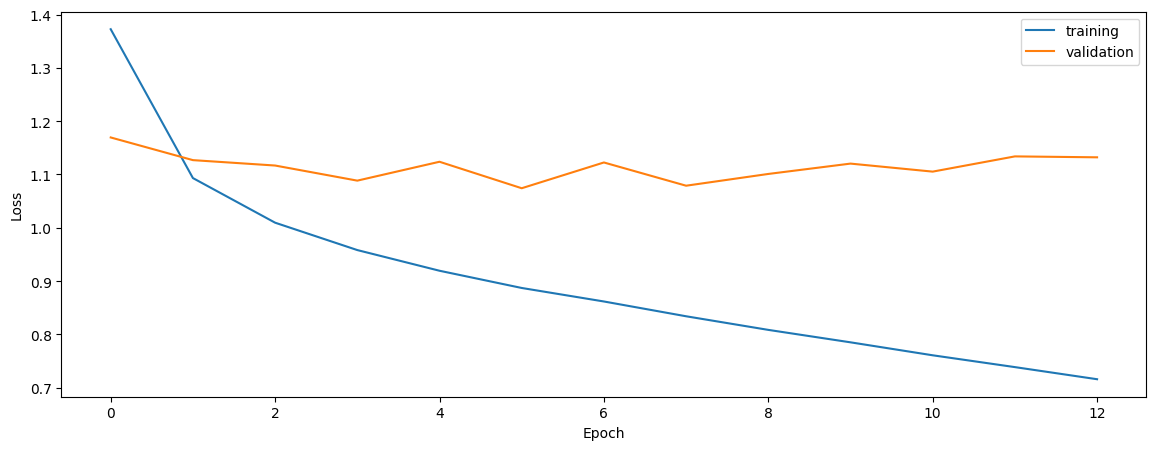

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_Sma

In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/107 [..............................] - ETA: 1:25 - loss: 0.2850 - STD: 1.8455e-04 - MAE: 0.5040

  4/107 [>.............................] - ETA: 2s - loss: 0.2466 - STD: 4.1864e-04 - MAE: 0.4469  

  5/107 [>.............................] - ETA: 23s - loss: 0.2445 - STD: 4.1734e-04 - MAE: 0.4400

  8/107 [=>............................] - ETA: 14s - loss: 0.2359 - STD: 5.0933e-04 - MAE: 0.4389

 11/107 [==>...........................] - ETA: 10s - loss: 0.2329 - STD: 6.2907e-04 - MAE: 0.4459

 14/107 [==>...........................] - ETA: 8s - loss: 0.2300 - STD: 7.3915e-04 - MAE: 0.4476 

 17/107 [===>..........................] - ETA: 6s - loss: 0.2281 - STD: 8.3264e-04 - MAE: 0.4454

 20/107 [====>.........................] - ETA: 5s - loss: 0.2269 - STD: 9.2908e-04 - MAE: 0.4434

 23/107 [=====>........................] - ETA: 5s - loss: 0.2257 - STD: 0.0010 - MAE: 0.4433    

 26/107 [======>.......................] - ETA: 4s - loss: 0.2248 - STD: 0.0012 - MAE: 0.4444

 29/107 [=======>......................] - ETA: 4s - loss: 0.2240 - STD: 0.0013 - MAE: 0.4448

 32/107 [=======>......................] - ETA: 3s - loss: 0.2234 - STD: 0.0015 - MAE: 0.4446

 35/107 [========>.....................] - ETA: 3s - loss: 0.2229 - STD: 0.0017 - MAE: 0.4441

 38/107 [=========>....................] - ETA: 3s - loss: 0.2224 - STD: 0.0020 - MAE: 0.4442

 41/107 [==========>...................] - ETA: 2s - loss: 0.2219 - STD: 0.0023 - MAE: 0.4443

 44/107 [===========>..................] - ETA: 2s - loss: 0.2215 - STD: 0.0028 - MAE: 0.4442

 47/107 [============>.................] - ETA: 2s - loss: 0.2210 - STD: 0.0033 - MAE: 0.4439

 50/107 [=============>................] - ETA: 2s - loss: 0.2205 - STD: 0.0040 - MAE: 0.4433

 53/107 [=============>................] - ETA: 2s - loss: 0.2200 - STD: 0.0050 - MAE: 0.4431

 56/107 [==============>...............] - ETA: 1s - loss: 0.2195 - STD: 0.0063 - MAE: 0.4427

 59/107 [===============>..............] - ETA: 1s - loss: 0.2190 - STD: 0.0081 - MAE: 0.4421

 62/107 [================>.............] - ETA: 1s - loss: 0.2183 - STD: 0.0105 - MAE: 0.4414

 65/107 [=================>............] - ETA: 1s - loss: 0.2175 - STD: 0.0138 - MAE: 0.4404

 68/107 [==================>...........] - ETA: 1s - loss: 0.2167 - STD: 0.0177 - MAE: 0.4390

 71/107 [==================>...........] - ETA: 1s - loss: 0.2158 - STD: 0.0221 - MAE: 0.4376

 74/107 [===================>..........] - ETA: 1s - loss: 0.2150 - STD: 0.0265 - MAE: 0.4360

 77/107 [====================>.........] - ETA: 1s - loss: 0.2141 - STD: 0.0306 - MAE: 0.4346

 80/107 [=====================>........] - ETA: 0s - loss: 0.2133 - STD: 0.0345 - MAE: 0.4332

 83/107 [======================>.......] - ETA: 0s - loss: 0.2125 - STD: 0.0384 - MAE: 0.4319

 86/107 [=======================>......] - ETA: 0s - loss: 0.2117 - STD: 0.0425 - MAE: 0.4303

 89/107 [=======================>......] - ETA: 0s - loss: 0.2109 - STD: 0.0464 - MAE: 0.4288

 92/107 [========================>.....] - ETA: 0s - loss: 0.2101 - STD: 0.0501 - MAE: 0.4274

 95/107 [=========================>....] - ETA: 0s - loss: 0.2092 - STD: 0.0537 - MAE: 0.4260

 98/107 [==========================>...] - ETA: 0s - loss: 0.2084 - STD: 0.0571 - MAE: 0.4245

101/107 [===========================>..] - ETA: 0s - loss: 0.2074 - STD: 0.0608 - MAE: 0.4230

104/107 [============================>.] - ETA: 0s - loss: 0.2065 - STD: 0.0646 - MAE: 0.4212

107/107 [==============================] - ETA: 0s - loss: 0.2056 - STD: 0.0683 - MAE: 0.4196

107/107 [==============================] - 5s 37ms/step - loss: 0.2056 - STD: 0.0683 - MAE: 0.4196 - val_loss: 0.1674 - val_STD: 0.1685 - val_MAE: 0.3408


Epoch 2/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1719 - STD: 0.1995 - MAE: 0.3497

  4/107 [>.............................] - ETA: 2s - loss: 0.1709 - STD: 0.2099 - MAE: 0.3521

  7/107 [>.............................] - ETA: 2s - loss: 0.1713 - STD: 0.2133 - MAE: 0.3517

 10/107 [=>............................] - ETA: 2s - loss: 0.1716 - STD: 0.2146 - MAE: 0.3520

 13/107 [==>...........................] - ETA: 2s - loss: 0.1719 - STD: 0.2139 - MAE: 0.3527

 16/107 [===>..........................] - ETA: 2s - loss: 0.1718 - STD: 0.2112 - MAE: 0.3535

 19/107 [====>.........................] - ETA: 2s - loss: 0.1716 - STD: 0.2092 - MAE: 0.3544

 22/107 [=====>........................] - ETA: 1s - loss: 0.1715 - STD: 0.2076 - MAE: 0.3549

 25/107 [======>.......................] - ETA: 1s - loss: 0.1713 - STD: 0.2076 - MAE: 0.3548

 28/107 [======>.......................] - ETA: 1s - loss: 0.1711 - STD: 0.2079 - MAE: 0.3545

 31/107 [=======>......................] - ETA: 1s - loss: 0.1709 - STD: 0.2086 - MAE: 0.3541

 34/107 [========>.....................] - ETA: 1s - loss: 0.1708 - STD: 0.2092 - MAE: 0.3538

 37/107 [=========>....................] - ETA: 1s - loss: 0.1708 - STD: 0.2095 - MAE: 0.3537

 40/107 [==========>...................] - ETA: 1s - loss: 0.1705 - STD: 0.2098 - MAE: 0.3533

 43/107 [===========>..................] - ETA: 1s - loss: 0.1704 - STD: 0.2101 - MAE: 0.3531

 46/107 [===========>..................] - ETA: 1s - loss: 0.1705 - STD: 0.2105 - MAE: 0.3530

 49/107 [============>.................] - ETA: 1s - loss: 0.1705 - STD: 0.2104 - MAE: 0.3531

 52/107 [=============>................] - ETA: 1s - loss: 0.1704 - STD: 0.2105 - MAE: 0.3531

 55/107 [==============>...............] - ETA: 1s - loss: 0.1704 - STD: 0.2103 - MAE: 0.3531

 58/107 [===============>..............] - ETA: 1s - loss: 0.1704 - STD: 0.2103 - MAE: 0.3530

 61/107 [================>.............] - ETA: 1s - loss: 0.1703 - STD: 0.2104 - MAE: 0.3528

 64/107 [================>.............] - ETA: 0s - loss: 0.1703 - STD: 0.2106 - MAE: 0.3528

 67/107 [=================>............] - ETA: 0s - loss: 0.1703 - STD: 0.2109 - MAE: 0.3527

 70/107 [==================>...........] - ETA: 0s - loss: 0.1702 - STD: 0.2111 - MAE: 0.3525

 73/107 [===================>..........] - ETA: 0s - loss: 0.1701 - STD: 0.2112 - MAE: 0.3524

 76/107 [====================>.........] - ETA: 0s - loss: 0.1700 - STD: 0.2114 - MAE: 0.3522

 79/107 [=====================>........] - ETA: 0s - loss: 0.1699 - STD: 0.2117 - MAE: 0.3521

 82/107 [=====================>........] - ETA: 0s - loss: 0.1699 - STD: 0.2119 - MAE: 0.3519

 85/107 [======================>.......] - ETA: 0s - loss: 0.1698 - STD: 0.2121 - MAE: 0.3518

 88/107 [=======================>......] - ETA: 0s - loss: 0.1697 - STD: 0.2122 - MAE: 0.3517

 91/107 [========================>.....] - ETA: 0s - loss: 0.1696 - STD: 0.2125 - MAE: 0.3515

 94/107 [=========================>....] - ETA: 0s - loss: 0.1695 - STD: 0.2127 - MAE: 0.3513

 97/107 [==========================>...] - ETA: 0s - loss: 0.1695 - STD: 0.2130 - MAE: 0.3512

100/107 [===========================>..] - ETA: 0s - loss: 0.1695 - STD: 0.2132 - MAE: 0.3511

103/107 [===========================>..] - ETA: 0s - loss: 0.1695 - STD: 0.2131 - MAE: 0.3510

106/107 [============================>.] - ETA: 0s - loss: 0.1695 - STD: 0.2132 - MAE: 0.3511

107/107 [==============================] - 3s 25ms/step - loss: 0.1695 - STD: 0.2131 - MAE: 0.3511 - val_loss: 0.1597 - val_STD: 0.1904 - val_MAE: 0.3433


Epoch 3/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1699 - STD: 0.2217 - MAE: 0.3532

  4/107 [>.............................] - ETA: 2s - loss: 0.1682 - STD: 0.2140 - MAE: 0.3484

  7/107 [>.............................] - ETA: 2s - loss: 0.1689 - STD: 0.2151 - MAE: 0.3488

 10/107 [=>............................] - ETA: 2s - loss: 0.1693 - STD: 0.2162 - MAE: 0.3494

 13/107 [==>...........................] - ETA: 2s - loss: 0.1694 - STD: 0.2144 - MAE: 0.3494

 16/107 [===>..........................] - ETA: 2s - loss: 0.1695 - STD: 0.2133 - MAE: 0.3496

 19/107 [====>.........................] - ETA: 1s - loss: 0.1693 - STD: 0.2141 - MAE: 0.3497

 22/107 [=====>........................] - ETA: 1s - loss: 0.1688 - STD: 0.2144 - MAE: 0.3491

 25/107 [======>.......................] - ETA: 1s - loss: 0.1687 - STD: 0.2151 - MAE: 0.3488

 28/107 [======>.......................] - ETA: 1s - loss: 0.1686 - STD: 0.2157 - MAE: 0.3485

 31/107 [=======>......................] - ETA: 1s - loss: 0.1684 - STD: 0.2162 - MAE: 0.3483

 34/107 [========>.....................] - ETA: 1s - loss: 0.1683 - STD: 0.2164 - MAE: 0.3482

 37/107 [=========>....................] - ETA: 1s - loss: 0.1681 - STD: 0.2167 - MAE: 0.3480

 40/107 [==========>...................] - ETA: 1s - loss: 0.1681 - STD: 0.2172 - MAE: 0.3479

 43/107 [===========>..................] - ETA: 1s - loss: 0.1679 - STD: 0.2176 - MAE: 0.3476

 46/107 [===========>..................] - ETA: 1s - loss: 0.1679 - STD: 0.2180 - MAE: 0.3474

 49/107 [============>.................] - ETA: 1s - loss: 0.1678 - STD: 0.2183 - MAE: 0.3472

 52/107 [=============>................] - ETA: 1s - loss: 0.1678 - STD: 0.2185 - MAE: 0.3472

 55/107 [==============>...............] - ETA: 1s - loss: 0.1677 - STD: 0.2183 - MAE: 0.3471

 58/107 [===============>..............] - ETA: 1s - loss: 0.1676 - STD: 0.2183 - MAE: 0.3471

 61/107 [================>.............] - ETA: 1s - loss: 0.1675 - STD: 0.2184 - MAE: 0.3471

 64/107 [================>.............] - ETA: 0s - loss: 0.1675 - STD: 0.2186 - MAE: 0.3469

 67/107 [=================>............] - ETA: 0s - loss: 0.1674 - STD: 0.2188 - MAE: 0.3468

 70/107 [==================>...........] - ETA: 0s - loss: 0.1675 - STD: 0.2189 - MAE: 0.3468

 73/107 [===================>..........] - ETA: 0s - loss: 0.1674 - STD: 0.2189 - MAE: 0.3467

 76/107 [====================>.........] - ETA: 0s - loss: 0.1673 - STD: 0.2190 - MAE: 0.3466

 79/107 [=====================>........] - ETA: 0s - loss: 0.1673 - STD: 0.2191 - MAE: 0.3465

 82/107 [=====================>........] - ETA: 0s - loss: 0.1673 - STD: 0.2194 - MAE: 0.3464

 85/107 [======================>.......] - ETA: 0s - loss: 0.1671 - STD: 0.2196 - MAE: 0.3463

 88/107 [=======================>......] - ETA: 0s - loss: 0.1671 - STD: 0.2198 - MAE: 0.3462

 91/107 [========================>.....] - ETA: 0s - loss: 0.1670 - STD: 0.2199 - MAE: 0.3460

 94/107 [=========================>....] - ETA: 0s - loss: 0.1670 - STD: 0.2200 - MAE: 0.3460

 97/107 [==========================>...] - ETA: 0s - loss: 0.1670 - STD: 0.2202 - MAE: 0.3459

100/107 [===========================>..] - ETA: 0s - loss: 0.1669 - STD: 0.2204 - MAE: 0.3458

103/107 [===========================>..] - ETA: 0s - loss: 0.1668 - STD: 0.2205 - MAE: 0.3456

106/107 [============================>.] - ETA: 0s - loss: 0.1668 - STD: 0.2206 - MAE: 0.3455

107/107 [==============================] - 3s 25ms/step - loss: 0.1668 - STD: 0.2206 - MAE: 0.3455 - val_loss: 0.1561 - val_STD: 0.1946 - val_MAE: 0.3355


Epoch 4/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1643 - STD: 0.2268 - MAE: 0.3446

  4/107 [>.............................] - ETA: 2s - loss: 0.1648 - STD: 0.2217 - MAE: 0.3426

  7/107 [>.............................] - ETA: 2s - loss: 0.1650 - STD: 0.2230 - MAE: 0.3424

 10/107 [=>............................] - ETA: 2s - loss: 0.1653 - STD: 0.2235 - MAE: 0.3427

 13/107 [==>...........................] - ETA: 2s - loss: 0.1656 - STD: 0.2239 - MAE: 0.3428

 16/107 [===>..........................] - ETA: 2s - loss: 0.1655 - STD: 0.2245 - MAE: 0.3426

 19/107 [====>.........................] - ETA: 1s - loss: 0.1654 - STD: 0.2247 - MAE: 0.3426

 22/107 [=====>........................] - ETA: 1s - loss: 0.1655 - STD: 0.2248 - MAE: 0.3427

 25/107 [======>.......................] - ETA: 1s - loss: 0.1659 - STD: 0.2244 - MAE: 0.3431

 28/107 [======>.......................] - ETA: 1s - loss: 0.1658 - STD: 0.2239 - MAE: 0.3431

 31/107 [=======>......................] - ETA: 1s - loss: 0.1660 - STD: 0.2233 - MAE: 0.3433

 34/107 [========>.....................] - ETA: 1s - loss: 0.1659 - STD: 0.2231 - MAE: 0.3434

 37/107 [=========>....................] - ETA: 1s - loss: 0.1660 - STD: 0.2232 - MAE: 0.3434

 40/107 [==========>...................] - ETA: 1s - loss: 0.1659 - STD: 0.2234 - MAE: 0.3433

 43/107 [===========>..................] - ETA: 1s - loss: 0.1657 - STD: 0.2236 - MAE: 0.3431

 46/107 [===========>..................] - ETA: 1s - loss: 0.1657 - STD: 0.2237 - MAE: 0.3431

 49/107 [============>.................] - ETA: 1s - loss: 0.1656 - STD: 0.2239 - MAE: 0.3429

 52/107 [=============>................] - ETA: 1s - loss: 0.1656 - STD: 0.2240 - MAE: 0.3428

 55/107 [==============>...............] - ETA: 1s - loss: 0.1655 - STD: 0.2241 - MAE: 0.3427

 58/107 [===============>..............] - ETA: 1s - loss: 0.1655 - STD: 0.2243 - MAE: 0.3427

 61/107 [================>.............] - ETA: 1s - loss: 0.1654 - STD: 0.2244 - MAE: 0.3425

 64/107 [================>.............] - ETA: 0s - loss: 0.1653 - STD: 0.2246 - MAE: 0.3424

 67/107 [=================>............] - ETA: 0s - loss: 0.1652 - STD: 0.2247 - MAE: 0.3422

 70/107 [==================>...........] - ETA: 0s - loss: 0.1651 - STD: 0.2248 - MAE: 0.3421

 73/107 [===================>..........] - ETA: 0s - loss: 0.1651 - STD: 0.2250 - MAE: 0.3421

 76/107 [====================>.........] - ETA: 0s - loss: 0.1651 - STD: 0.2251 - MAE: 0.3420

 79/107 [=====================>........] - ETA: 0s - loss: 0.1650 - STD: 0.2253 - MAE: 0.3420

 82/107 [=====================>........] - ETA: 0s - loss: 0.1650 - STD: 0.2255 - MAE: 0.3418

 85/107 [======================>.......] - ETA: 0s - loss: 0.1649 - STD: 0.2257 - MAE: 0.3417

 88/107 [=======================>......] - ETA: 0s - loss: 0.1650 - STD: 0.2257 - MAE: 0.3417

 91/107 [========================>.....] - ETA: 0s - loss: 0.1650 - STD: 0.2255 - MAE: 0.3418

 94/107 [=========================>....] - ETA: 0s - loss: 0.1651 - STD: 0.2254 - MAE: 0.3419

 97/107 [==========================>...] - ETA: 0s - loss: 0.1652 - STD: 0.2255 - MAE: 0.3419

100/107 [===========================>..] - ETA: 0s - loss: 0.1653 - STD: 0.2254 - MAE: 0.3420

103/107 [===========================>..] - ETA: 0s - loss: 0.1653 - STD: 0.2251 - MAE: 0.3419

106/107 [============================>.] - ETA: 0s - loss: 0.1654 - STD: 0.2248 - MAE: 0.3421

107/107 [==============================] - 3s 25ms/step - loss: 0.1653 - STD: 0.2247 - MAE: 0.3421 - val_loss: 0.1562 - val_STD: 0.1919 - val_MAE: 0.3387


Epoch 5/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1657 - STD: 0.2219 - MAE: 0.3485

  4/107 [>.............................] - ETA: 2s - loss: 0.1634 - STD: 0.2211 - MAE: 0.3426

  7/107 [>.............................] - ETA: 2s - loss: 0.1636 - STD: 0.2242 - MAE: 0.3413

 10/107 [=>............................] - ETA: 2s - loss: 0.1639 - STD: 0.2275 - MAE: 0.3405

 13/107 [==>...........................] - ETA: 2s - loss: 0.1637 - STD: 0.2285 - MAE: 0.3396

 16/107 [===>..........................] - ETA: 2s - loss: 0.1634 - STD: 0.2292 - MAE: 0.3390

 19/107 [====>.........................] - ETA: 1s - loss: 0.1634 - STD: 0.2290 - MAE: 0.3390

 22/107 [=====>........................] - ETA: 1s - loss: 0.1633 - STD: 0.2288 - MAE: 0.3389

 25/107 [======>.......................] - ETA: 1s - loss: 0.1635 - STD: 0.2286 - MAE: 0.3392

 28/107 [======>.......................] - ETA: 1s - loss: 0.1636 - STD: 0.2284 - MAE: 0.3395

 31/107 [=======>......................] - ETA: 1s - loss: 0.1636 - STD: 0.2282 - MAE: 0.3396

 34/107 [========>.....................] - ETA: 1s - loss: 0.1635 - STD: 0.2279 - MAE: 0.3395

 37/107 [=========>....................] - ETA: 1s - loss: 0.1635 - STD: 0.2277 - MAE: 0.3396

 40/107 [==========>...................] - ETA: 1s - loss: 0.1635 - STD: 0.2279 - MAE: 0.3395

 43/107 [===========>..................] - ETA: 1s - loss: 0.1634 - STD: 0.2282 - MAE: 0.3392

 46/107 [===========>..................] - ETA: 1s - loss: 0.1633 - STD: 0.2286 - MAE: 0.3390

 49/107 [============>.................] - ETA: 1s - loss: 0.1634 - STD: 0.2290 - MAE: 0.3390

 52/107 [=============>................] - ETA: 1s - loss: 0.1633 - STD: 0.2290 - MAE: 0.3389

 55/107 [==============>...............] - ETA: 1s - loss: 0.1633 - STD: 0.2289 - MAE: 0.3390

 58/107 [===============>..............] - ETA: 1s - loss: 0.1633 - STD: 0.2287 - MAE: 0.3390

 61/107 [================>.............] - ETA: 1s - loss: 0.1633 - STD: 0.2289 - MAE: 0.3389

 64/107 [================>.............] - ETA: 0s - loss: 0.1632 - STD: 0.2291 - MAE: 0.3388

 67/107 [=================>............] - ETA: 0s - loss: 0.1633 - STD: 0.2292 - MAE: 0.3389

 70/107 [==================>...........] - ETA: 0s - loss: 0.1633 - STD: 0.2291 - MAE: 0.3388

 73/107 [===================>..........] - ETA: 0s - loss: 0.1633 - STD: 0.2292 - MAE: 0.3388

 76/107 [====================>.........] - ETA: 0s - loss: 0.1633 - STD: 0.2291 - MAE: 0.3388

 79/107 [=====================>........] - ETA: 0s - loss: 0.1633 - STD: 0.2292 - MAE: 0.3388

 82/107 [=====================>........] - ETA: 0s - loss: 0.1633 - STD: 0.2292 - MAE: 0.3387

 85/107 [======================>.......] - ETA: 0s - loss: 0.1633 - STD: 0.2293 - MAE: 0.3387

 88/107 [=======================>......] - ETA: 0s - loss: 0.1632 - STD: 0.2293 - MAE: 0.3386

 91/107 [========================>.....] - ETA: 0s - loss: 0.1632 - STD: 0.2293 - MAE: 0.3385

 94/107 [=========================>....] - ETA: 0s - loss: 0.1631 - STD: 0.2294 - MAE: 0.3385

 97/107 [==========================>...] - ETA: 0s - loss: 0.1630 - STD: 0.2295 - MAE: 0.3383

100/107 [===========================>..] - ETA: 0s - loss: 0.1630 - STD: 0.2297 - MAE: 0.3382

103/107 [===========================>..] - ETA: 0s - loss: 0.1630 - STD: 0.2299 - MAE: 0.3381

106/107 [============================>.] - ETA: 0s - loss: 0.1631 - STD: 0.2299 - MAE: 0.3381

107/107 [==============================] - 3s 25ms/step - loss: 0.1631 - STD: 0.2298 - MAE: 0.3381 - val_loss: 0.1583 - val_STD: 0.1869 - val_MAE: 0.3236


Epoch 6/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1653 - STD: 0.2261 - MAE: 0.3340

  4/107 [>.............................] - ETA: 2s - loss: 0.1657 - STD: 0.2285 - MAE: 0.3384

  7/107 [>.............................] - ETA: 2s - loss: 0.1648 - STD: 0.2273 - MAE: 0.3397

 10/107 [=>............................] - ETA: 2s - loss: 0.1643 - STD: 0.2248 - MAE: 0.3407

 13/107 [==>...........................] - ETA: 2s - loss: 0.1637 - STD: 0.2238 - MAE: 0.3405

 16/107 [===>..........................] - ETA: 2s - loss: 0.1632 - STD: 0.2249 - MAE: 0.3395

 19/107 [====>.........................] - ETA: 1s - loss: 0.1630 - STD: 0.2270 - MAE: 0.3385

 22/107 [=====>........................] - ETA: 1s - loss: 0.1628 - STD: 0.2288 - MAE: 0.3378

 25/107 [======>.......................] - ETA: 1s - loss: 0.1628 - STD: 0.2295 - MAE: 0.3377

 28/107 [======>.......................] - ETA: 1s - loss: 0.1627 - STD: 0.2297 - MAE: 0.3375

 31/107 [=======>......................] - ETA: 1s - loss: 0.1627 - STD: 0.2299 - MAE: 0.3373

 34/107 [========>.....................] - ETA: 1s - loss: 0.1625 - STD: 0.2302 - MAE: 0.3369

 37/107 [=========>....................] - ETA: 1s - loss: 0.1625 - STD: 0.2303 - MAE: 0.3369

 40/107 [==========>...................] - ETA: 1s - loss: 0.1624 - STD: 0.2301 - MAE: 0.3369

 43/107 [===========>..................] - ETA: 1s - loss: 0.1622 - STD: 0.2300 - MAE: 0.3369

 46/107 [===========>..................] - ETA: 1s - loss: 0.1622 - STD: 0.2303 - MAE: 0.3368

 49/107 [============>.................] - ETA: 1s - loss: 0.1622 - STD: 0.2307 - MAE: 0.3366

 52/107 [=============>................] - ETA: 1s - loss: 0.1622 - STD: 0.2311 - MAE: 0.3364

 55/107 [==============>...............] - ETA: 1s - loss: 0.1621 - STD: 0.2312 - MAE: 0.3363

 58/107 [===============>..............] - ETA: 1s - loss: 0.1621 - STD: 0.2312 - MAE: 0.3363

 61/107 [================>.............] - ETA: 1s - loss: 0.1621 - STD: 0.2313 - MAE: 0.3364

 64/107 [================>.............] - ETA: 0s - loss: 0.1620 - STD: 0.2315 - MAE: 0.3362

 67/107 [=================>............] - ETA: 0s - loss: 0.1620 - STD: 0.2315 - MAE: 0.3361

 70/107 [==================>...........] - ETA: 0s - loss: 0.1619 - STD: 0.2316 - MAE: 0.3360

 73/107 [===================>..........] - ETA: 0s - loss: 0.1619 - STD: 0.2318 - MAE: 0.3359

 76/107 [====================>.........] - ETA: 0s - loss: 0.1618 - STD: 0.2320 - MAE: 0.3358

 79/107 [=====================>........] - ETA: 0s - loss: 0.1618 - STD: 0.2320 - MAE: 0.3357

 82/107 [=====================>........] - ETA: 0s - loss: 0.1618 - STD: 0.2321 - MAE: 0.3357

 85/107 [======================>.......] - ETA: 0s - loss: 0.1618 - STD: 0.2321 - MAE: 0.3357

 88/107 [=======================>......] - ETA: 0s - loss: 0.1617 - STD: 0.2321 - MAE: 0.3356

 91/107 [========================>.....] - ETA: 0s - loss: 0.1617 - STD: 0.2321 - MAE: 0.3355

 94/107 [=========================>....] - ETA: 0s - loss: 0.1616 - STD: 0.2322 - MAE: 0.3354

 97/107 [==========================>...] - ETA: 0s - loss: 0.1617 - STD: 0.2323 - MAE: 0.3354

100/107 [===========================>..] - ETA: 0s - loss: 0.1617 - STD: 0.2322 - MAE: 0.3354

103/107 [===========================>..] - ETA: 0s - loss: 0.1617 - STD: 0.2323 - MAE: 0.3353

106/107 [============================>.] - ETA: 0s - loss: 0.1617 - STD: 0.2324 - MAE: 0.3353

107/107 [==============================] - 3s 25ms/step - loss: 0.1617 - STD: 0.2324 - MAE: 0.3354 - val_loss: 0.1520 - val_STD: 0.1945 - val_MAE: 0.3249


Epoch 7/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1621 - STD: 0.2268 - MAE: 0.3374

  4/107 [>.............................] - ETA: 2s - loss: 0.1605 - STD: 0.2262 - MAE: 0.3362

  7/107 [>.............................] - ETA: 2s - loss: 0.1602 - STD: 0.2280 - MAE: 0.3355

 10/107 [=>............................] - ETA: 2s - loss: 0.1604 - STD: 0.2306 - MAE: 0.3347

 13/107 [==>...........................] - ETA: 2s - loss: 0.1602 - STD: 0.2327 - MAE: 0.3335

 16/107 [===>..........................] - ETA: 2s - loss: 0.1603 - STD: 0.2334 - MAE: 0.3335

 19/107 [====>.........................] - ETA: 2s - loss: 0.1604 - STD: 0.2335 - MAE: 0.3336

 22/107 [=====>........................] - ETA: 1s - loss: 0.1605 - STD: 0.2337 - MAE: 0.3337

 25/107 [======>.......................] - ETA: 1s - loss: 0.1604 - STD: 0.2338 - MAE: 0.3336

 28/107 [======>.......................] - ETA: 1s - loss: 0.1604 - STD: 0.2334 - MAE: 0.3337

 31/107 [=======>......................] - ETA: 1s - loss: 0.1602 - STD: 0.2336 - MAE: 0.3335

 34/107 [========>.....................] - ETA: 1s - loss: 0.1602 - STD: 0.2340 - MAE: 0.3332

 37/107 [=========>....................] - ETA: 1s - loss: 0.1603 - STD: 0.2343 - MAE: 0.3331

 40/107 [==========>...................] - ETA: 1s - loss: 0.1607 - STD: 0.2340 - MAE: 0.3333

 43/107 [===========>..................] - ETA: 1s - loss: 0.1611 - STD: 0.2337 - MAE: 0.3335

 46/107 [===========>..................] - ETA: 1s - loss: 0.1613 - STD: 0.2334 - MAE: 0.3337

 49/107 [============>.................] - ETA: 1s - loss: 0.1613 - STD: 0.2330 - MAE: 0.3340

 52/107 [=============>................] - ETA: 1s - loss: 0.1613 - STD: 0.2326 - MAE: 0.3343

 55/107 [==============>...............] - ETA: 1s - loss: 0.1613 - STD: 0.2325 - MAE: 0.3343

 58/107 [===============>..............] - ETA: 1s - loss: 0.1614 - STD: 0.2326 - MAE: 0.3343

 61/107 [================>.............] - ETA: 1s - loss: 0.1614 - STD: 0.2327 - MAE: 0.3342

 64/107 [================>.............] - ETA: 0s - loss: 0.1613 - STD: 0.2328 - MAE: 0.3341

 67/107 [=================>............] - ETA: 0s - loss: 0.1612 - STD: 0.2329 - MAE: 0.3340

 70/107 [==================>...........] - ETA: 0s - loss: 0.1610 - STD: 0.2330 - MAE: 0.3339

 73/107 [===================>..........] - ETA: 0s - loss: 0.1610 - STD: 0.2331 - MAE: 0.3338

 76/107 [====================>.........] - ETA: 0s - loss: 0.1610 - STD: 0.2333 - MAE: 0.3337

 79/107 [=====================>........] - ETA: 0s - loss: 0.1610 - STD: 0.2334 - MAE: 0.3337

 82/107 [=====================>........] - ETA: 0s - loss: 0.1610 - STD: 0.2334 - MAE: 0.3337

 85/107 [======================>.......] - ETA: 0s - loss: 0.1609 - STD: 0.2336 - MAE: 0.3335

 88/107 [=======================>......] - ETA: 0s - loss: 0.1608 - STD: 0.2338 - MAE: 0.3334

 91/107 [========================>.....] - ETA: 0s - loss: 0.1608 - STD: 0.2340 - MAE: 0.3333

 94/107 [=========================>....] - ETA: 0s - loss: 0.1608 - STD: 0.2340 - MAE: 0.3333

 97/107 [==========================>...] - ETA: 0s - loss: 0.1608 - STD: 0.2340 - MAE: 0.3333

100/107 [===========================>..] - ETA: 0s - loss: 0.1607 - STD: 0.2341 - MAE: 0.3331

103/107 [===========================>..] - ETA: 0s - loss: 0.1607 - STD: 0.2343 - MAE: 0.3330

106/107 [============================>.] - ETA: 0s - loss: 0.1606 - STD: 0.2343 - MAE: 0.3330

107/107 [==============================] - 3s 25ms/step - loss: 0.1606 - STD: 0.2344 - MAE: 0.3330 - val_loss: 0.1516 - val_STD: 0.1966 - val_MAE: 0.3189


Epoch 8/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1619 - STD: 0.2344 - MAE: 0.3322

  4/107 [>.............................] - ETA: 2s - loss: 0.1595 - STD: 0.2372 - MAE: 0.3308

  7/107 [>.............................] - ETA: 2s - loss: 0.1596 - STD: 0.2377 - MAE: 0.3306

 10/107 [=>............................] - ETA: 2s - loss: 0.1593 - STD: 0.2378 - MAE: 0.3308

 13/107 [==>...........................] - ETA: 2s - loss: 0.1595 - STD: 0.2362 - MAE: 0.3313

 16/107 [===>..........................] - ETA: 2s - loss: 0.1586 - STD: 0.2373 - MAE: 0.3301

 19/107 [====>.........................] - ETA: 1s - loss: 0.1589 - STD: 0.2389 - MAE: 0.3297

 22/107 [=====>........................] - ETA: 1s - loss: 0.1587 - STD: 0.2384 - MAE: 0.3295

 25/107 [======>.......................] - ETA: 1s - loss: 0.1590 - STD: 0.2378 - MAE: 0.3299

 28/107 [======>.......................] - ETA: 1s - loss: 0.1593 - STD: 0.2378 - MAE: 0.3302

 31/107 [=======>......................] - ETA: 1s - loss: 0.1592 - STD: 0.2377 - MAE: 0.3303

 34/107 [========>.....................] - ETA: 1s - loss: 0.1590 - STD: 0.2375 - MAE: 0.3303

 37/107 [=========>....................] - ETA: 1s - loss: 0.1590 - STD: 0.2376 - MAE: 0.3301

 40/107 [==========>...................] - ETA: 1s - loss: 0.1589 - STD: 0.2380 - MAE: 0.3300

 43/107 [===========>..................] - ETA: 1s - loss: 0.1588 - STD: 0.2380 - MAE: 0.3299

 46/107 [===========>..................] - ETA: 1s - loss: 0.1588 - STD: 0.2381 - MAE: 0.3299

 49/107 [============>.................] - ETA: 1s - loss: 0.1587 - STD: 0.2383 - MAE: 0.3297

 52/107 [=============>................] - ETA: 1s - loss: 0.1586 - STD: 0.2385 - MAE: 0.3296

 55/107 [==============>...............] - ETA: 1s - loss: 0.1586 - STD: 0.2386 - MAE: 0.3295

 58/107 [===============>..............] - ETA: 1s - loss: 0.1586 - STD: 0.2386 - MAE: 0.3295

 61/107 [================>.............] - ETA: 1s - loss: 0.1586 - STD: 0.2389 - MAE: 0.3294

 64/107 [================>.............] - ETA: 0s - loss: 0.1586 - STD: 0.2390 - MAE: 0.3293

 67/107 [=================>............] - ETA: 0s - loss: 0.1588 - STD: 0.2388 - MAE: 0.3294

 70/107 [==================>...........] - ETA: 0s - loss: 0.1590 - STD: 0.2384 - MAE: 0.3295

 73/107 [===================>..........] - ETA: 0s - loss: 0.1592 - STD: 0.2384 - MAE: 0.3297

 76/107 [====================>.........] - ETA: 0s - loss: 0.1593 - STD: 0.2381 - MAE: 0.3298

 79/107 [=====================>........] - ETA: 0s - loss: 0.1593 - STD: 0.2379 - MAE: 0.3300

 82/107 [=====================>........] - ETA: 0s - loss: 0.1594 - STD: 0.2378 - MAE: 0.3302

 85/107 [======================>.......] - ETA: 0s - loss: 0.1595 - STD: 0.2376 - MAE: 0.3303

 88/107 [=======================>......] - ETA: 0s - loss: 0.1594 - STD: 0.2374 - MAE: 0.3303

 91/107 [========================>.....] - ETA: 0s - loss: 0.1593 - STD: 0.2373 - MAE: 0.3303

 94/107 [=========================>....] - ETA: 0s - loss: 0.1593 - STD: 0.2373 - MAE: 0.3303

 97/107 [==========================>...] - ETA: 0s - loss: 0.1593 - STD: 0.2373 - MAE: 0.3303

100/107 [===========================>..] - ETA: 0s - loss: 0.1593 - STD: 0.2373 - MAE: 0.3303

103/107 [===========================>..] - ETA: 0s - loss: 0.1592 - STD: 0.2374 - MAE: 0.3302

106/107 [============================>.] - ETA: 0s - loss: 0.1591 - STD: 0.2376 - MAE: 0.3301

107/107 [==============================] - 3s 25ms/step - loss: 0.1591 - STD: 0.2376 - MAE: 0.3300 - val_loss: 0.1486 - val_STD: 0.2065 - val_MAE: 0.3177


Epoch 9/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1587 - STD: 0.2404 - MAE: 0.3307

  4/107 [>.............................] - ETA: 2s - loss: 0.1573 - STD: 0.2436 - MAE: 0.3277

  7/107 [>.............................] - ETA: 2s - loss: 0.1586 - STD: 0.2425 - MAE: 0.3283

 10/107 [=>............................] - ETA: 2s - loss: 0.1592 - STD: 0.2410 - MAE: 0.3288

 13/107 [==>...........................] - ETA: 2s - loss: 0.1591 - STD: 0.2400 - MAE: 0.3286

 16/107 [===>..........................] - ETA: 2s - loss: 0.1591 - STD: 0.2405 - MAE: 0.3280

 19/107 [====>.........................] - ETA: 1s - loss: 0.1589 - STD: 0.2397 - MAE: 0.3282

 22/107 [=====>........................] - ETA: 1s - loss: 0.1587 - STD: 0.2393 - MAE: 0.3283

 25/107 [======>.......................] - ETA: 1s - loss: 0.1585 - STD: 0.2396 - MAE: 0.3281

 28/107 [======>.......................] - ETA: 1s - loss: 0.1586 - STD: 0.2398 - MAE: 0.3282

 31/107 [=======>......................] - ETA: 1s - loss: 0.1584 - STD: 0.2394 - MAE: 0.3283

 34/107 [========>.....................] - ETA: 1s - loss: 0.1585 - STD: 0.2394 - MAE: 0.3284

 37/107 [=========>....................] - ETA: 1s - loss: 0.1585 - STD: 0.2400 - MAE: 0.3281

 40/107 [==========>...................] - ETA: 1s - loss: 0.1586 - STD: 0.2400 - MAE: 0.3282

 43/107 [===========>..................] - ETA: 1s - loss: 0.1587 - STD: 0.2395 - MAE: 0.3286

 46/107 [===========>..................] - ETA: 1s - loss: 0.1587 - STD: 0.2396 - MAE: 0.3286

 49/107 [============>.................] - ETA: 1s - loss: 0.1589 - STD: 0.2398 - MAE: 0.3287

 52/107 [=============>................] - ETA: 1s - loss: 0.1589 - STD: 0.2397 - MAE: 0.3287

 55/107 [==============>...............] - ETA: 1s - loss: 0.1588 - STD: 0.2394 - MAE: 0.3287

 58/107 [===============>..............] - ETA: 1s - loss: 0.1587 - STD: 0.2393 - MAE: 0.3286

 61/107 [================>.............] - ETA: 1s - loss: 0.1586 - STD: 0.2395 - MAE: 0.3284

 64/107 [================>.............] - ETA: 0s - loss: 0.1586 - STD: 0.2398 - MAE: 0.3283

 67/107 [=================>............] - ETA: 0s - loss: 0.1586 - STD: 0.2398 - MAE: 0.3283

 70/107 [==================>...........] - ETA: 0s - loss: 0.1585 - STD: 0.2396 - MAE: 0.3284

 73/107 [===================>..........] - ETA: 0s - loss: 0.1585 - STD: 0.2396 - MAE: 0.3283

 76/107 [====================>.........] - ETA: 0s - loss: 0.1585 - STD: 0.2399 - MAE: 0.3282

 79/107 [=====================>........] - ETA: 0s - loss: 0.1584 - STD: 0.2399 - MAE: 0.3281

 82/107 [=====================>........] - ETA: 0s - loss: 0.1582 - STD: 0.2398 - MAE: 0.3280

 85/107 [======================>.......] - ETA: 0s - loss: 0.1582 - STD: 0.2400 - MAE: 0.3279

 88/107 [=======================>......] - ETA: 0s - loss: 0.1582 - STD: 0.2401 - MAE: 0.3279

 91/107 [========================>.....] - ETA: 0s - loss: 0.1581 - STD: 0.2401 - MAE: 0.3278

 94/107 [=========================>....] - ETA: 0s - loss: 0.1580 - STD: 0.2402 - MAE: 0.3277

 97/107 [==========================>...] - ETA: 0s - loss: 0.1580 - STD: 0.2403 - MAE: 0.3277

100/107 [===========================>..] - ETA: 0s - loss: 0.1579 - STD: 0.2405 - MAE: 0.3276

103/107 [===========================>..] - ETA: 0s - loss: 0.1579 - STD: 0.2407 - MAE: 0.3274

106/107 [============================>.] - ETA: 0s - loss: 0.1578 - STD: 0.2408 - MAE: 0.3273

107/107 [==============================] - 3s 25ms/step - loss: 0.1578 - STD: 0.2409 - MAE: 0.3274 - val_loss: 0.1479 - val_STD: 0.2069 - val_MAE: 0.3167


Epoch 10/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1529 - STD: 0.2440 - MAE: 0.3222

  4/107 [>.............................] - ETA: 2s - loss: 0.1570 - STD: 0.2391 - MAE: 0.3272

  7/107 [>.............................] - ETA: 2s - loss: 0.1568 - STD: 0.2423 - MAE: 0.3263

 10/107 [=>............................] - ETA: 2s - loss: 0.1566 - STD: 0.2432 - MAE: 0.3257

 13/107 [==>...........................] - ETA: 2s - loss: 0.1569 - STD: 0.2425 - MAE: 0.3263

 16/107 [===>..........................] - ETA: 2s - loss: 0.1572 - STD: 0.2427 - MAE: 0.3261

 19/107 [====>.........................] - ETA: 1s - loss: 0.1575 - STD: 0.2418 - MAE: 0.3265

 22/107 [=====>........................] - ETA: 1s - loss: 0.1578 - STD: 0.2412 - MAE: 0.3272

 25/107 [======>.......................] - ETA: 1s - loss: 0.1580 - STD: 0.2413 - MAE: 0.3269

 28/107 [======>.......................] - ETA: 1s - loss: 0.1582 - STD: 0.2412 - MAE: 0.3268

 31/107 [=======>......................] - ETA: 1s - loss: 0.1581 - STD: 0.2406 - MAE: 0.3269

 34/107 [========>.....................] - ETA: 1s - loss: 0.1578 - STD: 0.2405 - MAE: 0.3267

 37/107 [=========>....................] - ETA: 1s - loss: 0.1577 - STD: 0.2410 - MAE: 0.3265

 40/107 [==========>...................] - ETA: 1s - loss: 0.1576 - STD: 0.2410 - MAE: 0.3263

 43/107 [===========>..................] - ETA: 1s - loss: 0.1574 - STD: 0.2411 - MAE: 0.3263

 46/107 [===========>..................] - ETA: 1s - loss: 0.1574 - STD: 0.2414 - MAE: 0.3262

 49/107 [============>.................] - ETA: 1s - loss: 0.1573 - STD: 0.2416 - MAE: 0.3261

 52/107 [=============>................] - ETA: 1s - loss: 0.1573 - STD: 0.2416 - MAE: 0.3262

 55/107 [==============>...............] - ETA: 1s - loss: 0.1573 - STD: 0.2416 - MAE: 0.3262

 58/107 [===============>..............] - ETA: 1s - loss: 0.1573 - STD: 0.2417 - MAE: 0.3260

 61/107 [================>.............] - ETA: 1s - loss: 0.1573 - STD: 0.2416 - MAE: 0.3261

 64/107 [================>.............] - ETA: 0s - loss: 0.1572 - STD: 0.2415 - MAE: 0.3260

 67/107 [=================>............] - ETA: 0s - loss: 0.1572 - STD: 0.2417 - MAE: 0.3259

 70/107 [==================>...........] - ETA: 0s - loss: 0.1572 - STD: 0.2419 - MAE: 0.3259

 73/107 [===================>..........] - ETA: 0s - loss: 0.1571 - STD: 0.2419 - MAE: 0.3258

 76/107 [====================>.........] - ETA: 0s - loss: 0.1572 - STD: 0.2421 - MAE: 0.3258

 79/107 [=====================>........] - ETA: 0s - loss: 0.1572 - STD: 0.2421 - MAE: 0.3258

 82/107 [=====================>........] - ETA: 0s - loss: 0.1572 - STD: 0.2421 - MAE: 0.3259

 85/107 [======================>.......] - ETA: 0s - loss: 0.1571 - STD: 0.2422 - MAE: 0.3258

 88/107 [=======================>......] - ETA: 0s - loss: 0.1571 - STD: 0.2422 - MAE: 0.3258

 91/107 [========================>.....] - ETA: 0s - loss: 0.1571 - STD: 0.2423 - MAE: 0.3257

 94/107 [=========================>....] - ETA: 0s - loss: 0.1570 - STD: 0.2425 - MAE: 0.3256

 97/107 [==========================>...] - ETA: 0s - loss: 0.1570 - STD: 0.2425 - MAE: 0.3255

100/107 [===========================>..] - ETA: 0s - loss: 0.1569 - STD: 0.2425 - MAE: 0.3255

103/107 [===========================>..] - ETA: 0s - loss: 0.1568 - STD: 0.2427 - MAE: 0.3253

106/107 [============================>.] - ETA: 0s - loss: 0.1567 - STD: 0.2429 - MAE: 0.3251

107/107 [==============================] - 3s 25ms/step - loss: 0.1567 - STD: 0.2429 - MAE: 0.3251 - val_loss: 0.1470 - val_STD: 0.2110 - val_MAE: 0.3143


Epoch 11/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1580 - STD: 0.2455 - MAE: 0.3273

  4/107 [>.............................] - ETA: 2s - loss: 0.1550 - STD: 0.2455 - MAE: 0.3227

  7/107 [>.............................] - ETA: 2s - loss: 0.1543 - STD: 0.2475 - MAE: 0.3211

 10/107 [=>............................] - ETA: 2s - loss: 0.1541 - STD: 0.2476 - MAE: 0.3212

 13/107 [==>...........................] - ETA: 2s - loss: 0.1545 - STD: 0.2474 - MAE: 0.3218

 16/107 [===>..........................] - ETA: 2s - loss: 0.1545 - STD: 0.2479 - MAE: 0.3214

 19/107 [====>.........................] - ETA: 1s - loss: 0.1547 - STD: 0.2477 - MAE: 0.3218

 22/107 [=====>........................] - ETA: 1s - loss: 0.1545 - STD: 0.2475 - MAE: 0.3218

 25/107 [======>.......................] - ETA: 1s - loss: 0.1544 - STD: 0.2478 - MAE: 0.3214

 28/107 [======>.......................] - ETA: 1s - loss: 0.1544 - STD: 0.2479 - MAE: 0.3214

 31/107 [=======>......................] - ETA: 1s - loss: 0.1544 - STD: 0.2474 - MAE: 0.3216

 34/107 [========>.....................] - ETA: 1s - loss: 0.1545 - STD: 0.2479 - MAE: 0.3215

 37/107 [=========>....................] - ETA: 1s - loss: 0.1547 - STD: 0.2479 - MAE: 0.3216

 40/107 [==========>...................] - ETA: 1s - loss: 0.1549 - STD: 0.2477 - MAE: 0.3218

 43/107 [===========>..................] - ETA: 1s - loss: 0.1550 - STD: 0.2478 - MAE: 0.3220

 46/107 [===========>..................] - ETA: 1s - loss: 0.1550 - STD: 0.2475 - MAE: 0.3220

 49/107 [============>.................] - ETA: 1s - loss: 0.1550 - STD: 0.2471 - MAE: 0.3221

 52/107 [=============>................] - ETA: 1s - loss: 0.1550 - STD: 0.2473 - MAE: 0.3220

 55/107 [==============>...............] - ETA: 1s - loss: 0.1550 - STD: 0.2472 - MAE: 0.3219

 58/107 [===============>..............] - ETA: 1s - loss: 0.1553 - STD: 0.2467 - MAE: 0.3223

 61/107 [================>.............] - ETA: 1s - loss: 0.1556 - STD: 0.2463 - MAE: 0.3224

 64/107 [================>.............] - ETA: 0s - loss: 0.1560 - STD: 0.2461 - MAE: 0.3228

 67/107 [=================>............] - ETA: 0s - loss: 0.1561 - STD: 0.2457 - MAE: 0.3232

 70/107 [==================>...........] - ETA: 0s - loss: 0.1562 - STD: 0.2451 - MAE: 0.3235

 73/107 [===================>..........] - ETA: 0s - loss: 0.1561 - STD: 0.2451 - MAE: 0.3235

 76/107 [====================>.........] - ETA: 0s - loss: 0.1561 - STD: 0.2451 - MAE: 0.3234

 79/107 [=====================>........] - ETA: 0s - loss: 0.1560 - STD: 0.2451 - MAE: 0.3233

 82/107 [=====================>........] - ETA: 0s - loss: 0.1560 - STD: 0.2448 - MAE: 0.3234

 85/107 [======================>.......] - ETA: 0s - loss: 0.1559 - STD: 0.2450 - MAE: 0.3234

 88/107 [=======================>......] - ETA: 0s - loss: 0.1559 - STD: 0.2452 - MAE: 0.3233

 91/107 [========================>.....] - ETA: 0s - loss: 0.1558 - STD: 0.2451 - MAE: 0.3232

 94/107 [=========================>....] - ETA: 0s - loss: 0.1558 - STD: 0.2453 - MAE: 0.3231

 97/107 [==========================>...] - ETA: 0s - loss: 0.1558 - STD: 0.2454 - MAE: 0.3231

100/107 [===========================>..] - ETA: 0s - loss: 0.1557 - STD: 0.2454 - MAE: 0.3230

103/107 [===========================>..] - ETA: 0s - loss: 0.1556 - STD: 0.2455 - MAE: 0.3229

106/107 [============================>.] - ETA: 0s - loss: 0.1556 - STD: 0.2456 - MAE: 0.3229

107/107 [==============================] - 3s 25ms/step - loss: 0.1556 - STD: 0.2455 - MAE: 0.3229 - val_loss: 0.1463 - val_STD: 0.2078 - val_MAE: 0.3141


Epoch 12/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1548 - STD: 0.2424 - MAE: 0.3240

  4/107 [>.............................] - ETA: 2s - loss: 0.1558 - STD: 0.2455 - MAE: 0.3242

  7/107 [>.............................] - ETA: 2s - loss: 0.1550 - STD: 0.2480 - MAE: 0.3223

 10/107 [=>............................] - ETA: 2s - loss: 0.1553 - STD: 0.2487 - MAE: 0.3216

 13/107 [==>...........................] - ETA: 2s - loss: 0.1552 - STD: 0.2480 - MAE: 0.3213

 16/107 [===>..........................] - ETA: 2s - loss: 0.1554 - STD: 0.2478 - MAE: 0.3216

 19/107 [====>.........................] - ETA: 1s - loss: 0.1555 - STD: 0.2475 - MAE: 0.3216

 22/107 [=====>........................] - ETA: 1s - loss: 0.1558 - STD: 0.2472 - MAE: 0.3219

 25/107 [======>.......................] - ETA: 1s - loss: 0.1556 - STD: 0.2475 - MAE: 0.3218

 28/107 [======>.......................] - ETA: 1s - loss: 0.1555 - STD: 0.2471 - MAE: 0.3219

 31/107 [=======>......................] - ETA: 1s - loss: 0.1555 - STD: 0.2464 - MAE: 0.3222

 34/107 [========>.....................] - ETA: 1s - loss: 0.1554 - STD: 0.2466 - MAE: 0.3221

 37/107 [=========>....................] - ETA: 1s - loss: 0.1553 - STD: 0.2467 - MAE: 0.3221

 40/107 [==========>...................] - ETA: 1s - loss: 0.1552 - STD: 0.2469 - MAE: 0.3219

 43/107 [===========>..................] - ETA: 1s - loss: 0.1550 - STD: 0.2471 - MAE: 0.3217

 46/107 [===========>..................] - ETA: 1s - loss: 0.1549 - STD: 0.2474 - MAE: 0.3214

 49/107 [============>.................] - ETA: 1s - loss: 0.1549 - STD: 0.2472 - MAE: 0.3216

 52/107 [=============>................] - ETA: 1s - loss: 0.1546 - STD: 0.2474 - MAE: 0.3213

 55/107 [==============>...............] - ETA: 1s - loss: 0.1546 - STD: 0.2476 - MAE: 0.3212

 58/107 [===============>..............] - ETA: 1s - loss: 0.1546 - STD: 0.2475 - MAE: 0.3213

 61/107 [================>.............] - ETA: 1s - loss: 0.1544 - STD: 0.2478 - MAE: 0.3211

 64/107 [================>.............] - ETA: 0s - loss: 0.1543 - STD: 0.2482 - MAE: 0.3208

 67/107 [=================>............] - ETA: 0s - loss: 0.1543 - STD: 0.2480 - MAE: 0.3208

 70/107 [==================>...........] - ETA: 0s - loss: 0.1542 - STD: 0.2480 - MAE: 0.3207

 73/107 [===================>..........] - ETA: 0s - loss: 0.1542 - STD: 0.2483 - MAE: 0.3206

 76/107 [====================>.........] - ETA: 0s - loss: 0.1542 - STD: 0.2484 - MAE: 0.3206

 79/107 [=====================>........] - ETA: 0s - loss: 0.1541 - STD: 0.2484 - MAE: 0.3204

 82/107 [=====================>........] - ETA: 0s - loss: 0.1540 - STD: 0.2486 - MAE: 0.3203

 85/107 [======================>.......] - ETA: 0s - loss: 0.1540 - STD: 0.2486 - MAE: 0.3202

 88/107 [=======================>......] - ETA: 0s - loss: 0.1539 - STD: 0.2488 - MAE: 0.3201

 91/107 [========================>.....] - ETA: 0s - loss: 0.1539 - STD: 0.2488 - MAE: 0.3200

 94/107 [=========================>....] - ETA: 0s - loss: 0.1539 - STD: 0.2489 - MAE: 0.3200

 97/107 [==========================>...] - ETA: 0s - loss: 0.1540 - STD: 0.2489 - MAE: 0.3200

100/107 [===========================>..] - ETA: 0s - loss: 0.1540 - STD: 0.2488 - MAE: 0.3201

103/107 [===========================>..] - ETA: 0s - loss: 0.1541 - STD: 0.2489 - MAE: 0.3201

106/107 [============================>.] - ETA: 0s - loss: 0.1541 - STD: 0.2488 - MAE: 0.3201

107/107 [==============================] - 3s 25ms/step - loss: 0.1540 - STD: 0.2488 - MAE: 0.3201 - val_loss: 0.1458 - val_STD: 0.2095 - val_MAE: 0.3072


Epoch 13/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1552 - STD: 0.2513 - MAE: 0.3197

  4/107 [>.............................] - ETA: 2s - loss: 0.1532 - STD: 0.2521 - MAE: 0.3189

  7/107 [>.............................] - ETA: 2s - loss: 0.1531 - STD: 0.2498 - MAE: 0.3199

 10/107 [=>............................] - ETA: 2s - loss: 0.1528 - STD: 0.2499 - MAE: 0.3193

 13/107 [==>...........................] - ETA: 2s - loss: 0.1533 - STD: 0.2495 - MAE: 0.3199

 16/107 [===>..........................] - ETA: 2s - loss: 0.1536 - STD: 0.2498 - MAE: 0.3200

 19/107 [====>.........................] - ETA: 1s - loss: 0.1549 - STD: 0.2496 - MAE: 0.3207

 22/107 [=====>........................] - ETA: 1s - loss: 0.1571 - STD: 0.2478 - MAE: 0.3223

 25/107 [======>.......................] - ETA: 1s - loss: 0.1583 - STD: 0.2468 - MAE: 0.3228

 28/107 [======>.......................] - ETA: 1s - loss: 0.1583 - STD: 0.2460 - MAE: 0.3227

 31/107 [=======>......................] - ETA: 1s - loss: 0.1584 - STD: 0.2446 - MAE: 0.3239

 34/107 [========>.....................] - ETA: 1s - loss: 0.1584 - STD: 0.2438 - MAE: 0.3245

 37/107 [=========>....................] - ETA: 1s - loss: 0.1582 - STD: 0.2427 - MAE: 0.3246

 40/107 [==========>...................] - ETA: 1s - loss: 0.1582 - STD: 0.2421 - MAE: 0.3250

 43/107 [===========>..................] - ETA: 1s - loss: 0.1580 - STD: 0.2423 - MAE: 0.3250

 46/107 [===========>..................] - ETA: 1s - loss: 0.1577 - STD: 0.2423 - MAE: 0.3248

 49/107 [============>.................] - ETA: 1s - loss: 0.1575 - STD: 0.2423 - MAE: 0.3245

 52/107 [=============>................] - ETA: 1s - loss: 0.1573 - STD: 0.2425 - MAE: 0.3245

 55/107 [==============>...............] - ETA: 1s - loss: 0.1570 - STD: 0.2430 - MAE: 0.3241

 58/107 [===============>..............] - ETA: 1s - loss: 0.1568 - STD: 0.2430 - MAE: 0.3239

 61/107 [================>.............] - ETA: 1s - loss: 0.1565 - STD: 0.2431 - MAE: 0.3236

 64/107 [================>.............] - ETA: 0s - loss: 0.1563 - STD: 0.2438 - MAE: 0.3231

 67/107 [=================>............] - ETA: 0s - loss: 0.1563 - STD: 0.2441 - MAE: 0.3231

 70/107 [==================>...........] - ETA: 0s - loss: 0.1561 - STD: 0.2441 - MAE: 0.3229

 73/107 [===================>..........] - ETA: 0s - loss: 0.1560 - STD: 0.2446 - MAE: 0.3227

 76/107 [====================>.........] - ETA: 0s - loss: 0.1559 - STD: 0.2446 - MAE: 0.3226

 79/107 [=====================>........] - ETA: 0s - loss: 0.1558 - STD: 0.2446 - MAE: 0.3225

 82/107 [=====================>........] - ETA: 0s - loss: 0.1556 - STD: 0.2450 - MAE: 0.3223

 85/107 [======================>.......] - ETA: 0s - loss: 0.1555 - STD: 0.2452 - MAE: 0.3221

 88/107 [=======================>......] - ETA: 0s - loss: 0.1553 - STD: 0.2453 - MAE: 0.3219

 91/107 [========================>.....] - ETA: 0s - loss: 0.1552 - STD: 0.2455 - MAE: 0.3218

 94/107 [=========================>....] - ETA: 0s - loss: 0.1551 - STD: 0.2457 - MAE: 0.3217

 97/107 [==========================>...] - ETA: 0s - loss: 0.1550 - STD: 0.2460 - MAE: 0.3214

100/107 [===========================>..] - ETA: 0s - loss: 0.1549 - STD: 0.2462 - MAE: 0.3214

103/107 [===========================>..] - ETA: 0s - loss: 0.1548 - STD: 0.2464 - MAE: 0.3211

106/107 [============================>.] - ETA: 0s - loss: 0.1547 - STD: 0.2466 - MAE: 0.3210

107/107 [==============================] - 3s 25ms/step - loss: 0.1547 - STD: 0.2467 - MAE: 0.3210 - val_loss: 0.1443 - val_STD: 0.2156 - val_MAE: 0.3113


Epoch 14/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1512 - STD: 0.2519 - MAE: 0.3190

  4/107 [>.............................] - ETA: 2s - loss: 0.1515 - STD: 0.2556 - MAE: 0.3153

  7/107 [>.............................] - ETA: 2s - loss: 0.1519 - STD: 0.2541 - MAE: 0.3169

 10/107 [=>............................] - ETA: 2s - loss: 0.1513 - STD: 0.2532 - MAE: 0.3162

 13/107 [==>...........................] - ETA: 2s - loss: 0.1514 - STD: 0.2546 - MAE: 0.3155

 16/107 [===>..........................] - ETA: 2s - loss: 0.1516 - STD: 0.2535 - MAE: 0.3161

 19/107 [====>.........................] - ETA: 2s - loss: 0.1515 - STD: 0.2534 - MAE: 0.3162

 22/107 [=====>........................] - ETA: 1s - loss: 0.1518 - STD: 0.2539 - MAE: 0.3163

 25/107 [======>.......................] - ETA: 1s - loss: 0.1524 - STD: 0.2536 - MAE: 0.3167

 28/107 [======>.......................] - ETA: 1s - loss: 0.1534 - STD: 0.2533 - MAE: 0.3172

 31/107 [=======>......................] - ETA: 1s - loss: 0.1540 - STD: 0.2522 - MAE: 0.3178

 34/107 [========>.....................] - ETA: 1s - loss: 0.1541 - STD: 0.2521 - MAE: 0.3176

 37/107 [=========>....................] - ETA: 1s - loss: 0.1545 - STD: 0.2516 - MAE: 0.3180

 40/107 [==========>...................] - ETA: 1s - loss: 0.1547 - STD: 0.2502 - MAE: 0.3191

 43/107 [===========>..................] - ETA: 1s - loss: 0.1548 - STD: 0.2507 - MAE: 0.3190

 46/107 [===========>..................] - ETA: 1s - loss: 0.1548 - STD: 0.2502 - MAE: 0.3191

 49/107 [============>.................] - ETA: 1s - loss: 0.1549 - STD: 0.2497 - MAE: 0.3194

 52/107 [=============>................] - ETA: 1s - loss: 0.1548 - STD: 0.2496 - MAE: 0.3193

 55/107 [==============>...............] - ETA: 1s - loss: 0.1548 - STD: 0.2494 - MAE: 0.3195

 58/107 [===============>..............] - ETA: 1s - loss: 0.1548 - STD: 0.2488 - MAE: 0.3197

 61/107 [================>.............] - ETA: 1s - loss: 0.1548 - STD: 0.2484 - MAE: 0.3198

 64/107 [================>.............] - ETA: 0s - loss: 0.1547 - STD: 0.2486 - MAE: 0.3198

 67/107 [=================>............] - ETA: 0s - loss: 0.1546 - STD: 0.2487 - MAE: 0.3198

 70/107 [==================>...........] - ETA: 0s - loss: 0.1545 - STD: 0.2485 - MAE: 0.3197

 73/107 [===================>..........] - ETA: 0s - loss: 0.1544 - STD: 0.2485 - MAE: 0.3196

 76/107 [====================>.........] - ETA: 0s - loss: 0.1543 - STD: 0.2486 - MAE: 0.3196

 79/107 [=====================>........] - ETA: 0s - loss: 0.1543 - STD: 0.2487 - MAE: 0.3196

 82/107 [=====================>........] - ETA: 0s - loss: 0.1542 - STD: 0.2487 - MAE: 0.3195

 85/107 [======================>.......] - ETA: 0s - loss: 0.1541 - STD: 0.2487 - MAE: 0.3195

 88/107 [=======================>......] - ETA: 0s - loss: 0.1540 - STD: 0.2489 - MAE: 0.3194

 91/107 [========================>.....] - ETA: 0s - loss: 0.1539 - STD: 0.2490 - MAE: 0.3193

 94/107 [=========================>....] - ETA: 0s - loss: 0.1539 - STD: 0.2491 - MAE: 0.3192

 97/107 [==========================>...] - ETA: 0s - loss: 0.1538 - STD: 0.2492 - MAE: 0.3191

100/107 [===========================>..] - ETA: 0s - loss: 0.1538 - STD: 0.2494 - MAE: 0.3190

103/107 [===========================>..] - ETA: 0s - loss: 0.1537 - STD: 0.2494 - MAE: 0.3189

106/107 [============================>.] - ETA: 0s - loss: 0.1537 - STD: 0.2495 - MAE: 0.3189

107/107 [==============================] - 3s 25ms/step - loss: 0.1537 - STD: 0.2495 - MAE: 0.3189 - val_loss: 0.1438 - val_STD: 0.2127 - val_MAE: 0.3055


Epoch 15/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1519 - STD: 0.2490 - MAE: 0.3179

  4/107 [>.............................] - ETA: 2s - loss: 0.1513 - STD: 0.2524 - MAE: 0.3172

  7/107 [>.............................] - ETA: 2s - loss: 0.1514 - STD: 0.2526 - MAE: 0.3167

 10/107 [=>............................] - ETA: 2s - loss: 0.1507 - STD: 0.2539 - MAE: 0.3150

 13/107 [==>...........................] - ETA: 2s - loss: 0.1511 - STD: 0.2530 - MAE: 0.3156

 16/107 [===>..........................] - ETA: 2s - loss: 0.1518 - STD: 0.2520 - MAE: 0.3165

 19/107 [====>.........................] - ETA: 2s - loss: 0.1517 - STD: 0.2529 - MAE: 0.3161

 22/107 [=====>........................] - ETA: 1s - loss: 0.1517 - STD: 0.2533 - MAE: 0.3158

 25/107 [======>.......................] - ETA: 1s - loss: 0.1517 - STD: 0.2534 - MAE: 0.3158

 28/107 [======>.......................] - ETA: 1s - loss: 0.1517 - STD: 0.2535 - MAE: 0.3158

 31/107 [=======>......................] - ETA: 1s - loss: 0.1518 - STD: 0.2537 - MAE: 0.3158

 34/107 [========>.....................] - ETA: 1s - loss: 0.1518 - STD: 0.2531 - MAE: 0.3161

 37/107 [=========>....................] - ETA: 1s - loss: 0.1517 - STD: 0.2531 - MAE: 0.3161

 40/107 [==========>...................] - ETA: 1s - loss: 0.1516 - STD: 0.2538 - MAE: 0.3157

 43/107 [===========>..................] - ETA: 1s - loss: 0.1515 - STD: 0.2537 - MAE: 0.3156

 46/107 [===========>..................] - ETA: 1s - loss: 0.1515 - STD: 0.2536 - MAE: 0.3157

 49/107 [============>.................] - ETA: 1s - loss: 0.1515 - STD: 0.2538 - MAE: 0.3156

 52/107 [=============>................] - ETA: 1s - loss: 0.1516 - STD: 0.2540 - MAE: 0.3157

 55/107 [==============>...............] - ETA: 1s - loss: 0.1515 - STD: 0.2537 - MAE: 0.3156

 58/107 [===============>..............] - ETA: 1s - loss: 0.1514 - STD: 0.2536 - MAE: 0.3156

 61/107 [================>.............] - ETA: 1s - loss: 0.1514 - STD: 0.2538 - MAE: 0.3156

 64/107 [================>.............] - ETA: 0s - loss: 0.1513 - STD: 0.2538 - MAE: 0.3155

 67/107 [=================>............] - ETA: 0s - loss: 0.1512 - STD: 0.2540 - MAE: 0.3153

 70/107 [==================>...........] - ETA: 0s - loss: 0.1512 - STD: 0.2542 - MAE: 0.3152

 73/107 [===================>..........] - ETA: 0s - loss: 0.1512 - STD: 0.2540 - MAE: 0.3152

 76/107 [====================>.........] - ETA: 0s - loss: 0.1512 - STD: 0.2541 - MAE: 0.3152

 79/107 [=====================>........] - ETA: 0s - loss: 0.1512 - STD: 0.2541 - MAE: 0.3151

 82/107 [=====================>........] - ETA: 0s - loss: 0.1512 - STD: 0.2542 - MAE: 0.3152

 85/107 [======================>.......] - ETA: 0s - loss: 0.1512 - STD: 0.2541 - MAE: 0.3151

 88/107 [=======================>......] - ETA: 0s - loss: 0.1512 - STD: 0.2542 - MAE: 0.3151

 91/107 [========================>.....] - ETA: 0s - loss: 0.1512 - STD: 0.2543 - MAE: 0.3150

 94/107 [=========================>....] - ETA: 0s - loss: 0.1512 - STD: 0.2544 - MAE: 0.3151

 97/107 [==========================>...] - ETA: 0s - loss: 0.1512 - STD: 0.2544 - MAE: 0.3150

100/107 [===========================>..] - ETA: 0s - loss: 0.1513 - STD: 0.2543 - MAE: 0.3151

103/107 [===========================>..] - ETA: 0s - loss: 0.1513 - STD: 0.2544 - MAE: 0.3150

106/107 [============================>.] - ETA: 0s - loss: 0.1512 - STD: 0.2544 - MAE: 0.3149

107/107 [==============================] - 3s 25ms/step - loss: 0.1512 - STD: 0.2543 - MAE: 0.3149 - val_loss: 0.1431 - val_STD: 0.2147 - val_MAE: 0.3101


Epoch 16/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1501 - STD: 0.2535 - MAE: 0.3181

  4/107 [>.............................] - ETA: 2s - loss: 0.1496 - STD: 0.2541 - MAE: 0.3138

  7/107 [>.............................] - ETA: 2s - loss: 0.1501 - STD: 0.2556 - MAE: 0.3133

 10/107 [=>............................] - ETA: 2s - loss: 0.1498 - STD: 0.2557 - MAE: 0.3132

 13/107 [==>...........................] - ETA: 2s - loss: 0.1504 - STD: 0.2564 - MAE: 0.3133

 16/107 [===>..........................] - ETA: 2s - loss: 0.1503 - STD: 0.2557 - MAE: 0.3133

 19/107 [====>.........................] - ETA: 1s - loss: 0.1507 - STD: 0.2561 - MAE: 0.3134

 22/107 [=====>........................] - ETA: 1s - loss: 0.1509 - STD: 0.2560 - MAE: 0.3134

 25/107 [======>.......................] - ETA: 1s - loss: 0.1517 - STD: 0.2551 - MAE: 0.3140

 28/107 [======>.......................] - ETA: 1s - loss: 0.1529 - STD: 0.2548 - MAE: 0.3148

 31/107 [=======>......................] - ETA: 1s - loss: 0.1532 - STD: 0.2544 - MAE: 0.3154

 34/107 [========>.....................] - ETA: 1s - loss: 0.1534 - STD: 0.2540 - MAE: 0.3158

 37/107 [=========>....................] - ETA: 1s - loss: 0.1533 - STD: 0.2529 - MAE: 0.3161

 40/107 [==========>...................] - ETA: 1s - loss: 0.1531 - STD: 0.2531 - MAE: 0.3159

 43/107 [===========>..................] - ETA: 1s - loss: 0.1531 - STD: 0.2527 - MAE: 0.3162

 46/107 [===========>..................] - ETA: 1s - loss: 0.1529 - STD: 0.2520 - MAE: 0.3164

 49/107 [============>.................] - ETA: 1s - loss: 0.1529 - STD: 0.2524 - MAE: 0.3164

 52/107 [=============>................] - ETA: 1s - loss: 0.1528 - STD: 0.2523 - MAE: 0.3164

 55/107 [==============>...............] - ETA: 1s - loss: 0.1528 - STD: 0.2520 - MAE: 0.3164

 58/107 [===============>..............] - ETA: 1s - loss: 0.1526 - STD: 0.2523 - MAE: 0.3163

 61/107 [================>.............] - ETA: 1s - loss: 0.1525 - STD: 0.2524 - MAE: 0.3162

 64/107 [================>.............] - ETA: 0s - loss: 0.1524 - STD: 0.2525 - MAE: 0.3162

 67/107 [=================>............] - ETA: 0s - loss: 0.1523 - STD: 0.2526 - MAE: 0.3160

 70/107 [==================>...........] - ETA: 0s - loss: 0.1523 - STD: 0.2525 - MAE: 0.3160

 73/107 [===================>..........] - ETA: 0s - loss: 0.1523 - STD: 0.2524 - MAE: 0.3161

 76/107 [====================>.........] - ETA: 0s - loss: 0.1522 - STD: 0.2526 - MAE: 0.3159

 79/107 [=====================>........] - ETA: 0s - loss: 0.1521 - STD: 0.2527 - MAE: 0.3159

 82/107 [=====================>........] - ETA: 0s - loss: 0.1520 - STD: 0.2530 - MAE: 0.3157

 85/107 [======================>.......] - ETA: 0s - loss: 0.1520 - STD: 0.2530 - MAE: 0.3156

 88/107 [=======================>......] - ETA: 0s - loss: 0.1519 - STD: 0.2530 - MAE: 0.3156

 91/107 [========================>.....] - ETA: 0s - loss: 0.1519 - STD: 0.2531 - MAE: 0.3156

 94/107 [=========================>....] - ETA: 0s - loss: 0.1519 - STD: 0.2531 - MAE: 0.3155

 97/107 [==========================>...] - ETA: 0s - loss: 0.1518 - STD: 0.2532 - MAE: 0.3155

100/107 [===========================>..] - ETA: 0s - loss: 0.1518 - STD: 0.2532 - MAE: 0.3154

103/107 [===========================>..] - ETA: 0s - loss: 0.1517 - STD: 0.2534 - MAE: 0.3153

106/107 [============================>.] - ETA: 0s - loss: 0.1516 - STD: 0.2534 - MAE: 0.3153

107/107 [==============================] - 3s 25ms/step - loss: 0.1516 - STD: 0.2534 - MAE: 0.3152 - val_loss: 0.1432 - val_STD: 0.2139 - val_MAE: 0.3014


Epoch 17/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1499 - STD: 0.2556 - MAE: 0.3114

  4/107 [>.............................] - ETA: 2s - loss: 0.1489 - STD: 0.2583 - MAE: 0.3108

  7/107 [>.............................] - ETA: 2s - loss: 0.1494 - STD: 0.2575 - MAE: 0.3118

 10/107 [=>............................] - ETA: 2s - loss: 0.1493 - STD: 0.2575 - MAE: 0.3117

 13/107 [==>...........................] - ETA: 2s - loss: 0.1492 - STD: 0.2597 - MAE: 0.3108

 16/107 [===>..........................] - ETA: 2s - loss: 0.1494 - STD: 0.2585 - MAE: 0.3114

 19/107 [====>.........................] - ETA: 1s - loss: 0.1492 - STD: 0.2581 - MAE: 0.3113

 22/107 [=====>........................] - ETA: 1s - loss: 0.1491 - STD: 0.2582 - MAE: 0.3111

 25/107 [======>.......................] - ETA: 1s - loss: 0.1494 - STD: 0.2579 - MAE: 0.3114

 28/107 [======>.......................] - ETA: 1s - loss: 0.1501 - STD: 0.2574 - MAE: 0.3118

 31/107 [=======>......................] - ETA: 1s - loss: 0.1512 - STD: 0.2571 - MAE: 0.3124

 34/107 [========>.....................] - ETA: 1s - loss: 0.1519 - STD: 0.2569 - MAE: 0.3129

 37/107 [=========>....................] - ETA: 1s - loss: 0.1520 - STD: 0.2564 - MAE: 0.3133

 40/107 [==========>...................] - ETA: 1s - loss: 0.1520 - STD: 0.2557 - MAE: 0.3137

 43/107 [===========>..................] - ETA: 1s - loss: 0.1520 - STD: 0.2552 - MAE: 0.3137

 46/107 [===========>..................] - ETA: 1s - loss: 0.1520 - STD: 0.2548 - MAE: 0.3138

 49/107 [============>.................] - ETA: 1s - loss: 0.1520 - STD: 0.2547 - MAE: 0.3140

 52/107 [=============>................] - ETA: 1s - loss: 0.1520 - STD: 0.2543 - MAE: 0.3144

 55/107 [==============>...............] - ETA: 1s - loss: 0.1521 - STD: 0.2544 - MAE: 0.3144

 58/107 [===============>..............] - ETA: 1s - loss: 0.1520 - STD: 0.2540 - MAE: 0.3146

 61/107 [================>.............] - ETA: 1s - loss: 0.1519 - STD: 0.2537 - MAE: 0.3147

 64/107 [================>.............] - ETA: 0s - loss: 0.1518 - STD: 0.2539 - MAE: 0.3145

 67/107 [=================>............] - ETA: 0s - loss: 0.1517 - STD: 0.2540 - MAE: 0.3146

 70/107 [==================>...........] - ETA: 0s - loss: 0.1517 - STD: 0.2538 - MAE: 0.3146

 73/107 [===================>..........] - ETA: 0s - loss: 0.1516 - STD: 0.2538 - MAE: 0.3146

 76/107 [====================>.........] - ETA: 0s - loss: 0.1514 - STD: 0.2541 - MAE: 0.3144

 79/107 [=====================>........] - ETA: 0s - loss: 0.1514 - STD: 0.2542 - MAE: 0.3143

 82/107 [=====================>........] - ETA: 0s - loss: 0.1514 - STD: 0.2540 - MAE: 0.3144

 85/107 [======================>.......] - ETA: 0s - loss: 0.1513 - STD: 0.2541 - MAE: 0.3144

 88/107 [=======================>......] - ETA: 0s - loss: 0.1512 - STD: 0.2542 - MAE: 0.3143

 91/107 [========================>.....] - ETA: 0s - loss: 0.1512 - STD: 0.2542 - MAE: 0.3143

 94/107 [=========================>....] - ETA: 0s - loss: 0.1511 - STD: 0.2543 - MAE: 0.3142

 97/107 [==========================>...] - ETA: 0s - loss: 0.1511 - STD: 0.2545 - MAE: 0.3142

100/107 [===========================>..] - ETA: 0s - loss: 0.1510 - STD: 0.2545 - MAE: 0.3140

103/107 [===========================>..] - ETA: 0s - loss: 0.1510 - STD: 0.2547 - MAE: 0.3139

106/107 [============================>.] - ETA: 0s - loss: 0.1509 - STD: 0.2548 - MAE: 0.3139

107/107 [==============================] - 3s 25ms/step - loss: 0.1509 - STD: 0.2548 - MAE: 0.3138 - val_loss: 0.1416 - val_STD: 0.2266 - val_MAE: 0.3048


Epoch 18/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1499 - STD: 0.2652 - MAE: 0.3125

  4/107 [>.............................] - ETA: 2s - loss: 0.1496 - STD: 0.2587 - MAE: 0.3121

  7/107 [>.............................] - ETA: 2s - loss: 0.1490 - STD: 0.2573 - MAE: 0.3123

 10/107 [=>............................] - ETA: 2s - loss: 0.1493 - STD: 0.2584 - MAE: 0.3120

 13/107 [==>...........................] - ETA: 2s - loss: 0.1492 - STD: 0.2571 - MAE: 0.3124

 16/107 [===>..........................] - ETA: 2s - loss: 0.1494 - STD: 0.2579 - MAE: 0.3121

 19/107 [====>.........................] - ETA: 2s - loss: 0.1493 - STD: 0.2583 - MAE: 0.3120

 22/107 [=====>........................] - ETA: 1s - loss: 0.1493 - STD: 0.2582 - MAE: 0.3119

 25/107 [======>.......................] - ETA: 1s - loss: 0.1494 - STD: 0.2582 - MAE: 0.3120

 28/107 [======>.......................] - ETA: 1s - loss: 0.1492 - STD: 0.2583 - MAE: 0.3118

 31/107 [=======>......................] - ETA: 1s - loss: 0.1492 - STD: 0.2585 - MAE: 0.3115

 34/107 [========>.....................] - ETA: 1s - loss: 0.1491 - STD: 0.2583 - MAE: 0.3114

 37/107 [=========>....................] - ETA: 1s - loss: 0.1492 - STD: 0.2583 - MAE: 0.3114

 40/107 [==========>...................] - ETA: 1s - loss: 0.1490 - STD: 0.2580 - MAE: 0.3114

 43/107 [===========>..................] - ETA: 1s - loss: 0.1492 - STD: 0.2583 - MAE: 0.3114

 46/107 [===========>..................] - ETA: 1s - loss: 0.1491 - STD: 0.2585 - MAE: 0.3113

 49/107 [============>.................] - ETA: 1s - loss: 0.1490 - STD: 0.2586 - MAE: 0.3111

 52/107 [=============>................] - ETA: 1s - loss: 0.1489 - STD: 0.2589 - MAE: 0.3110

 55/107 [==============>...............] - ETA: 1s - loss: 0.1490 - STD: 0.2588 - MAE: 0.3111

 58/107 [===============>..............] - ETA: 1s - loss: 0.1489 - STD: 0.2588 - MAE: 0.3110

 61/107 [================>.............] - ETA: 1s - loss: 0.1489 - STD: 0.2587 - MAE: 0.3110

 64/107 [================>.............] - ETA: 0s - loss: 0.1488 - STD: 0.2587 - MAE: 0.3110

 67/107 [=================>............] - ETA: 0s - loss: 0.1489 - STD: 0.2587 - MAE: 0.3110

 70/107 [==================>...........] - ETA: 0s - loss: 0.1488 - STD: 0.2587 - MAE: 0.3109

 73/107 [===================>..........] - ETA: 0s - loss: 0.1488 - STD: 0.2588 - MAE: 0.3109

 76/107 [====================>.........] - ETA: 0s - loss: 0.1488 - STD: 0.2590 - MAE: 0.3107

 79/107 [=====================>........] - ETA: 0s - loss: 0.1489 - STD: 0.2590 - MAE: 0.3108

 82/107 [=====================>........] - ETA: 0s - loss: 0.1491 - STD: 0.2588 - MAE: 0.3108

 85/107 [======================>.......] - ETA: 0s - loss: 0.1500 - STD: 0.2586 - MAE: 0.3113

 88/107 [=======================>......] - ETA: 0s - loss: 0.1505 - STD: 0.2586 - MAE: 0.3116

 91/107 [========================>.....] - ETA: 0s - loss: 0.1507 - STD: 0.2589 - MAE: 0.3117

 94/107 [=========================>....] - ETA: 0s - loss: 0.1509 - STD: 0.2578 - MAE: 0.3124

 97/107 [==========================>...] - ETA: 0s - loss: 0.1509 - STD: 0.2579 - MAE: 0.3123

100/107 [===========================>..] - ETA: 0s - loss: 0.1509 - STD: 0.2581 - MAE: 0.3122

103/107 [===========================>..] - ETA: 0s - loss: 0.1509 - STD: 0.2577 - MAE: 0.3124

106/107 [============================>.] - ETA: 0s - loss: 0.1509 - STD: 0.2571 - MAE: 0.3127

107/107 [==============================] - 3s 25ms/step - loss: 0.1509 - STD: 0.2570 - MAE: 0.3128 - val_loss: 0.1435 - val_STD: 0.2051 - val_MAE: 0.3020


Epoch 19/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1508 - STD: 0.2469 - MAE: 0.3132

  4/107 [>.............................] - ETA: 2s - loss: 0.1502 - STD: 0.2569 - MAE: 0.3122

  7/107 [>.............................] - ETA: 2s - loss: 0.1507 - STD: 0.2555 - MAE: 0.3137

 10/107 [=>............................] - ETA: 2s - loss: 0.1509 - STD: 0.2520 - MAE: 0.3156

 13/107 [==>...........................] - ETA: 2s - loss: 0.1505 - STD: 0.2512 - MAE: 0.3156

 16/107 [===>..........................] - ETA: 2s - loss: 0.1504 - STD: 0.2527 - MAE: 0.3151

 19/107 [====>.........................] - ETA: 1s - loss: 0.1504 - STD: 0.2534 - MAE: 0.3147

 22/107 [=====>........................] - ETA: 1s - loss: 0.1502 - STD: 0.2529 - MAE: 0.3148

 25/107 [======>.......................] - ETA: 1s - loss: 0.1499 - STD: 0.2529 - MAE: 0.3145

 28/107 [======>.......................] - ETA: 1s - loss: 0.1498 - STD: 0.2535 - MAE: 0.3140

 31/107 [=======>......................] - ETA: 1s - loss: 0.1497 - STD: 0.2536 - MAE: 0.3138

 34/107 [========>.....................] - ETA: 1s - loss: 0.1496 - STD: 0.2536 - MAE: 0.3137

 37/107 [=========>....................] - ETA: 1s - loss: 0.1495 - STD: 0.2542 - MAE: 0.3135

 40/107 [==========>...................] - ETA: 1s - loss: 0.1496 - STD: 0.2545 - MAE: 0.3134

 43/107 [===========>..................] - ETA: 1s - loss: 0.1496 - STD: 0.2543 - MAE: 0.3134

 46/107 [===========>..................] - ETA: 1s - loss: 0.1495 - STD: 0.2546 - MAE: 0.3132

 49/107 [============>.................] - ETA: 1s - loss: 0.1494 - STD: 0.2552 - MAE: 0.3127

 52/107 [=============>................] - ETA: 1s - loss: 0.1492 - STD: 0.2555 - MAE: 0.3125

 55/107 [==============>...............] - ETA: 1s - loss: 0.1492 - STD: 0.2557 - MAE: 0.3125

 58/107 [===============>..............] - ETA: 1s - loss: 0.1492 - STD: 0.2558 - MAE: 0.3124

 61/107 [================>.............] - ETA: 1s - loss: 0.1492 - STD: 0.2558 - MAE: 0.3125

 64/107 [================>.............] - ETA: 0s - loss: 0.1492 - STD: 0.2559 - MAE: 0.3125

 67/107 [=================>............] - ETA: 0s - loss: 0.1492 - STD: 0.2561 - MAE: 0.3124

 70/107 [==================>...........] - ETA: 0s - loss: 0.1492 - STD: 0.2562 - MAE: 0.3123

 73/107 [===================>..........] - ETA: 0s - loss: 0.1491 - STD: 0.2563 - MAE: 0.3122

 76/107 [====================>.........] - ETA: 0s - loss: 0.1490 - STD: 0.2566 - MAE: 0.3119

 79/107 [=====================>........] - ETA: 0s - loss: 0.1489 - STD: 0.2568 - MAE: 0.3118

 82/107 [=====================>........] - ETA: 0s - loss: 0.1489 - STD: 0.2568 - MAE: 0.3118

 85/107 [======================>.......] - ETA: 0s - loss: 0.1488 - STD: 0.2571 - MAE: 0.3115

 88/107 [=======================>......] - ETA: 0s - loss: 0.1487 - STD: 0.2574 - MAE: 0.3113

 91/107 [========================>.....] - ETA: 0s - loss: 0.1487 - STD: 0.2575 - MAE: 0.3113

 94/107 [=========================>....] - ETA: 0s - loss: 0.1487 - STD: 0.2576 - MAE: 0.3112

 97/107 [==========================>...] - ETA: 0s - loss: 0.1487 - STD: 0.2577 - MAE: 0.3111

100/107 [===========================>..] - ETA: 0s - loss: 0.1486 - STD: 0.2578 - MAE: 0.3110

103/107 [===========================>..] - ETA: 0s - loss: 0.1487 - STD: 0.2580 - MAE: 0.3109

106/107 [============================>.] - ETA: 0s - loss: 0.1488 - STD: 0.2581 - MAE: 0.3109

107/107 [==============================] - 3s 24ms/step - loss: 0.1489 - STD: 0.2580 - MAE: 0.3109 - val_loss: 0.1445 - val_STD: 0.2114 - val_MAE: 0.2983


Epoch 20/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1480 - STD: 0.2550 - MAE: 0.3070

  4/107 [>.............................] - ETA: 2s - loss: 0.1581 - STD: 0.2545 - MAE: 0.3166

  7/107 [>.............................] - ETA: 2s - loss: 0.1566 - STD: 0.2565 - MAE: 0.3156

 10/107 [=>............................] - ETA: 2s - loss: 0.1551 - STD: 0.2560 - MAE: 0.3153

 13/107 [==>...........................] - ETA: 2s - loss: 0.1539 - STD: 0.2547 - MAE: 0.3152

 16/107 [===>..........................] - ETA: 2s - loss: 0.1536 - STD: 0.2557 - MAE: 0.3145

 19/107 [====>.........................] - ETA: 1s - loss: 0.1531 - STD: 0.2548 - MAE: 0.3143

 22/107 [=====>........................] - ETA: 1s - loss: 0.1531 - STD: 0.2539 - MAE: 0.3149

 25/107 [======>.......................] - ETA: 1s - loss: 0.1525 - STD: 0.2545 - MAE: 0.3143

 28/107 [======>.......................] - ETA: 1s - loss: 0.1524 - STD: 0.2544 - MAE: 0.3143

 31/107 [=======>......................] - ETA: 1s - loss: 0.1520 - STD: 0.2539 - MAE: 0.3141

 34/107 [========>.....................] - ETA: 1s - loss: 0.1519 - STD: 0.2536 - MAE: 0.3142

 37/107 [=========>....................] - ETA: 1s - loss: 0.1517 - STD: 0.2537 - MAE: 0.3141

 40/107 [==========>...................] - ETA: 1s - loss: 0.1514 - STD: 0.2544 - MAE: 0.3138

 43/107 [===========>..................] - ETA: 1s - loss: 0.1512 - STD: 0.2542 - MAE: 0.3137

 46/107 [===========>..................] - ETA: 1s - loss: 0.1510 - STD: 0.2542 - MAE: 0.3136

 49/107 [============>.................] - ETA: 1s - loss: 0.1508 - STD: 0.2546 - MAE: 0.3132

 52/107 [=============>................] - ETA: 1s - loss: 0.1508 - STD: 0.2548 - MAE: 0.3131

 55/107 [==============>...............] - ETA: 1s - loss: 0.1506 - STD: 0.2551 - MAE: 0.3130

 58/107 [===============>..............] - ETA: 1s - loss: 0.1506 - STD: 0.2553 - MAE: 0.3129

 61/107 [================>.............] - ETA: 1s - loss: 0.1503 - STD: 0.2554 - MAE: 0.3127

 64/107 [================>.............] - ETA: 0s - loss: 0.1502 - STD: 0.2557 - MAE: 0.3125

 67/107 [=================>............] - ETA: 0s - loss: 0.1500 - STD: 0.2557 - MAE: 0.3123

 70/107 [==================>...........] - ETA: 0s - loss: 0.1500 - STD: 0.2561 - MAE: 0.3122

 73/107 [===================>..........] - ETA: 0s - loss: 0.1499 - STD: 0.2563 - MAE: 0.3121

 76/107 [====================>.........] - ETA: 0s - loss: 0.1499 - STD: 0.2562 - MAE: 0.3121

 79/107 [=====================>........] - ETA: 0s - loss: 0.1499 - STD: 0.2563 - MAE: 0.3121

 82/107 [=====================>........] - ETA: 0s - loss: 0.1498 - STD: 0.2565 - MAE: 0.3119

 85/107 [======================>.......] - ETA: 0s - loss: 0.1498 - STD: 0.2567 - MAE: 0.3119

 88/107 [=======================>......] - ETA: 0s - loss: 0.1497 - STD: 0.2568 - MAE: 0.3117

 91/107 [========================>.....] - ETA: 0s - loss: 0.1496 - STD: 0.2569 - MAE: 0.3116

 94/107 [=========================>....] - ETA: 0s - loss: 0.1495 - STD: 0.2570 - MAE: 0.3115

 97/107 [==========================>...] - ETA: 0s - loss: 0.1494 - STD: 0.2571 - MAE: 0.3114

100/107 [===========================>..] - ETA: 0s - loss: 0.1494 - STD: 0.2572 - MAE: 0.3113

103/107 [===========================>..] - ETA: 0s - loss: 0.1493 - STD: 0.2574 - MAE: 0.3111

106/107 [============================>.] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3110

107/107 [==============================] - 3s 25ms/step - loss: 0.1492 - STD: 0.2575 - MAE: 0.3110 - val_loss: 0.1408 - val_STD: 0.2232 - val_MAE: 0.3043


Epoch 21/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1493 - STD: 0.2619 - MAE: 0.3144

  4/107 [>.............................] - ETA: 2s - loss: 0.1478 - STD: 0.2581 - MAE: 0.3100

  7/107 [>.............................] - ETA: 2s - loss: 0.1468 - STD: 0.2590 - MAE: 0.3083

 10/107 [=>............................] - ETA: 2s - loss: 0.1466 - STD: 0.2607 - MAE: 0.3074

 13/107 [==>...........................] - ETA: 2s - loss: 0.1474 - STD: 0.2618 - MAE: 0.3077

 16/107 [===>..........................] - ETA: 2s - loss: 0.1477 - STD: 0.2615 - MAE: 0.3080

 19/107 [====>.........................] - ETA: 1s - loss: 0.1475 - STD: 0.2619 - MAE: 0.3075

 22/107 [=====>........................] - ETA: 1s - loss: 0.1477 - STD: 0.2626 - MAE: 0.3075

 25/107 [======>.......................] - ETA: 1s - loss: 0.1477 - STD: 0.2624 - MAE: 0.3076

 28/107 [======>.......................] - ETA: 1s - loss: 0.1475 - STD: 0.2623 - MAE: 0.3074

 31/107 [=======>......................] - ETA: 1s - loss: 0.1475 - STD: 0.2623 - MAE: 0.3074

 34/107 [========>.....................] - ETA: 1s - loss: 0.1474 - STD: 0.2621 - MAE: 0.3075

 37/107 [=========>....................] - ETA: 1s - loss: 0.1474 - STD: 0.2621 - MAE: 0.3076

 40/107 [==========>...................] - ETA: 1s - loss: 0.1474 - STD: 0.2623 - MAE: 0.3076

 43/107 [===========>..................] - ETA: 1s - loss: 0.1474 - STD: 0.2623 - MAE: 0.3076

 46/107 [===========>..................] - ETA: 1s - loss: 0.1473 - STD: 0.2623 - MAE: 0.3075

 49/107 [============>.................] - ETA: 1s - loss: 0.1474 - STD: 0.2622 - MAE: 0.3076

 52/107 [=============>................] - ETA: 1s - loss: 0.1475 - STD: 0.2622 - MAE: 0.3076

 55/107 [==============>...............] - ETA: 1s - loss: 0.1475 - STD: 0.2622 - MAE: 0.3076

 58/107 [===============>..............] - ETA: 1s - loss: 0.1473 - STD: 0.2623 - MAE: 0.3074

 61/107 [================>.............] - ETA: 1s - loss: 0.1473 - STD: 0.2623 - MAE: 0.3074

 64/107 [================>.............] - ETA: 0s - loss: 0.1473 - STD: 0.2622 - MAE: 0.3073

 67/107 [=================>............] - ETA: 0s - loss: 0.1473 - STD: 0.2624 - MAE: 0.3072

 70/107 [==================>...........] - ETA: 0s - loss: 0.1474 - STD: 0.2624 - MAE: 0.3074

 73/107 [===================>..........] - ETA: 0s - loss: 0.1477 - STD: 0.2623 - MAE: 0.3076

 76/107 [====================>.........] - ETA: 0s - loss: 0.1478 - STD: 0.2623 - MAE: 0.3076

 79/107 [=====================>........] - ETA: 0s - loss: 0.1479 - STD: 0.2623 - MAE: 0.3077

 82/107 [=====================>........] - ETA: 0s - loss: 0.1481 - STD: 0.2620 - MAE: 0.3079

 85/107 [======================>.......] - ETA: 0s - loss: 0.1483 - STD: 0.2619 - MAE: 0.3081

 88/107 [=======================>......] - ETA: 0s - loss: 0.1485 - STD: 0.2617 - MAE: 0.3083

 91/107 [========================>.....] - ETA: 0s - loss: 0.1486 - STD: 0.2613 - MAE: 0.3086

 94/107 [=========================>....] - ETA: 0s - loss: 0.1486 - STD: 0.2610 - MAE: 0.3087

 97/107 [==========================>...] - ETA: 0s - loss: 0.1487 - STD: 0.2609 - MAE: 0.3087

100/107 [===========================>..] - ETA: 0s - loss: 0.1486 - STD: 0.2607 - MAE: 0.3088

103/107 [===========================>..] - ETA: 0s - loss: 0.1486 - STD: 0.2605 - MAE: 0.3089

106/107 [============================>.] - ETA: 0s - loss: 0.1486 - STD: 0.2605 - MAE: 0.3089

107/107 [==============================] - 3s 25ms/step - loss: 0.1486 - STD: 0.2604 - MAE: 0.3089 - val_loss: 0.1430 - val_STD: 0.2107 - val_MAE: 0.2973


Epoch 22/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1487 - STD: 0.2532 - MAE: 0.3083

  4/107 [>.............................] - ETA: 2s - loss: 0.1473 - STD: 0.2580 - MAE: 0.3076

  7/107 [>.............................] - ETA: 2s - loss: 0.1483 - STD: 0.2593 - MAE: 0.3092

 10/107 [=>............................] - ETA: 2s - loss: 0.1475 - STD: 0.2584 - MAE: 0.3091

 13/107 [==>...........................] - ETA: 2s - loss: 0.1472 - STD: 0.2596 - MAE: 0.3085

 16/107 [===>..........................] - ETA: 2s - loss: 0.1472 - STD: 0.2598 - MAE: 0.3084

 19/107 [====>.........................] - ETA: 1s - loss: 0.1472 - STD: 0.2593 - MAE: 0.3084

 22/107 [=====>........................] - ETA: 1s - loss: 0.1472 - STD: 0.2595 - MAE: 0.3084

 25/107 [======>.......................] - ETA: 1s - loss: 0.1473 - STD: 0.2598 - MAE: 0.3085

 28/107 [======>.......................] - ETA: 1s - loss: 0.1472 - STD: 0.2601 - MAE: 0.3083

 31/107 [=======>......................] - ETA: 1s - loss: 0.1470 - STD: 0.2604 - MAE: 0.3080

 34/107 [========>.....................] - ETA: 1s - loss: 0.1469 - STD: 0.2602 - MAE: 0.3081

 37/107 [=========>....................] - ETA: 1s - loss: 0.1466 - STD: 0.2607 - MAE: 0.3076

 40/107 [==========>...................] - ETA: 1s - loss: 0.1466 - STD: 0.2610 - MAE: 0.3074

 43/107 [===========>..................] - ETA: 1s - loss: 0.1466 - STD: 0.2611 - MAE: 0.3075

 46/107 [===========>..................] - ETA: 1s - loss: 0.1467 - STD: 0.2613 - MAE: 0.3074

 49/107 [============>.................] - ETA: 1s - loss: 0.1466 - STD: 0.2618 - MAE: 0.3071

 52/107 [=============>................] - ETA: 1s - loss: 0.1465 - STD: 0.2620 - MAE: 0.3070

 55/107 [==============>...............] - ETA: 1s - loss: 0.1464 - STD: 0.2621 - MAE: 0.3068

 58/107 [===============>..............] - ETA: 1s - loss: 0.1464 - STD: 0.2623 - MAE: 0.3066

 61/107 [================>.............] - ETA: 1s - loss: 0.1464 - STD: 0.2622 - MAE: 0.3066

 64/107 [================>.............] - ETA: 0s - loss: 0.1465 - STD: 0.2622 - MAE: 0.3067

 67/107 [=================>............] - ETA: 0s - loss: 0.1465 - STD: 0.2623 - MAE: 0.3066

 70/107 [==================>...........] - ETA: 0s - loss: 0.1466 - STD: 0.2625 - MAE: 0.3065

 73/107 [===================>..........] - ETA: 0s - loss: 0.1467 - STD: 0.2623 - MAE: 0.3066

 76/107 [====================>.........] - ETA: 0s - loss: 0.1469 - STD: 0.2625 - MAE: 0.3067

 79/107 [=====================>........] - ETA: 0s - loss: 0.1471 - STD: 0.2623 - MAE: 0.3070

 82/107 [=====================>........] - ETA: 0s - loss: 0.1472 - STD: 0.2623 - MAE: 0.3071

 85/107 [======================>.......] - ETA: 0s - loss: 0.1473 - STD: 0.2621 - MAE: 0.3073

 88/107 [=======================>......] - ETA: 0s - loss: 0.1474 - STD: 0.2619 - MAE: 0.3074

 91/107 [========================>.....] - ETA: 0s - loss: 0.1474 - STD: 0.2617 - MAE: 0.3075

 94/107 [=========================>....] - ETA: 0s - loss: 0.1474 - STD: 0.2616 - MAE: 0.3075

 97/107 [==========================>...] - ETA: 0s - loss: 0.1474 - STD: 0.2616 - MAE: 0.3075

100/107 [===========================>..] - ETA: 0s - loss: 0.1473 - STD: 0.2614 - MAE: 0.3076

103/107 [===========================>..] - ETA: 0s - loss: 0.1473 - STD: 0.2615 - MAE: 0.3076

106/107 [============================>.] - ETA: 0s - loss: 0.1473 - STD: 0.2615 - MAE: 0.3076

107/107 [==============================] - 3s 25ms/step - loss: 0.1473 - STD: 0.2615 - MAE: 0.3075 - val_loss: 0.1402 - val_STD: 0.2214 - val_MAE: 0.2995


Epoch 23/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1471 - STD: 0.2586 - MAE: 0.3093

  4/107 [>.............................] - ETA: 2s - loss: 0.1463 - STD: 0.2590 - MAE: 0.3082

  7/107 [>.............................] - ETA: 2s - loss: 0.1463 - STD: 0.2627 - MAE: 0.3063

 10/107 [=>............................] - ETA: 2s - loss: 0.1464 - STD: 0.2630 - MAE: 0.3061

 13/107 [==>...........................] - ETA: 2s - loss: 0.1464 - STD: 0.2629 - MAE: 0.3062

 16/107 [===>..........................] - ETA: 2s - loss: 0.1461 - STD: 0.2635 - MAE: 0.3055

 19/107 [====>.........................] - ETA: 1s - loss: 0.1463 - STD: 0.2628 - MAE: 0.3060

 22/107 [=====>........................] - ETA: 1s - loss: 0.1464 - STD: 0.2631 - MAE: 0.3060

 25/107 [======>.......................] - ETA: 1s - loss: 0.1463 - STD: 0.2631 - MAE: 0.3058

 28/107 [======>.......................] - ETA: 1s - loss: 0.1461 - STD: 0.2633 - MAE: 0.3055

 31/107 [=======>......................] - ETA: 1s - loss: 0.1462 - STD: 0.2633 - MAE: 0.3056

 34/107 [========>.....................] - ETA: 1s - loss: 0.1463 - STD: 0.2629 - MAE: 0.3059

 37/107 [=========>....................] - ETA: 1s - loss: 0.1465 - STD: 0.2628 - MAE: 0.3060

 40/107 [==========>...................] - ETA: 1s - loss: 0.1467 - STD: 0.2629 - MAE: 0.3061

 43/107 [===========>..................] - ETA: 1s - loss: 0.1469 - STD: 0.2626 - MAE: 0.3064

 46/107 [===========>..................] - ETA: 1s - loss: 0.1471 - STD: 0.2626 - MAE: 0.3064

 49/107 [============>.................] - ETA: 1s - loss: 0.1474 - STD: 0.2626 - MAE: 0.3065

 52/107 [=============>................] - ETA: 1s - loss: 0.1478 - STD: 0.2622 - MAE: 0.3070

 55/107 [==============>...............] - ETA: 1s - loss: 0.1478 - STD: 0.2621 - MAE: 0.3070

 58/107 [===============>..............] - ETA: 1s - loss: 0.1479 - STD: 0.2620 - MAE: 0.3072

 61/107 [================>.............] - ETA: 1s - loss: 0.1479 - STD: 0.2618 - MAE: 0.3073

 64/107 [================>.............] - ETA: 0s - loss: 0.1478 - STD: 0.2616 - MAE: 0.3073

 67/107 [=================>............] - ETA: 0s - loss: 0.1478 - STD: 0.2615 - MAE: 0.3074

 70/107 [==================>...........] - ETA: 0s - loss: 0.1478 - STD: 0.2614 - MAE: 0.3074

 73/107 [===================>..........] - ETA: 0s - loss: 0.1478 - STD: 0.2613 - MAE: 0.3075

 76/107 [====================>.........] - ETA: 0s - loss: 0.1478 - STD: 0.2613 - MAE: 0.3075

 79/107 [=====================>........] - ETA: 0s - loss: 0.1478 - STD: 0.2617 - MAE: 0.3074

 82/107 [=====================>........] - ETA: 0s - loss: 0.1479 - STD: 0.2615 - MAE: 0.3076

 85/107 [======================>.......] - ETA: 0s - loss: 0.1480 - STD: 0.2615 - MAE: 0.3076

 88/107 [=======================>......] - ETA: 0s - loss: 0.1480 - STD: 0.2614 - MAE: 0.3077

 91/107 [========================>.....] - ETA: 0s - loss: 0.1480 - STD: 0.2613 - MAE: 0.3077

 94/107 [=========================>....] - ETA: 0s - loss: 0.1480 - STD: 0.2613 - MAE: 0.3077

 97/107 [==========================>...] - ETA: 0s - loss: 0.1480 - STD: 0.2611 - MAE: 0.3080

100/107 [===========================>..] - ETA: 0s - loss: 0.1480 - STD: 0.2613 - MAE: 0.3078

103/107 [===========================>..] - ETA: 0s - loss: 0.1480 - STD: 0.2613 - MAE: 0.3078

106/107 [============================>.] - ETA: 0s - loss: 0.1479 - STD: 0.2611 - MAE: 0.3079

107/107 [==============================] - 3s 25ms/step - loss: 0.1479 - STD: 0.2611 - MAE: 0.3079 - val_loss: 0.1409 - val_STD: 0.2223 - val_MAE: 0.2933


Epoch 24/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1464 - STD: 0.2654 - MAE: 0.3024

  4/107 [>.............................] - ETA: 2s - loss: 0.1469 - STD: 0.2636 - MAE: 0.3058

  7/107 [>.............................] - ETA: 2s - loss: 0.1472 - STD: 0.2609 - MAE: 0.3085

 10/107 [=>............................] - ETA: 2s - loss: 0.1467 - STD: 0.2611 - MAE: 0.3075

 13/107 [==>...........................] - ETA: 2s - loss: 0.1469 - STD: 0.2621 - MAE: 0.3069

 16/107 [===>..........................] - ETA: 2s - loss: 0.1470 - STD: 0.2618 - MAE: 0.3069

 19/107 [====>.........................] - ETA: 1s - loss: 0.1473 - STD: 0.2613 - MAE: 0.3076

 22/107 [=====>........................] - ETA: 1s - loss: 0.1473 - STD: 0.2622 - MAE: 0.3069

 25/107 [======>.......................] - ETA: 1s - loss: 0.1471 - STD: 0.2621 - MAE: 0.3067

 28/107 [======>.......................] - ETA: 1s - loss: 0.1469 - STD: 0.2619 - MAE: 0.3067

 31/107 [=======>......................] - ETA: 1s - loss: 0.1469 - STD: 0.2623 - MAE: 0.3065

 34/107 [========>.....................] - ETA: 1s - loss: 0.1468 - STD: 0.2623 - MAE: 0.3064

 37/107 [=========>....................] - ETA: 1s - loss: 0.1467 - STD: 0.2624 - MAE: 0.3063

 40/107 [==========>...................] - ETA: 1s - loss: 0.1466 - STD: 0.2624 - MAE: 0.3063

 43/107 [===========>..................] - ETA: 1s - loss: 0.1466 - STD: 0.2624 - MAE: 0.3062

 46/107 [===========>..................] - ETA: 1s - loss: 0.1466 - STD: 0.2626 - MAE: 0.3061

 49/107 [============>.................] - ETA: 1s - loss: 0.1466 - STD: 0.2626 - MAE: 0.3061

 52/107 [=============>................] - ETA: 1s - loss: 0.1466 - STD: 0.2626 - MAE: 0.3061

 55/107 [==============>...............] - ETA: 1s - loss: 0.1468 - STD: 0.2626 - MAE: 0.3062

 58/107 [===============>..............] - ETA: 1s - loss: 0.1470 - STD: 0.2626 - MAE: 0.3064

 61/107 [================>.............] - ETA: 1s - loss: 0.1470 - STD: 0.2628 - MAE: 0.3063

 64/107 [================>.............] - ETA: 0s - loss: 0.1470 - STD: 0.2626 - MAE: 0.3064

 67/107 [=================>............] - ETA: 0s - loss: 0.1470 - STD: 0.2628 - MAE: 0.3063

 70/107 [==================>...........] - ETA: 0s - loss: 0.1471 - STD: 0.2628 - MAE: 0.3063

 73/107 [===================>..........] - ETA: 0s - loss: 0.1471 - STD: 0.2627 - MAE: 0.3064

 76/107 [====================>.........] - ETA: 0s - loss: 0.1471 - STD: 0.2625 - MAE: 0.3065

 79/107 [=====================>........] - ETA: 0s - loss: 0.1470 - STD: 0.2626 - MAE: 0.3064

 82/107 [=====================>........] - ETA: 0s - loss: 0.1470 - STD: 0.2628 - MAE: 0.3063

 85/107 [======================>.......] - ETA: 0s - loss: 0.1469 - STD: 0.2627 - MAE: 0.3064

 88/107 [=======================>......] - ETA: 0s - loss: 0.1469 - STD: 0.2629 - MAE: 0.3063

 91/107 [========================>.....] - ETA: 0s - loss: 0.1469 - STD: 0.2629 - MAE: 0.3063

 94/107 [=========================>....] - ETA: 0s - loss: 0.1468 - STD: 0.2628 - MAE: 0.3064

 97/107 [==========================>...] - ETA: 0s - loss: 0.1468 - STD: 0.2629 - MAE: 0.3063

100/107 [===========================>..] - ETA: 0s - loss: 0.1468 - STD: 0.2630 - MAE: 0.3062

103/107 [===========================>..] - ETA: 0s - loss: 0.1467 - STD: 0.2628 - MAE: 0.3063

106/107 [============================>.] - ETA: 0s - loss: 0.1466 - STD: 0.2629 - MAE: 0.3062

107/107 [==============================] - 3s 25ms/step - loss: 0.1466 - STD: 0.2630 - MAE: 0.3062 - val_loss: 0.1388 - val_STD: 0.2292 - val_MAE: 0.2935


Epoch 25/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1462 - STD: 0.2731 - MAE: 0.3023

  4/107 [>.............................] - ETA: 2s - loss: 0.1475 - STD: 0.2665 - MAE: 0.3054

  7/107 [>.............................] - ETA: 2s - loss: 0.1466 - STD: 0.2643 - MAE: 0.3058

 10/107 [=>............................] - ETA: 2s - loss: 0.1464 - STD: 0.2665 - MAE: 0.3044

 13/107 [==>...........................] - ETA: 2s - loss: 0.1463 - STD: 0.2662 - MAE: 0.3047

 16/107 [===>..........................] - ETA: 2s - loss: 0.1463 - STD: 0.2651 - MAE: 0.3052

 19/107 [====>.........................] - ETA: 2s - loss: 0.1458 - STD: 0.2657 - MAE: 0.3043

 22/107 [=====>........................] - ETA: 1s - loss: 0.1460 - STD: 0.2653 - MAE: 0.3047

 25/107 [======>.......................] - ETA: 1s - loss: 0.1459 - STD: 0.2650 - MAE: 0.3046

 28/107 [======>.......................] - ETA: 1s - loss: 0.1459 - STD: 0.2649 - MAE: 0.3047

 31/107 [=======>......................] - ETA: 1s - loss: 0.1456 - STD: 0.2653 - MAE: 0.3042

 34/107 [========>.....................] - ETA: 1s - loss: 0.1457 - STD: 0.2657 - MAE: 0.3040

 37/107 [=========>....................] - ETA: 1s - loss: 0.1457 - STD: 0.2653 - MAE: 0.3042

 40/107 [==========>...................] - ETA: 1s - loss: 0.1457 - STD: 0.2657 - MAE: 0.3040

 43/107 [===========>..................] - ETA: 1s - loss: 0.1456 - STD: 0.2658 - MAE: 0.3039

 46/107 [===========>..................] - ETA: 1s - loss: 0.1458 - STD: 0.2658 - MAE: 0.3040

 49/107 [============>.................] - ETA: 1s - loss: 0.1459 - STD: 0.2658 - MAE: 0.3040

 52/107 [=============>................] - ETA: 1s - loss: 0.1460 - STD: 0.2658 - MAE: 0.3041

 55/107 [==============>...............] - ETA: 1s - loss: 0.1463 - STD: 0.2653 - MAE: 0.3045

 58/107 [===============>..............] - ETA: 1s - loss: 0.1465 - STD: 0.2654 - MAE: 0.3045

 61/107 [================>.............] - ETA: 1s - loss: 0.1466 - STD: 0.2652 - MAE: 0.3046

 64/107 [================>.............] - ETA: 0s - loss: 0.1465 - STD: 0.2651 - MAE: 0.3046

 67/107 [=================>............] - ETA: 0s - loss: 0.1466 - STD: 0.2648 - MAE: 0.3049

 70/107 [==================>...........] - ETA: 0s - loss: 0.1467 - STD: 0.2646 - MAE: 0.3051

 73/107 [===================>..........] - ETA: 0s - loss: 0.1467 - STD: 0.2643 - MAE: 0.3051

 76/107 [====================>.........] - ETA: 0s - loss: 0.1466 - STD: 0.2642 - MAE: 0.3051

 79/107 [=====================>........] - ETA: 0s - loss: 0.1465 - STD: 0.2642 - MAE: 0.3051

 82/107 [=====================>........] - ETA: 0s - loss: 0.1466 - STD: 0.2640 - MAE: 0.3053

 85/107 [======================>.......] - ETA: 0s - loss: 0.1466 - STD: 0.2641 - MAE: 0.3053

 88/107 [=======================>......] - ETA: 0s - loss: 0.1465 - STD: 0.2642 - MAE: 0.3052

 91/107 [========================>.....] - ETA: 0s - loss: 0.1465 - STD: 0.2641 - MAE: 0.3053

 94/107 [=========================>....] - ETA: 0s - loss: 0.1465 - STD: 0.2640 - MAE: 0.3053

 97/107 [==========================>...] - ETA: 0s - loss: 0.1465 - STD: 0.2641 - MAE: 0.3052

100/107 [===========================>..] - ETA: 0s - loss: 0.1464 - STD: 0.2642 - MAE: 0.3051

103/107 [===========================>..] - ETA: 0s - loss: 0.1463 - STD: 0.2642 - MAE: 0.3050

106/107 [============================>.] - ETA: 0s - loss: 0.1464 - STD: 0.2642 - MAE: 0.3051

107/107 [==============================] - 3s 25ms/step - loss: 0.1464 - STD: 0.2643 - MAE: 0.3051 - val_loss: 0.1417 - val_STD: 0.2202 - val_MAE: 0.2933


Epoch 26/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1484 - STD: 0.2641 - MAE: 0.3043

  4/107 [>.............................] - ETA: 2s - loss: 0.1457 - STD: 0.2663 - MAE: 0.3026

  7/107 [>.............................] - ETA: 2s - loss: 0.1447 - STD: 0.2646 - MAE: 0.3033

 10/107 [=>............................] - ETA: 2s - loss: 0.1453 - STD: 0.2651 - MAE: 0.3036

 13/107 [==>...........................] - ETA: 2s - loss: 0.1453 - STD: 0.2651 - MAE: 0.3034

 16/107 [===>..........................] - ETA: 2s - loss: 0.1460 - STD: 0.2649 - MAE: 0.3042

 19/107 [====>.........................] - ETA: 1s - loss: 0.1458 - STD: 0.2648 - MAE: 0.3040

 22/107 [=====>........................] - ETA: 1s - loss: 0.1460 - STD: 0.2647 - MAE: 0.3042

 25/107 [======>.......................] - ETA: 1s - loss: 0.1459 - STD: 0.2643 - MAE: 0.3043

 28/107 [======>.......................] - ETA: 1s - loss: 0.1457 - STD: 0.2642 - MAE: 0.3042

 31/107 [=======>......................] - ETA: 1s - loss: 0.1456 - STD: 0.2643 - MAE: 0.3041

 34/107 [========>.....................] - ETA: 1s - loss: 0.1454 - STD: 0.2643 - MAE: 0.3041

 37/107 [=========>....................] - ETA: 1s - loss: 0.1454 - STD: 0.2646 - MAE: 0.3040

 40/107 [==========>...................] - ETA: 1s - loss: 0.1453 - STD: 0.2647 - MAE: 0.3039

 43/107 [===========>..................] - ETA: 1s - loss: 0.1453 - STD: 0.2648 - MAE: 0.3038

 46/107 [===========>..................] - ETA: 1s - loss: 0.1452 - STD: 0.2648 - MAE: 0.3037

 49/107 [============>.................] - ETA: 1s - loss: 0.1453 - STD: 0.2651 - MAE: 0.3036

 52/107 [=============>................] - ETA: 1s - loss: 0.1452 - STD: 0.2652 - MAE: 0.3036

 55/107 [==============>...............] - ETA: 1s - loss: 0.1451 - STD: 0.2653 - MAE: 0.3034

 58/107 [===============>..............] - ETA: 1s - loss: 0.1451 - STD: 0.2654 - MAE: 0.3034

 61/107 [================>.............] - ETA: 1s - loss: 0.1450 - STD: 0.2655 - MAE: 0.3033

 64/107 [================>.............] - ETA: 0s - loss: 0.1450 - STD: 0.2656 - MAE: 0.3033

 67/107 [=================>............] - ETA: 0s - loss: 0.1450 - STD: 0.2657 - MAE: 0.3033

 70/107 [==================>...........] - ETA: 0s - loss: 0.1451 - STD: 0.2656 - MAE: 0.3034

 73/107 [===================>..........] - ETA: 0s - loss: 0.1451 - STD: 0.2659 - MAE: 0.3033

 76/107 [====================>.........] - ETA: 0s - loss: 0.1450 - STD: 0.2658 - MAE: 0.3033

 79/107 [=====================>........] - ETA: 0s - loss: 0.1451 - STD: 0.2659 - MAE: 0.3033

 82/107 [=====================>........] - ETA: 0s - loss: 0.1452 - STD: 0.2659 - MAE: 0.3033

 85/107 [======================>.......] - ETA: 0s - loss: 0.1454 - STD: 0.2657 - MAE: 0.3035

 88/107 [=======================>......] - ETA: 0s - loss: 0.1457 - STD: 0.2656 - MAE: 0.3037

 91/107 [========================>.....] - ETA: 0s - loss: 0.1460 - STD: 0.2655 - MAE: 0.3039

 94/107 [=========================>....] - ETA: 0s - loss: 0.1461 - STD: 0.2653 - MAE: 0.3040

 97/107 [==========================>...] - ETA: 0s - loss: 0.1461 - STD: 0.2653 - MAE: 0.3041

100/107 [===========================>..] - ETA: 0s - loss: 0.1462 - STD: 0.2655 - MAE: 0.3041

103/107 [===========================>..] - ETA: 0s - loss: 0.1462 - STD: 0.2652 - MAE: 0.3042

106/107 [============================>.] - ETA: 0s - loss: 0.1462 - STD: 0.2651 - MAE: 0.3043

107/107 [==============================] - 3s 25ms/step - loss: 0.1462 - STD: 0.2652 - MAE: 0.3043 - val_loss: 0.1407 - val_STD: 0.2165 - val_MAE: 0.2971


Epoch 27/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1452 - STD: 0.2620 - MAE: 0.3043

  4/107 [>.............................] - ETA: 2s - loss: 0.1456 - STD: 0.2583 - MAE: 0.3078

  7/107 [>.............................] - ETA: 2s - loss: 0.1449 - STD: 0.2616 - MAE: 0.3055

 10/107 [=>............................] - ETA: 2s - loss: 0.1452 - STD: 0.2614 - MAE: 0.3059

 13/107 [==>...........................] - ETA: 2s - loss: 0.1453 - STD: 0.2621 - MAE: 0.3055

 16/107 [===>..........................] - ETA: 2s - loss: 0.1452 - STD: 0.2625 - MAE: 0.3050

 19/107 [====>.........................] - ETA: 1s - loss: 0.1451 - STD: 0.2626 - MAE: 0.3049

 22/107 [=====>........................] - ETA: 1s - loss: 0.1453 - STD: 0.2625 - MAE: 0.3049

 25/107 [======>.......................] - ETA: 1s - loss: 0.1455 - STD: 0.2626 - MAE: 0.3050

 28/107 [======>.......................] - ETA: 1s - loss: 0.1457 - STD: 0.2630 - MAE: 0.3051

 31/107 [=======>......................] - ETA: 1s - loss: 0.1458 - STD: 0.2631 - MAE: 0.3054

 34/107 [========>.....................] - ETA: 1s - loss: 0.1457 - STD: 0.2633 - MAE: 0.3052

 37/107 [=========>....................] - ETA: 1s - loss: 0.1455 - STD: 0.2633 - MAE: 0.3050

 40/107 [==========>...................] - ETA: 1s - loss: 0.1454 - STD: 0.2635 - MAE: 0.3049

 43/107 [===========>..................] - ETA: 1s - loss: 0.1454 - STD: 0.2640 - MAE: 0.3046

 46/107 [===========>..................] - ETA: 1s - loss: 0.1452 - STD: 0.2641 - MAE: 0.3044

 49/107 [============>.................] - ETA: 1s - loss: 0.1452 - STD: 0.2643 - MAE: 0.3043

 52/107 [=============>................] - ETA: 1s - loss: 0.1452 - STD: 0.2645 - MAE: 0.3042

 55/107 [==============>...............] - ETA: 1s - loss: 0.1452 - STD: 0.2646 - MAE: 0.3041

 58/107 [===============>..............] - ETA: 1s - loss: 0.1452 - STD: 0.2646 - MAE: 0.3042

 61/107 [================>.............] - ETA: 1s - loss: 0.1451 - STD: 0.2648 - MAE: 0.3040

 64/107 [================>.............] - ETA: 0s - loss: 0.1450 - STD: 0.2649 - MAE: 0.3038

 67/107 [=================>............] - ETA: 0s - loss: 0.1450 - STD: 0.2650 - MAE: 0.3038

 70/107 [==================>...........] - ETA: 0s - loss: 0.1450 - STD: 0.2651 - MAE: 0.3037

 73/107 [===================>..........] - ETA: 0s - loss: 0.1450 - STD: 0.2651 - MAE: 0.3037

 76/107 [====================>.........] - ETA: 0s - loss: 0.1449 - STD: 0.2652 - MAE: 0.3036

 79/107 [=====================>........] - ETA: 0s - loss: 0.1450 - STD: 0.2653 - MAE: 0.3036

 82/107 [=====================>........] - ETA: 0s - loss: 0.1450 - STD: 0.2655 - MAE: 0.3034

 85/107 [======================>.......] - ETA: 0s - loss: 0.1449 - STD: 0.2656 - MAE: 0.3034

 88/107 [=======================>......] - ETA: 0s - loss: 0.1450 - STD: 0.2656 - MAE: 0.3034

 91/107 [========================>.....] - ETA: 0s - loss: 0.1450 - STD: 0.2658 - MAE: 0.3033

 94/107 [=========================>....] - ETA: 0s - loss: 0.1451 - STD: 0.2657 - MAE: 0.3034

 97/107 [==========================>...] - ETA: 0s - loss: 0.1451 - STD: 0.2657 - MAE: 0.3034

100/107 [===========================>..] - ETA: 0s - loss: 0.1451 - STD: 0.2657 - MAE: 0.3035

103/107 [===========================>..] - ETA: 0s - loss: 0.1451 - STD: 0.2659 - MAE: 0.3034

106/107 [============================>.] - ETA: 0s - loss: 0.1451 - STD: 0.2658 - MAE: 0.3035

107/107 [==============================] - 3s 25ms/step - loss: 0.1451 - STD: 0.2657 - MAE: 0.3034 - val_loss: 0.1385 - val_STD: 0.2299 - val_MAE: 0.2962


Epoch 28/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1464 - STD: 0.2690 - MAE: 0.3061

  4/107 [>.............................] - ETA: 2s - loss: 0.1446 - STD: 0.2700 - MAE: 0.3021

  7/107 [>.............................] - ETA: 2s - loss: 0.1441 - STD: 0.2678 - MAE: 0.3025

 10/107 [=>............................] - ETA: 2s - loss: 0.1437 - STD: 0.2672 - MAE: 0.3021

 13/107 [==>...........................] - ETA: 2s - loss: 0.1435 - STD: 0.2674 - MAE: 0.3019

 16/107 [===>..........................] - ETA: 2s - loss: 0.1440 - STD: 0.2670 - MAE: 0.3028

 19/107 [====>.........................] - ETA: 1s - loss: 0.1439 - STD: 0.2669 - MAE: 0.3026

 22/107 [=====>........................] - ETA: 1s - loss: 0.1440 - STD: 0.2678 - MAE: 0.3021

 25/107 [======>.......................] - ETA: 1s - loss: 0.1439 - STD: 0.2678 - MAE: 0.3020

 28/107 [======>.......................] - ETA: 1s - loss: 0.1439 - STD: 0.2676 - MAE: 0.3020

 31/107 [=======>......................] - ETA: 1s - loss: 0.1440 - STD: 0.2676 - MAE: 0.3020

 34/107 [========>.....................] - ETA: 1s - loss: 0.1440 - STD: 0.2678 - MAE: 0.3020

 37/107 [=========>....................] - ETA: 1s - loss: 0.1438 - STD: 0.2682 - MAE: 0.3016

 40/107 [==========>...................] - ETA: 1s - loss: 0.1440 - STD: 0.2682 - MAE: 0.3018

 43/107 [===========>..................] - ETA: 1s - loss: 0.1441 - STD: 0.2679 - MAE: 0.3019

 46/107 [===========>..................] - ETA: 1s - loss: 0.1441 - STD: 0.2680 - MAE: 0.3019

 49/107 [============>.................] - ETA: 1s - loss: 0.1443 - STD: 0.2675 - MAE: 0.3021

 52/107 [=============>................] - ETA: 1s - loss: 0.1442 - STD: 0.2673 - MAE: 0.3021

 55/107 [==============>...............] - ETA: 1s - loss: 0.1443 - STD: 0.2676 - MAE: 0.3020

 58/107 [===============>..............] - ETA: 1s - loss: 0.1445 - STD: 0.2674 - MAE: 0.3022

 61/107 [================>.............] - ETA: 1s - loss: 0.1445 - STD: 0.2675 - MAE: 0.3021

 64/107 [================>.............] - ETA: 0s - loss: 0.1447 - STD: 0.2676 - MAE: 0.3022

 67/107 [=================>............] - ETA: 0s - loss: 0.1447 - STD: 0.2674 - MAE: 0.3022

 70/107 [==================>...........] - ETA: 0s - loss: 0.1448 - STD: 0.2672 - MAE: 0.3023

 73/107 [===================>..........] - ETA: 0s - loss: 0.1449 - STD: 0.2673 - MAE: 0.3023

 76/107 [====================>.........] - ETA: 0s - loss: 0.1449 - STD: 0.2670 - MAE: 0.3025

 79/107 [=====================>........] - ETA: 0s - loss: 0.1448 - STD: 0.2671 - MAE: 0.3023

 82/107 [=====================>........] - ETA: 0s - loss: 0.1448 - STD: 0.2670 - MAE: 0.3024

 85/107 [======================>.......] - ETA: 0s - loss: 0.1448 - STD: 0.2669 - MAE: 0.3025

 88/107 [=======================>......] - ETA: 0s - loss: 0.1448 - STD: 0.2669 - MAE: 0.3025

 91/107 [========================>.....] - ETA: 0s - loss: 0.1448 - STD: 0.2669 - MAE: 0.3025

 94/107 [=========================>....] - ETA: 0s - loss: 0.1449 - STD: 0.2668 - MAE: 0.3026

 97/107 [==========================>...] - ETA: 0s - loss: 0.1449 - STD: 0.2668 - MAE: 0.3026

100/107 [===========================>..] - ETA: 0s - loss: 0.1449 - STD: 0.2668 - MAE: 0.3026

103/107 [===========================>..] - ETA: 0s - loss: 0.1449 - STD: 0.2668 - MAE: 0.3026

106/107 [============================>.] - ETA: 0s - loss: 0.1449 - STD: 0.2668 - MAE: 0.3026

107/107 [==============================] - 3s 25ms/step - loss: 0.1449 - STD: 0.2668 - MAE: 0.3025 - val_loss: 0.1459 - val_STD: 0.2131 - val_MAE: 0.2896


Epoch 29/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1458 - STD: 0.2634 - MAE: 0.2945

  4/107 [>.............................] - ETA: 2s - loss: 0.1461 - STD: 0.2664 - MAE: 0.3027

  7/107 [>.............................] - ETA: 2s - loss: 0.1452 - STD: 0.2652 - MAE: 0.3034

 10/107 [=>............................] - ETA: 2s - loss: 0.1450 - STD: 0.2676 - MAE: 0.3023

 13/107 [==>...........................] - ETA: 2s - loss: 0.1451 - STD: 0.2669 - MAE: 0.3029

 16/107 [===>..........................] - ETA: 2s - loss: 0.1448 - STD: 0.2673 - MAE: 0.3023

 19/107 [====>.........................] - ETA: 1s - loss: 0.1445 - STD: 0.2674 - MAE: 0.3020

 22/107 [=====>........................] - ETA: 1s - loss: 0.1445 - STD: 0.2676 - MAE: 0.3020

 25/107 [======>.......................] - ETA: 1s - loss: 0.1444 - STD: 0.2673 - MAE: 0.3020

 28/107 [======>.......................] - ETA: 1s - loss: 0.1441 - STD: 0.2675 - MAE: 0.3016

 31/107 [=======>......................] - ETA: 1s - loss: 0.1441 - STD: 0.2674 - MAE: 0.3017

 34/107 [========>.....................] - ETA: 1s - loss: 0.1441 - STD: 0.2674 - MAE: 0.3019

 37/107 [=========>....................] - ETA: 1s - loss: 0.1440 - STD: 0.2676 - MAE: 0.3017

 40/107 [==========>...................] - ETA: 1s - loss: 0.1440 - STD: 0.2678 - MAE: 0.3016

 43/107 [===========>..................] - ETA: 1s - loss: 0.1439 - STD: 0.2679 - MAE: 0.3015

 46/107 [===========>..................] - ETA: 1s - loss: 0.1440 - STD: 0.2680 - MAE: 0.3015

 49/107 [============>.................] - ETA: 1s - loss: 0.1438 - STD: 0.2680 - MAE: 0.3013

 52/107 [=============>................] - ETA: 1s - loss: 0.1437 - STD: 0.2683 - MAE: 0.3011

 55/107 [==============>...............] - ETA: 1s - loss: 0.1438 - STD: 0.2682 - MAE: 0.3012

 58/107 [===============>..............] - ETA: 1s - loss: 0.1436 - STD: 0.2679 - MAE: 0.3012

 61/107 [================>.............] - ETA: 1s - loss: 0.1436 - STD: 0.2683 - MAE: 0.3010

 64/107 [================>.............] - ETA: 0s - loss: 0.1435 - STD: 0.2684 - MAE: 0.3009

 67/107 [=================>............] - ETA: 0s - loss: 0.1436 - STD: 0.2686 - MAE: 0.3008

 70/107 [==================>...........] - ETA: 0s - loss: 0.1435 - STD: 0.2689 - MAE: 0.3007

 73/107 [===================>..........] - ETA: 0s - loss: 0.1436 - STD: 0.2687 - MAE: 0.3008

 76/107 [====================>.........] - ETA: 0s - loss: 0.1438 - STD: 0.2687 - MAE: 0.3009

 79/107 [=====================>........] - ETA: 0s - loss: 0.1438 - STD: 0.2689 - MAE: 0.3007

 82/107 [=====================>........] - ETA: 0s - loss: 0.1437 - STD: 0.2690 - MAE: 0.3006

 85/107 [======================>.......] - ETA: 0s - loss: 0.1436 - STD: 0.2689 - MAE: 0.3006

 88/107 [=======================>......] - ETA: 0s - loss: 0.1437 - STD: 0.2690 - MAE: 0.3006

 91/107 [========================>.....] - ETA: 0s - loss: 0.1438 - STD: 0.2689 - MAE: 0.3007

 94/107 [=========================>....] - ETA: 0s - loss: 0.1439 - STD: 0.2687 - MAE: 0.3008

 97/107 [==========================>...] - ETA: 0s - loss: 0.1441 - STD: 0.2686 - MAE: 0.3009

100/107 [===========================>..] - ETA: 0s - loss: 0.1443 - STD: 0.2684 - MAE: 0.3011

103/107 [===========================>..] - ETA: 0s - loss: 0.1446 - STD: 0.2682 - MAE: 0.3013

106/107 [============================>.] - ETA: 0s - loss: 0.1448 - STD: 0.2681 - MAE: 0.3015

107/107 [==============================] - 3s 25ms/step - loss: 0.1448 - STD: 0.2680 - MAE: 0.3015 - val_loss: 0.1469 - val_STD: 0.2318 - val_MAE: 0.3153


Epoch 30/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1585 - STD: 0.2643 - MAE: 0.3240

  4/107 [>.............................] - ETA: 2s - loss: 0.1489 - STD: 0.2643 - MAE: 0.3057

  7/107 [>.............................] - ETA: 2s - loss: 0.1493 - STD: 0.2624 - MAE: 0.3071

 10/107 [=>............................] - ETA: 2s - loss: 0.1486 - STD: 0.2609 - MAE: 0.3080

 13/107 [==>...........................] - ETA: 2s - loss: 0.1480 - STD: 0.2621 - MAE: 0.3072

 16/107 [===>..........................] - ETA: 2s - loss: 0.1472 - STD: 0.2612 - MAE: 0.3070

 19/107 [====>.........................] - ETA: 1s - loss: 0.1468 - STD: 0.2610 - MAE: 0.3067

 22/107 [=====>........................] - ETA: 1s - loss: 0.1463 - STD: 0.2613 - MAE: 0.3062

 25/107 [======>.......................] - ETA: 1s - loss: 0.1460 - STD: 0.2621 - MAE: 0.3056

 28/107 [======>.......................] - ETA: 1s - loss: 0.1457 - STD: 0.2622 - MAE: 0.3054

 31/107 [=======>......................] - ETA: 1s - loss: 0.1455 - STD: 0.2626 - MAE: 0.3050

 34/107 [========>.....................] - ETA: 1s - loss: 0.1454 - STD: 0.2631 - MAE: 0.3047

 37/107 [=========>....................] - ETA: 1s - loss: 0.1453 - STD: 0.2632 - MAE: 0.3044

 40/107 [==========>...................] - ETA: 1s - loss: 0.1451 - STD: 0.2635 - MAE: 0.3042

 43/107 [===========>..................] - ETA: 1s - loss: 0.1450 - STD: 0.2639 - MAE: 0.3039

 46/107 [===========>..................] - ETA: 1s - loss: 0.1448 - STD: 0.2643 - MAE: 0.3036

 49/107 [============>.................] - ETA: 1s - loss: 0.1446 - STD: 0.2646 - MAE: 0.3033

 52/107 [=============>................] - ETA: 1s - loss: 0.1446 - STD: 0.2650 - MAE: 0.3031

 55/107 [==============>...............] - ETA: 1s - loss: 0.1444 - STD: 0.2651 - MAE: 0.3029

 58/107 [===============>..............] - ETA: 1s - loss: 0.1444 - STD: 0.2652 - MAE: 0.3029

 61/107 [================>.............] - ETA: 1s - loss: 0.1444 - STD: 0.2654 - MAE: 0.3028

 64/107 [================>.............] - ETA: 0s - loss: 0.1444 - STD: 0.2656 - MAE: 0.3027

 67/107 [=================>............] - ETA: 0s - loss: 0.1443 - STD: 0.2657 - MAE: 0.3025

 70/107 [==================>...........] - ETA: 0s - loss: 0.1441 - STD: 0.2659 - MAE: 0.3024

 73/107 [===================>..........] - ETA: 0s - loss: 0.1441 - STD: 0.2661 - MAE: 0.3022

 76/107 [====================>.........] - ETA: 0s - loss: 0.1440 - STD: 0.2662 - MAE: 0.3022

 79/107 [=====================>........] - ETA: 0s - loss: 0.1442 - STD: 0.2663 - MAE: 0.3022

 82/107 [=====================>........] - ETA: 0s - loss: 0.1444 - STD: 0.2666 - MAE: 0.3022

 85/107 [======================>.......] - ETA: 0s - loss: 0.1445 - STD: 0.2666 - MAE: 0.3022

 88/107 [=======================>......] - ETA: 0s - loss: 0.1445 - STD: 0.2667 - MAE: 0.3021

 91/107 [========================>.....] - ETA: 0s - loss: 0.1445 - STD: 0.2669 - MAE: 0.3022

 94/107 [=========================>....] - ETA: 0s - loss: 0.1445 - STD: 0.2669 - MAE: 0.3021

 97/107 [==========================>...] - ETA: 0s - loss: 0.1446 - STD: 0.2667 - MAE: 0.3021

100/107 [===========================>..] - ETA: 0s - loss: 0.1445 - STD: 0.2668 - MAE: 0.3020

103/107 [===========================>..] - ETA: 0s - loss: 0.1445 - STD: 0.2668 - MAE: 0.3019

106/107 [============================>.] - ETA: 0s - loss: 0.1444 - STD: 0.2668 - MAE: 0.3020

107/107 [==============================] - 3s 25ms/step - loss: 0.1444 - STD: 0.2668 - MAE: 0.3019 - val_loss: 0.1380 - val_STD: 0.2261 - val_MAE: 0.2942


Epoch 31/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1430 - STD: 0.2717 - MAE: 0.3003

  4/107 [>.............................] - ETA: 2s - loss: 0.1430 - STD: 0.2682 - MAE: 0.3010

  7/107 [>.............................] - ETA: 2s - loss: 0.1431 - STD: 0.2681 - MAE: 0.3012

 10/107 [=>............................] - ETA: 2s - loss: 0.1435 - STD: 0.2695 - MAE: 0.3006

 13/107 [==>...........................] - ETA: 2s - loss: 0.1436 - STD: 0.2688 - MAE: 0.3008

 16/107 [===>..........................] - ETA: 2s - loss: 0.1433 - STD: 0.2680 - MAE: 0.3010

 19/107 [====>.........................] - ETA: 1s - loss: 0.1433 - STD: 0.2685 - MAE: 0.3005

 22/107 [=====>........................] - ETA: 1s - loss: 0.1433 - STD: 0.2688 - MAE: 0.3003

 25/107 [======>.......................] - ETA: 1s - loss: 0.1437 - STD: 0.2686 - MAE: 0.3007

 28/107 [======>.......................] - ETA: 1s - loss: 0.1435 - STD: 0.2690 - MAE: 0.3003

 31/107 [=======>......................] - ETA: 1s - loss: 0.1435 - STD: 0.2695 - MAE: 0.3000

 34/107 [========>.....................] - ETA: 1s - loss: 0.1433 - STD: 0.2692 - MAE: 0.2999

 37/107 [=========>....................] - ETA: 1s - loss: 0.1432 - STD: 0.2691 - MAE: 0.3001

 40/107 [==========>...................] - ETA: 1s - loss: 0.1433 - STD: 0.2694 - MAE: 0.3000

 43/107 [===========>..................] - ETA: 1s - loss: 0.1432 - STD: 0.2694 - MAE: 0.2999

 46/107 [===========>..................] - ETA: 1s - loss: 0.1432 - STD: 0.2698 - MAE: 0.2998

 49/107 [============>.................] - ETA: 1s - loss: 0.1431 - STD: 0.2698 - MAE: 0.2997

 52/107 [=============>................] - ETA: 1s - loss: 0.1430 - STD: 0.2699 - MAE: 0.2995

 55/107 [==============>...............] - ETA: 1s - loss: 0.1429 - STD: 0.2698 - MAE: 0.2994

 58/107 [===============>..............] - ETA: 1s - loss: 0.1429 - STD: 0.2700 - MAE: 0.2993

 61/107 [================>.............] - ETA: 1s - loss: 0.1429 - STD: 0.2698 - MAE: 0.2994

 64/107 [================>.............] - ETA: 0s - loss: 0.1428 - STD: 0.2701 - MAE: 0.2992

 67/107 [=================>............] - ETA: 0s - loss: 0.1429 - STD: 0.2700 - MAE: 0.2994

 70/107 [==================>...........] - ETA: 0s - loss: 0.1429 - STD: 0.2698 - MAE: 0.2994

 73/107 [===================>..........] - ETA: 0s - loss: 0.1429 - STD: 0.2699 - MAE: 0.2994

 76/107 [====================>.........] - ETA: 0s - loss: 0.1429 - STD: 0.2700 - MAE: 0.2994

 79/107 [=====================>........] - ETA: 0s - loss: 0.1429 - STD: 0.2699 - MAE: 0.2994

 82/107 [=====================>........] - ETA: 0s - loss: 0.1429 - STD: 0.2701 - MAE: 0.2993

 85/107 [======================>.......] - ETA: 0s - loss: 0.1429 - STD: 0.2702 - MAE: 0.2993

 88/107 [=======================>......] - ETA: 0s - loss: 0.1429 - STD: 0.2701 - MAE: 0.2993

 91/107 [========================>.....] - ETA: 0s - loss: 0.1429 - STD: 0.2702 - MAE: 0.2993

 94/107 [=========================>....] - ETA: 0s - loss: 0.1429 - STD: 0.2700 - MAE: 0.2993

 97/107 [==========================>...] - ETA: 0s - loss: 0.1429 - STD: 0.2701 - MAE: 0.2992

100/107 [===========================>..] - ETA: 0s - loss: 0.1429 - STD: 0.2701 - MAE: 0.2992

103/107 [===========================>..] - ETA: 0s - loss: 0.1429 - STD: 0.2701 - MAE: 0.2993

106/107 [============================>.] - ETA: 0s - loss: 0.1430 - STD: 0.2701 - MAE: 0.2993

107/107 [==============================] - 3s 25ms/step - loss: 0.1430 - STD: 0.2701 - MAE: 0.2994 - val_loss: 0.1392 - val_STD: 0.2266 - val_MAE: 0.2937


Epoch 32/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1424 - STD: 0.2693 - MAE: 0.2986

  4/107 [>.............................] - ETA: 2s - loss: 0.1436 - STD: 0.2683 - MAE: 0.2996

  7/107 [>.............................] - ETA: 2s - loss: 0.1429 - STD: 0.2694 - MAE: 0.2991

 10/107 [=>............................] - ETA: 2s - loss: 0.1427 - STD: 0.2701 - MAE: 0.2988

 13/107 [==>...........................] - ETA: 2s - loss: 0.1428 - STD: 0.2690 - MAE: 0.2992

 16/107 [===>..........................] - ETA: 2s - loss: 0.1429 - STD: 0.2703 - MAE: 0.2991

 19/107 [====>.........................] - ETA: 2s - loss: 0.1428 - STD: 0.2703 - MAE: 0.2990

 22/107 [=====>........................] - ETA: 1s - loss: 0.1429 - STD: 0.2702 - MAE: 0.2994

 25/107 [======>.......................] - ETA: 1s - loss: 0.1429 - STD: 0.2703 - MAE: 0.2992

 28/107 [======>.......................] - ETA: 1s - loss: 0.1429 - STD: 0.2706 - MAE: 0.2989

 31/107 [=======>......................] - ETA: 1s - loss: 0.1437 - STD: 0.2701 - MAE: 0.2997

 34/107 [========>.....................] - ETA: 1s - loss: 0.1456 - STD: 0.2693 - MAE: 0.3008

 37/107 [=========>....................] - ETA: 1s - loss: 0.1468 - STD: 0.2685 - MAE: 0.3013

 40/107 [==========>...................] - ETA: 1s - loss: 0.1475 - STD: 0.2687 - MAE: 0.3016

 43/107 [===========>..................] - ETA: 1s - loss: 0.1476 - STD: 0.2692 - MAE: 0.3019

 46/107 [===========>..................] - ETA: 1s - loss: 0.1477 - STD: 0.2684 - MAE: 0.3024

 49/107 [============>.................] - ETA: 1s - loss: 0.1477 - STD: 0.2685 - MAE: 0.3024

 52/107 [=============>................] - ETA: 1s - loss: 0.1477 - STD: 0.2682 - MAE: 0.3026

 55/107 [==============>...............] - ETA: 1s - loss: 0.1476 - STD: 0.2674 - MAE: 0.3030

 58/107 [===============>..............] - ETA: 1s - loss: 0.1474 - STD: 0.2669 - MAE: 0.3032

 61/107 [================>.............] - ETA: 1s - loss: 0.1472 - STD: 0.2667 - MAE: 0.3032

 64/107 [================>.............] - ETA: 0s - loss: 0.1471 - STD: 0.2664 - MAE: 0.3033

 67/107 [=================>............] - ETA: 0s - loss: 0.1469 - STD: 0.2662 - MAE: 0.3034

 70/107 [==================>...........] - ETA: 0s - loss: 0.1468 - STD: 0.2662 - MAE: 0.3033

 73/107 [===================>..........] - ETA: 0s - loss: 0.1467 - STD: 0.2660 - MAE: 0.3034

 76/107 [====================>.........] - ETA: 0s - loss: 0.1466 - STD: 0.2657 - MAE: 0.3034

 79/107 [=====================>........] - ETA: 0s - loss: 0.1464 - STD: 0.2660 - MAE: 0.3032

 82/107 [=====================>........] - ETA: 0s - loss: 0.1462 - STD: 0.2662 - MAE: 0.3030

 85/107 [======================>.......] - ETA: 0s - loss: 0.1461 - STD: 0.2662 - MAE: 0.3029

 88/107 [=======================>......] - ETA: 0s - loss: 0.1460 - STD: 0.2663 - MAE: 0.3027

 91/107 [========================>.....] - ETA: 0s - loss: 0.1459 - STD: 0.2665 - MAE: 0.3025

 94/107 [=========================>....] - ETA: 0s - loss: 0.1457 - STD: 0.2666 - MAE: 0.3024

 97/107 [==========================>...] - ETA: 0s - loss: 0.1456 - STD: 0.2667 - MAE: 0.3023

100/107 [===========================>..] - ETA: 0s - loss: 0.1455 - STD: 0.2669 - MAE: 0.3022

103/107 [===========================>..] - ETA: 0s - loss: 0.1454 - STD: 0.2669 - MAE: 0.3021

106/107 [============================>.] - ETA: 0s - loss: 0.1453 - STD: 0.2669 - MAE: 0.3021

107/107 [==============================] - 3s 25ms/step - loss: 0.1453 - STD: 0.2670 - MAE: 0.3020 - val_loss: 0.1382 - val_STD: 0.2311 - val_MAE: 0.2903


Epoch 33/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1436 - STD: 0.2758 - MAE: 0.2981

  4/107 [>.............................] - ETA: 2s - loss: 0.1414 - STD: 0.2736 - MAE: 0.2955

  7/107 [>.............................] - ETA: 2s - loss: 0.1423 - STD: 0.2710 - MAE: 0.2983

 10/107 [=>............................] - ETA: 2s - loss: 0.1424 - STD: 0.2698 - MAE: 0.2990

 13/107 [==>...........................] - ETA: 2s - loss: 0.1420 - STD: 0.2698 - MAE: 0.2985

 16/107 [===>..........................] - ETA: 2s - loss: 0.1419 - STD: 0.2710 - MAE: 0.2977

 19/107 [====>.........................] - ETA: 1s - loss: 0.1420 - STD: 0.2710 - MAE: 0.2979

 22/107 [=====>........................] - ETA: 1s - loss: 0.1419 - STD: 0.2717 - MAE: 0.2975

 25/107 [======>.......................] - ETA: 1s - loss: 0.1421 - STD: 0.2721 - MAE: 0.2974

 28/107 [======>.......................] - ETA: 1s - loss: 0.1422 - STD: 0.2716 - MAE: 0.2978

 31/107 [=======>......................] - ETA: 1s - loss: 0.1423 - STD: 0.2717 - MAE: 0.2979

 34/107 [========>.....................] - ETA: 1s - loss: 0.1421 - STD: 0.2720 - MAE: 0.2976

 37/107 [=========>....................] - ETA: 1s - loss: 0.1422 - STD: 0.2715 - MAE: 0.2978

 40/107 [==========>...................] - ETA: 1s - loss: 0.1422 - STD: 0.2714 - MAE: 0.2980

 43/107 [===========>..................] - ETA: 1s - loss: 0.1423 - STD: 0.2714 - MAE: 0.2980

 46/107 [===========>..................] - ETA: 1s - loss: 0.1423 - STD: 0.2713 - MAE: 0.2980

 49/107 [============>.................] - ETA: 1s - loss: 0.1423 - STD: 0.2714 - MAE: 0.2979

 52/107 [=============>................] - ETA: 1s - loss: 0.1423 - STD: 0.2713 - MAE: 0.2980

 55/107 [==============>...............] - ETA: 1s - loss: 0.1423 - STD: 0.2712 - MAE: 0.2980

 58/107 [===============>..............] - ETA: 1s - loss: 0.1424 - STD: 0.2713 - MAE: 0.2981

 61/107 [================>.............] - ETA: 1s - loss: 0.1424 - STD: 0.2715 - MAE: 0.2979

 64/107 [================>.............] - ETA: 0s - loss: 0.1424 - STD: 0.2714 - MAE: 0.2980

 67/107 [=================>............] - ETA: 0s - loss: 0.1424 - STD: 0.2715 - MAE: 0.2980

 70/107 [==================>...........] - ETA: 0s - loss: 0.1424 - STD: 0.2715 - MAE: 0.2979

 73/107 [===================>..........] - ETA: 0s - loss: 0.1423 - STD: 0.2713 - MAE: 0.2980

 76/107 [====================>.........] - ETA: 0s - loss: 0.1423 - STD: 0.2714 - MAE: 0.2980

 79/107 [=====================>........] - ETA: 0s - loss: 0.1423 - STD: 0.2714 - MAE: 0.2980

 82/107 [=====================>........] - ETA: 0s - loss: 0.1423 - STD: 0.2711 - MAE: 0.2981

 85/107 [======================>.......] - ETA: 0s - loss: 0.1423 - STD: 0.2712 - MAE: 0.2981

 88/107 [=======================>......] - ETA: 0s - loss: 0.1424 - STD: 0.2712 - MAE: 0.2981

 91/107 [========================>.....] - ETA: 0s - loss: 0.1424 - STD: 0.2711 - MAE: 0.2982

 94/107 [=========================>....] - ETA: 0s - loss: 0.1424 - STD: 0.2713 - MAE: 0.2981

 97/107 [==========================>...] - ETA: 0s - loss: 0.1423 - STD: 0.2713 - MAE: 0.2980

100/107 [===========================>..] - ETA: 0s - loss: 0.1423 - STD: 0.2714 - MAE: 0.2980

103/107 [===========================>..] - ETA: 0s - loss: 0.1424 - STD: 0.2714 - MAE: 0.2980

106/107 [============================>.] - ETA: 0s - loss: 0.1424 - STD: 0.2713 - MAE: 0.2981

107/107 [==============================] - 3s 25ms/step - loss: 0.1424 - STD: 0.2712 - MAE: 0.2981 - val_loss: 0.1406 - val_STD: 0.2370 - val_MAE: 0.3026


Epoch 34/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1462 - STD: 0.2736 - MAE: 0.3058

  4/107 [>.............................] - ETA: 2s - loss: 0.1430 - STD: 0.2742 - MAE: 0.2988

  7/107 [>.............................] - ETA: 2s - loss: 0.1438 - STD: 0.2742 - MAE: 0.2988

 10/107 [=>............................] - ETA: 2s - loss: 0.1448 - STD: 0.2726 - MAE: 0.2995

 13/107 [==>...........................] - ETA: 2s - loss: 0.1461 - STD: 0.2720 - MAE: 0.2994

 16/107 [===>..........................] - ETA: 2s - loss: 0.1465 - STD: 0.2709 - MAE: 0.2999

 19/107 [====>.........................] - ETA: 2s - loss: 0.1463 - STD: 0.2708 - MAE: 0.2996

 22/107 [=====>........................] - ETA: 1s - loss: 0.1459 - STD: 0.2704 - MAE: 0.2998

 25/107 [======>.......................] - ETA: 1s - loss: 0.1454 - STD: 0.2706 - MAE: 0.2995

 28/107 [======>.......................] - ETA: 1s - loss: 0.1451 - STD: 0.2707 - MAE: 0.2994

 31/107 [=======>......................] - ETA: 1s - loss: 0.1449 - STD: 0.2706 - MAE: 0.2995

 34/107 [========>.....................] - ETA: 1s - loss: 0.1446 - STD: 0.2704 - MAE: 0.2994

 37/107 [=========>....................] - ETA: 1s - loss: 0.1445 - STD: 0.2700 - MAE: 0.2997

 40/107 [==========>...................] - ETA: 1s - loss: 0.1444 - STD: 0.2699 - MAE: 0.2996

 43/107 [===========>..................] - ETA: 1s - loss: 0.1443 - STD: 0.2695 - MAE: 0.2997

 46/107 [===========>..................] - ETA: 1s - loss: 0.1442 - STD: 0.2695 - MAE: 0.2997

 49/107 [============>.................] - ETA: 1s - loss: 0.1442 - STD: 0.2696 - MAE: 0.2998

 52/107 [=============>................] - ETA: 1s - loss: 0.1441 - STD: 0.2698 - MAE: 0.2997

 55/107 [==============>...............] - ETA: 1s - loss: 0.1441 - STD: 0.2698 - MAE: 0.2997

 58/107 [===============>..............] - ETA: 1s - loss: 0.1439 - STD: 0.2698 - MAE: 0.2996

 61/107 [================>.............] - ETA: 1s - loss: 0.1439 - STD: 0.2702 - MAE: 0.2994

 64/107 [================>.............] - ETA: 0s - loss: 0.1438 - STD: 0.2698 - MAE: 0.2996

 67/107 [=================>............] - ETA: 0s - loss: 0.1437 - STD: 0.2699 - MAE: 0.2996

 70/107 [==================>...........] - ETA: 0s - loss: 0.1437 - STD: 0.2699 - MAE: 0.2995

 73/107 [===================>..........] - ETA: 0s - loss: 0.1436 - STD: 0.2699 - MAE: 0.2994

 76/107 [====================>.........] - ETA: 0s - loss: 0.1436 - STD: 0.2700 - MAE: 0.2993

 79/107 [=====================>........] - ETA: 0s - loss: 0.1434 - STD: 0.2700 - MAE: 0.2993

 82/107 [=====================>........] - ETA: 0s - loss: 0.1434 - STD: 0.2701 - MAE: 0.2992

 85/107 [======================>.......] - ETA: 0s - loss: 0.1433 - STD: 0.2703 - MAE: 0.2990

 88/107 [=======================>......] - ETA: 0s - loss: 0.1432 - STD: 0.2704 - MAE: 0.2990

 91/107 [========================>.....] - ETA: 0s - loss: 0.1432 - STD: 0.2704 - MAE: 0.2989

 94/107 [=========================>....] - ETA: 0s - loss: 0.1431 - STD: 0.2705 - MAE: 0.2988

 97/107 [==========================>...] - ETA: 0s - loss: 0.1431 - STD: 0.2706 - MAE: 0.2987

100/107 [===========================>..] - ETA: 0s - loss: 0.1430 - STD: 0.2707 - MAE: 0.2986

103/107 [===========================>..] - ETA: 0s - loss: 0.1429 - STD: 0.2709 - MAE: 0.2985

106/107 [============================>.] - ETA: 0s - loss: 0.1429 - STD: 0.2709 - MAE: 0.2984

107/107 [==============================] - 3s 25ms/step - loss: 0.1429 - STD: 0.2710 - MAE: 0.2984 - val_loss: 0.1398 - val_STD: 0.2241 - val_MAE: 0.2933


Epoch 35/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1405 - STD: 0.2691 - MAE: 0.2956

  4/107 [>.............................] - ETA: 2s - loss: 0.1415 - STD: 0.2721 - MAE: 0.2970

  7/107 [>.............................] - ETA: 2s - loss: 0.1412 - STD: 0.2742 - MAE: 0.2958

 10/107 [=>............................] - ETA: 2s - loss: 0.1412 - STD: 0.2745 - MAE: 0.2950

 13/107 [==>...........................] - ETA: 2s - loss: 0.1410 - STD: 0.2742 - MAE: 0.2950

 16/107 [===>..........................] - ETA: 2s - loss: 0.1413 - STD: 0.2738 - MAE: 0.2954

 19/107 [====>.........................] - ETA: 1s - loss: 0.1411 - STD: 0.2733 - MAE: 0.2957

 22/107 [=====>........................] - ETA: 1s - loss: 0.1412 - STD: 0.2740 - MAE: 0.2955

 25/107 [======>.......................] - ETA: 1s - loss: 0.1412 - STD: 0.2734 - MAE: 0.2956

 28/107 [======>.......................] - ETA: 1s - loss: 0.1413 - STD: 0.2736 - MAE: 0.2955

 31/107 [=======>......................] - ETA: 1s - loss: 0.1415 - STD: 0.2734 - MAE: 0.2956

 34/107 [========>.....................] - ETA: 1s - loss: 0.1416 - STD: 0.2736 - MAE: 0.2957

 37/107 [=========>....................] - ETA: 1s - loss: 0.1416 - STD: 0.2736 - MAE: 0.2957

 40/107 [==========>...................] - ETA: 1s - loss: 0.1416 - STD: 0.2736 - MAE: 0.2957

 43/107 [===========>..................] - ETA: 1s - loss: 0.1416 - STD: 0.2734 - MAE: 0.2958

 46/107 [===========>..................] - ETA: 1s - loss: 0.1417 - STD: 0.2732 - MAE: 0.2961

 49/107 [============>.................] - ETA: 1s - loss: 0.1416 - STD: 0.2733 - MAE: 0.2961

 52/107 [=============>................] - ETA: 1s - loss: 0.1415 - STD: 0.2732 - MAE: 0.2960

 55/107 [==============>...............] - ETA: 1s - loss: 0.1417 - STD: 0.2731 - MAE: 0.2961

 58/107 [===============>..............] - ETA: 1s - loss: 0.1419 - STD: 0.2729 - MAE: 0.2963

 61/107 [================>.............] - ETA: 1s - loss: 0.1421 - STD: 0.2728 - MAE: 0.2965

 64/107 [================>.............] - ETA: 0s - loss: 0.1422 - STD: 0.2726 - MAE: 0.2966

 67/107 [=================>............] - ETA: 0s - loss: 0.1422 - STD: 0.2724 - MAE: 0.2968

 70/107 [==================>...........] - ETA: 0s - loss: 0.1423 - STD: 0.2722 - MAE: 0.2969

 73/107 [===================>..........] - ETA: 0s - loss: 0.1423 - STD: 0.2723 - MAE: 0.2969

 76/107 [====================>.........] - ETA: 0s - loss: 0.1423 - STD: 0.2721 - MAE: 0.2970

 79/107 [=====================>........] - ETA: 0s - loss: 0.1424 - STD: 0.2720 - MAE: 0.2971

 82/107 [=====================>........] - ETA: 0s - loss: 0.1425 - STD: 0.2722 - MAE: 0.2971

 85/107 [======================>.......] - ETA: 0s - loss: 0.1426 - STD: 0.2720 - MAE: 0.2972

 88/107 [=======================>......] - ETA: 0s - loss: 0.1426 - STD: 0.2719 - MAE: 0.2974

 91/107 [========================>.....] - ETA: 0s - loss: 0.1427 - STD: 0.2719 - MAE: 0.2975

 94/107 [=========================>....] - ETA: 0s - loss: 0.1427 - STD: 0.2718 - MAE: 0.2975

 97/107 [==========================>...] - ETA: 0s - loss: 0.1426 - STD: 0.2718 - MAE: 0.2975

100/107 [===========================>..] - ETA: 0s - loss: 0.1426 - STD: 0.2718 - MAE: 0.2975

103/107 [===========================>..] - ETA: 0s - loss: 0.1427 - STD: 0.2717 - MAE: 0.2976

106/107 [============================>.] - ETA: 0s - loss: 0.1427 - STD: 0.2716 - MAE: 0.2977

107/107 [==============================] - 3s 25ms/step - loss: 0.1426 - STD: 0.2717 - MAE: 0.2976 - val_loss: 0.1409 - val_STD: 0.2239 - val_MAE: 0.2902


Epoch 36/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1438 - STD: 0.2668 - MAE: 0.2962

  4/107 [>.............................] - ETA: 2s - loss: 0.1424 - STD: 0.2700 - MAE: 0.2972

  7/107 [>.............................] - ETA: 2s - loss: 0.1425 - STD: 0.2715 - MAE: 0.2972

 10/107 [=>............................] - ETA: 2s - loss: 0.1426 - STD: 0.2716 - MAE: 0.2974

 13/107 [==>...........................] - ETA: 2s - loss: 0.1430 - STD: 0.2712 - MAE: 0.2980

 16/107 [===>..........................] - ETA: 2s - loss: 0.1433 - STD: 0.2722 - MAE: 0.2983

 19/107 [====>.........................] - ETA: 2s - loss: 0.1431 - STD: 0.2718 - MAE: 0.2984

 22/107 [=====>........................] - ETA: 1s - loss: 0.1431 - STD: 0.2720 - MAE: 0.2985

 25/107 [======>.......................] - ETA: 1s - loss: 0.1428 - STD: 0.2721 - MAE: 0.2981

 28/107 [======>.......................] - ETA: 1s - loss: 0.1426 - STD: 0.2720 - MAE: 0.2981

 31/107 [=======>......................] - ETA: 1s - loss: 0.1426 - STD: 0.2717 - MAE: 0.2982

 34/107 [========>.....................] - ETA: 1s - loss: 0.1423 - STD: 0.2718 - MAE: 0.2979

 37/107 [=========>....................] - ETA: 1s - loss: 0.1421 - STD: 0.2717 - MAE: 0.2978

 40/107 [==========>...................] - ETA: 1s - loss: 0.1421 - STD: 0.2717 - MAE: 0.2978

 43/107 [===========>..................] - ETA: 1s - loss: 0.1421 - STD: 0.2718 - MAE: 0.2977

 46/107 [===========>..................] - ETA: 1s - loss: 0.1420 - STD: 0.2719 - MAE: 0.2976

 49/107 [============>.................] - ETA: 1s - loss: 0.1419 - STD: 0.2722 - MAE: 0.2972

 52/107 [=============>................] - ETA: 1s - loss: 0.1418 - STD: 0.2726 - MAE: 0.2970

 55/107 [==============>...............] - ETA: 1s - loss: 0.1419 - STD: 0.2725 - MAE: 0.2971

 58/107 [===============>..............] - ETA: 1s - loss: 0.1416 - STD: 0.2727 - MAE: 0.2968

 61/107 [================>.............] - ETA: 1s - loss: 0.1415 - STD: 0.2731 - MAE: 0.2965

 64/107 [================>.............] - ETA: 0s - loss: 0.1416 - STD: 0.2731 - MAE: 0.2965

 67/107 [=================>............] - ETA: 0s - loss: 0.1416 - STD: 0.2732 - MAE: 0.2964

 70/107 [==================>...........] - ETA: 0s - loss: 0.1419 - STD: 0.2730 - MAE: 0.2967

 73/107 [===================>..........] - ETA: 0s - loss: 0.1425 - STD: 0.2728 - MAE: 0.2971

 76/107 [====================>.........] - ETA: 0s - loss: 0.1430 - STD: 0.2724 - MAE: 0.2974

 79/107 [=====================>........] - ETA: 0s - loss: 0.1432 - STD: 0.2722 - MAE: 0.2975

 82/107 [=====================>........] - ETA: 0s - loss: 0.1434 - STD: 0.2718 - MAE: 0.2978

 85/107 [======================>.......] - ETA: 0s - loss: 0.1434 - STD: 0.2717 - MAE: 0.2979

 88/107 [=======================>......] - ETA: 0s - loss: 0.1435 - STD: 0.2717 - MAE: 0.2980

 91/107 [========================>.....] - ETA: 0s - loss: 0.1434 - STD: 0.2716 - MAE: 0.2981

 94/107 [=========================>....] - ETA: 0s - loss: 0.1434 - STD: 0.2713 - MAE: 0.2982

 97/107 [==========================>...] - ETA: 0s - loss: 0.1434 - STD: 0.2711 - MAE: 0.2982

100/107 [===========================>..] - ETA: 0s - loss: 0.1433 - STD: 0.2711 - MAE: 0.2981

103/107 [===========================>..] - ETA: 0s - loss: 0.1432 - STD: 0.2711 - MAE: 0.2981

106/107 [============================>.] - ETA: 0s - loss: 0.1431 - STD: 0.2710 - MAE: 0.2981

107/107 [==============================] - 3s 25ms/step - loss: 0.1431 - STD: 0.2710 - MAE: 0.2981 - val_loss: 0.1387 - val_STD: 0.2242 - val_MAE: 0.2918


Epoch 37/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1394 - STD: 0.2718 - MAE: 0.2927

  4/107 [>.............................] - ETA: 2s - loss: 0.1403 - STD: 0.2699 - MAE: 0.2963

  7/107 [>.............................] - ETA: 2s - loss: 0.1396 - STD: 0.2719 - MAE: 0.2957

 10/107 [=>............................] - ETA: 2s - loss: 0.1402 - STD: 0.2724 - MAE: 0.2961

 13/107 [==>...........................] - ETA: 2s - loss: 0.1403 - STD: 0.2714 - MAE: 0.2962

 16/107 [===>..........................] - ETA: 2s - loss: 0.1404 - STD: 0.2716 - MAE: 0.2962

 19/107 [====>.........................] - ETA: 2s - loss: 0.1405 - STD: 0.2718 - MAE: 0.2961

 22/107 [=====>........................] - ETA: 1s - loss: 0.1409 - STD: 0.2711 - MAE: 0.2968

 25/107 [======>.......................] - ETA: 1s - loss: 0.1409 - STD: 0.2715 - MAE: 0.2965

 28/107 [======>.......................] - ETA: 1s - loss: 0.1408 - STD: 0.2718 - MAE: 0.2962

 31/107 [=======>......................] - ETA: 1s - loss: 0.1408 - STD: 0.2720 - MAE: 0.2961

 34/107 [========>.....................] - ETA: 1s - loss: 0.1409 - STD: 0.2721 - MAE: 0.2962

 37/107 [=========>....................] - ETA: 1s - loss: 0.1410 - STD: 0.2723 - MAE: 0.2963

 40/107 [==========>...................] - ETA: 1s - loss: 0.1410 - STD: 0.2723 - MAE: 0.2963

 43/107 [===========>..................] - ETA: 1s - loss: 0.1410 - STD: 0.2727 - MAE: 0.2961

 46/107 [===========>..................] - ETA: 1s - loss: 0.1410 - STD: 0.2729 - MAE: 0.2960

 49/107 [============>.................] - ETA: 1s - loss: 0.1410 - STD: 0.2728 - MAE: 0.2962

 52/107 [=============>................] - ETA: 1s - loss: 0.1410 - STD: 0.2729 - MAE: 0.2960

 55/107 [==============>...............] - ETA: 1s - loss: 0.1410 - STD: 0.2730 - MAE: 0.2960

 58/107 [===============>..............] - ETA: 1s - loss: 0.1411 - STD: 0.2730 - MAE: 0.2960

 61/107 [================>.............] - ETA: 1s - loss: 0.1411 - STD: 0.2732 - MAE: 0.2960

 64/107 [================>.............] - ETA: 0s - loss: 0.1412 - STD: 0.2732 - MAE: 0.2960

 67/107 [=================>............] - ETA: 0s - loss: 0.1412 - STD: 0.2731 - MAE: 0.2961

 70/107 [==================>...........] - ETA: 0s - loss: 0.1413 - STD: 0.2733 - MAE: 0.2960

 73/107 [===================>..........] - ETA: 0s - loss: 0.1413 - STD: 0.2732 - MAE: 0.2961

 76/107 [====================>.........] - ETA: 0s - loss: 0.1413 - STD: 0.2731 - MAE: 0.2961

 79/107 [=====================>........] - ETA: 0s - loss: 0.1413 - STD: 0.2731 - MAE: 0.2961

 82/107 [=====================>........] - ETA: 0s - loss: 0.1413 - STD: 0.2731 - MAE: 0.2962

 85/107 [======================>.......] - ETA: 0s - loss: 0.1413 - STD: 0.2731 - MAE: 0.2962

 88/107 [=======================>......] - ETA: 0s - loss: 0.1413 - STD: 0.2731 - MAE: 0.2960

 91/107 [========================>.....] - ETA: 0s - loss: 0.1413 - STD: 0.2732 - MAE: 0.2960

 94/107 [=========================>....] - ETA: 0s - loss: 0.1412 - STD: 0.2733 - MAE: 0.2959

 97/107 [==========================>...] - ETA: 0s - loss: 0.1412 - STD: 0.2731 - MAE: 0.2960

100/107 [===========================>..] - ETA: 0s - loss: 0.1412 - STD: 0.2731 - MAE: 0.2960

103/107 [===========================>..] - ETA: 0s - loss: 0.1412 - STD: 0.2731 - MAE: 0.2960

106/107 [============================>.] - ETA: 0s - loss: 0.1412 - STD: 0.2732 - MAE: 0.2959

107/107 [==============================] - 3s 25ms/step - loss: 0.1412 - STD: 0.2732 - MAE: 0.2959 - val_loss: 0.1401 - val_STD: 0.2363 - val_MAE: 0.3015


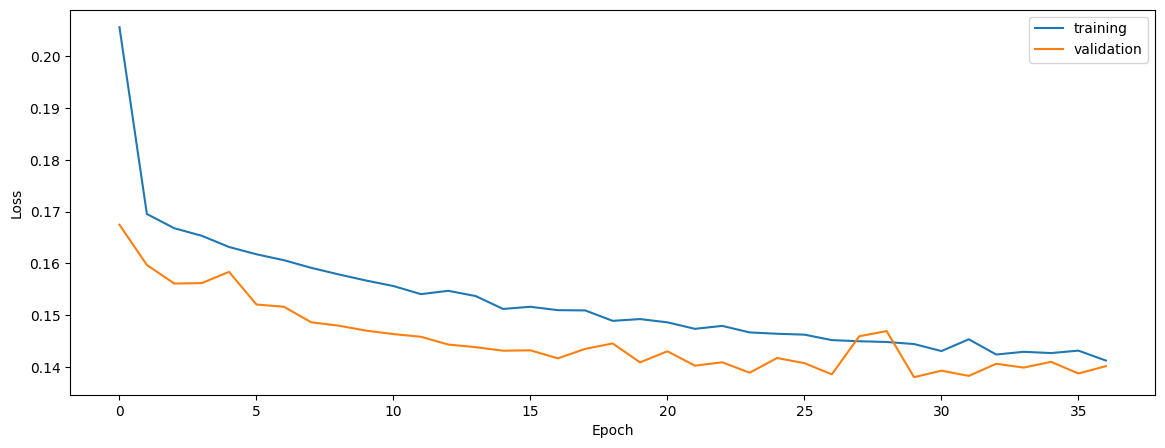

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6759981747661419
0.6620320567986231
0.6307316434710527


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6719593808945505
0.657388051490813
0.6245973090771272


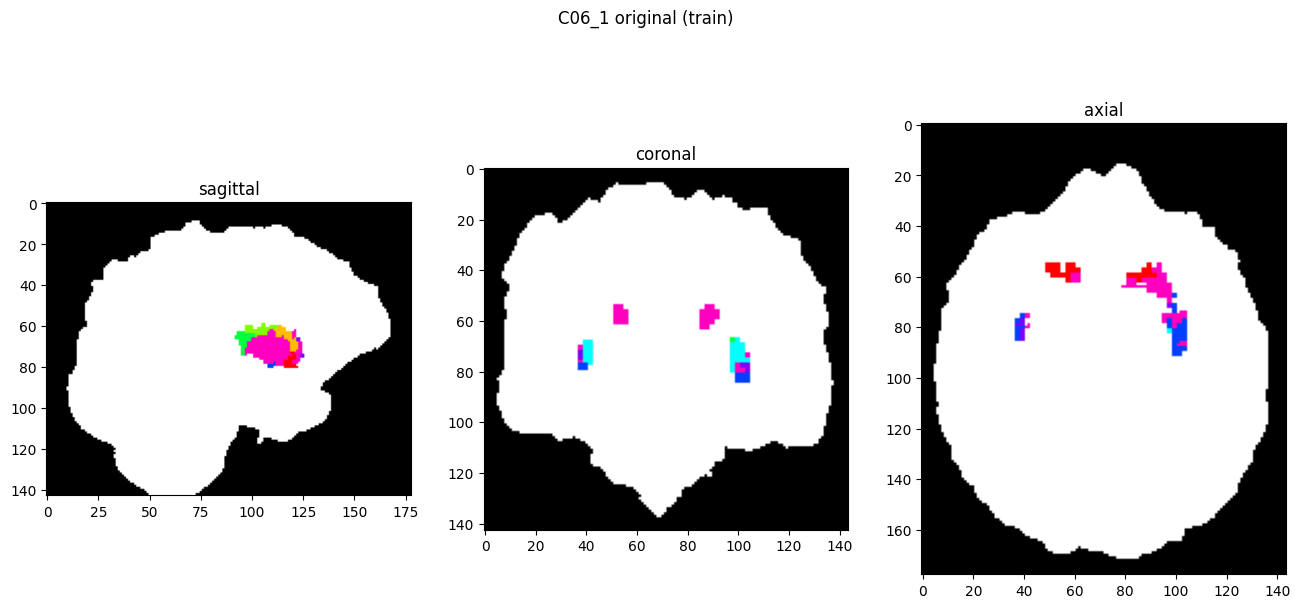

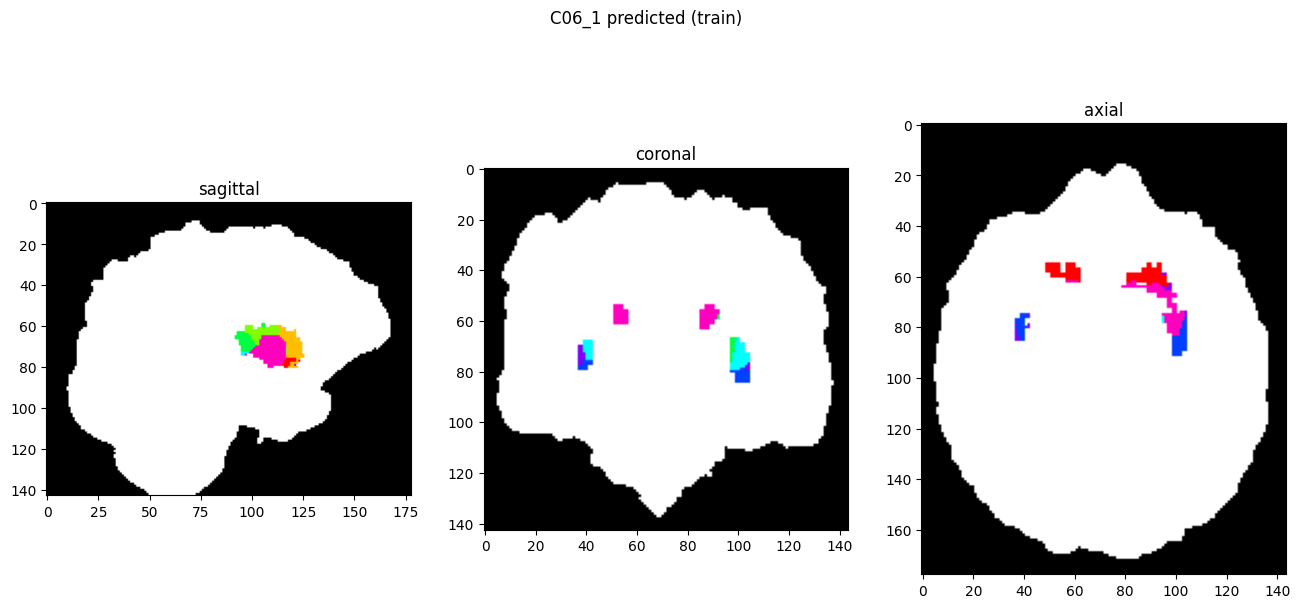

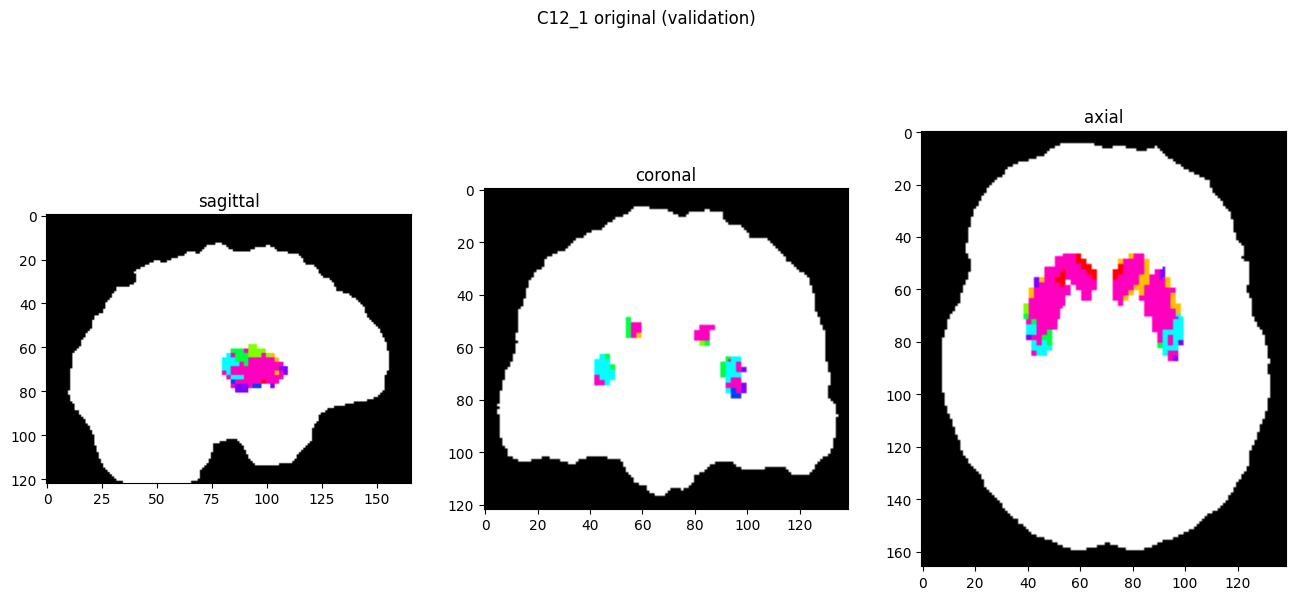

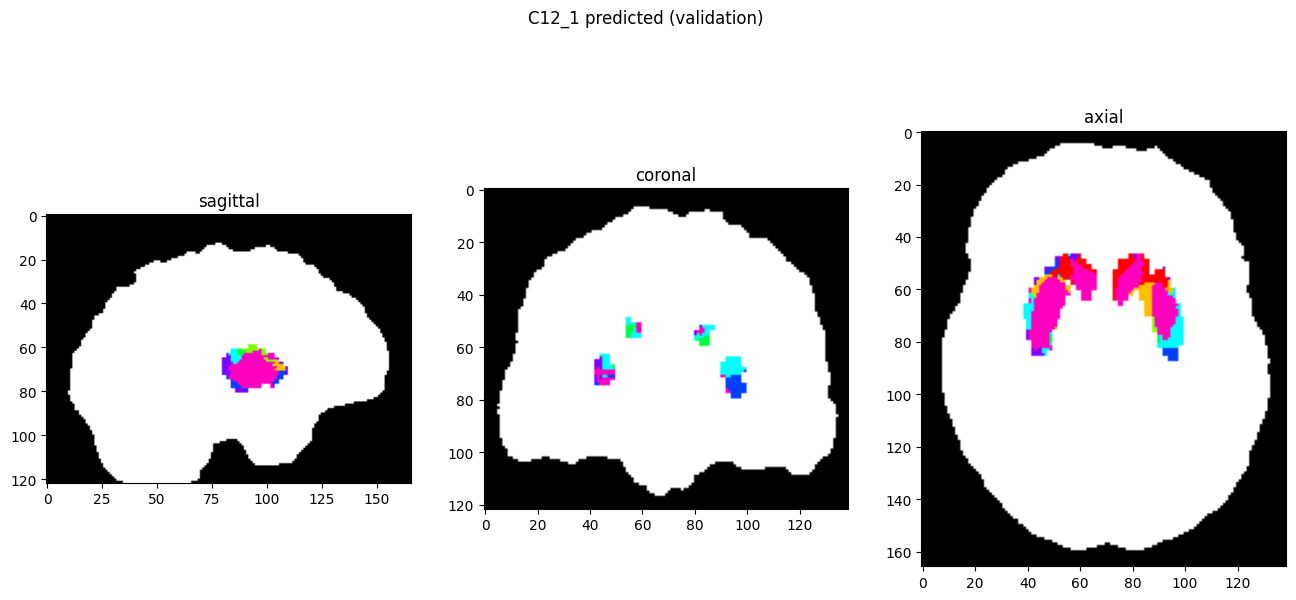

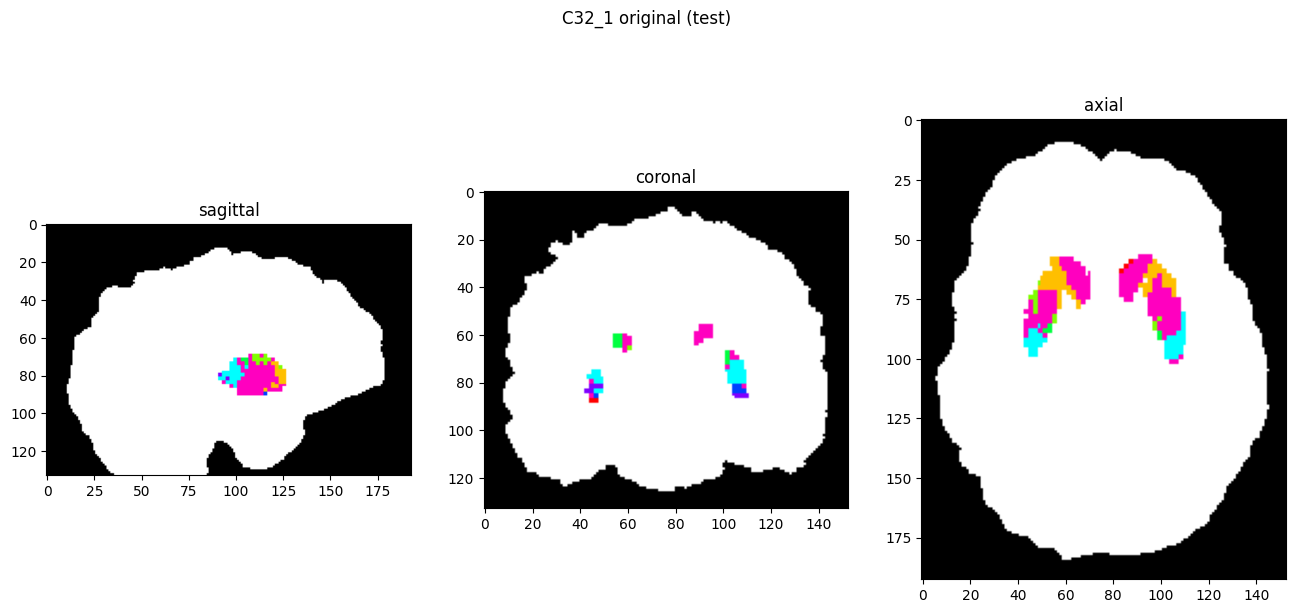

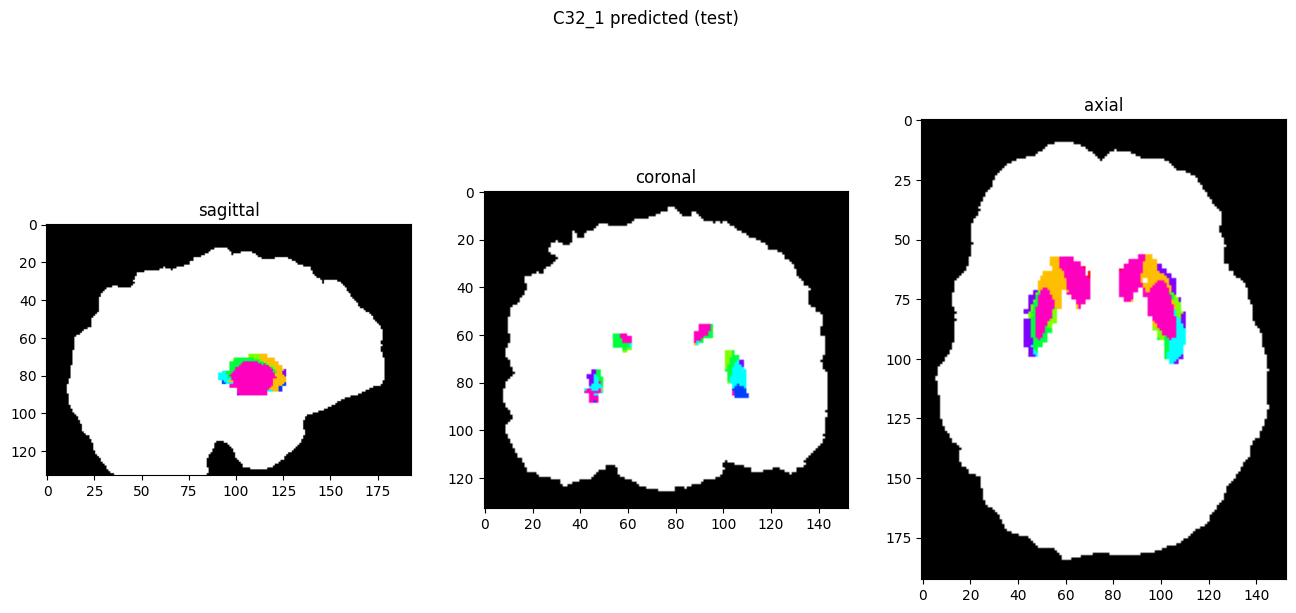

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)